# Data Pipeline

In [1]:
import sys, os
sys.path.insert(0, '..')

import pandas as pd
ROOT = ""

In [2]:
from google.colab import drive
import pandas as pd
drive.mount('drive')
ROOT = "/content/drive/My Drive/iri_bengali_data"


Mounted at drive


In [3]:
USE_TRANSLATED = False

df = pd.read_csv(os.path.join(ROOT, "fiveFoldStratifiedSamplingWithTranslation.csv"), index_col=0)
X_trains, X_tests, y_trains, y_tests = [[df[col][df[f"split_{i}"] == cat] for i in range(5)]
        for col in ('content' if not USE_TRANSLATED else 'translated', 'is_flood') 
        for cat in ('test', 'train')
        ]

X_trains_eng, X_tests_eng, y_trains_eng, y_tests_eng = [[df[col][df[f"split_{i}"] == cat] for i in range(5)]
        for col in ('translated', 'is_flood') 
        for cat in ('test', 'train')
    ]
print(f"{len(y_trains)} folds\n{len(y_trains[0])} training examples\n{len(y_tests[0])} test examples")

5 folds
804 training examples
202 test examples


# Loading Models

In [4]:
!pip install transformers &> /dev/null
!pip install simpletransformers &> /dev/null

In [5]:
from abc import ABC, abstractclassmethod, abstractmethod

class FloodClassificationModel(ABC):

    @abstractclassmethod
    def predict(batch):
        raise NotImplementedError

    @abstractmethod
    def load_pretrained(fold):
        raise NotImplementedError

In [6]:
import pandas as pd

class KeywordModel(FloodClassificationModel):
    damaged_keywords = {
        "ক্ষয়ক্ষতি": "damage",
        "ক্ষয়": "damage",
        "ক্ষতিগ্রস্ত": "damaged",
        "নষ্ট": "damaged"
    }
    
    waterlogged_keywords = {
        "পানিবন্দী": "waterlogged",
        "নিমজ্জিত": "submerged",
        "পানিবন্দি": "waterlogged"
    }
    
    flood_keywords = {
        "বন্যা": "flood",
        "পাহাড়ি ঢলে": "steam coming down the hill",
        "বেড়িবাঁধ ক্ষতিগ্রস্ত": "embankment damaged",
        "বেড়িবাঁধ উপচে": "water overflew the embankment"
    }
    
    cyclone_keywords = {
        "ঘূর্ণিঝড়": "cyclone"
    }
    
    def predict(self, batch):
        shammanul_keywords_single = KeywordModel.damaged_keywords.keys() | KeywordModel.waterlogged_keywords.keys() | KeywordModel.flood_keywords.keys() | KeywordModel.cyclone_keywords.keys()
        counts = pd.DataFrame([{kw: txt.count(kw) for kw in shammanul_keywords_single} for txt in batch])
        dmged = counts[list(KeywordModel.damaged_keywords.keys() | KeywordModel.waterlogged_keywords.keys())].sum(axis=1)
        flooded = counts[list(KeywordModel.flood_keywords.keys() | KeywordModel.cyclone_keywords.keys())].sum(axis=1)
        return (dmged > 0) & (flooded > 0)

    def load_pretrained(fold):
        return KeywordModel()

In [7]:
import os, pickle

class SKlearnModel(FloodClassificationModel):
    def __init__(self, classifier, vectorizer):
        self.cls = classifier
        self.vect = vectorizer

    def predict(self, batch):
        X = self.vect.transform(batch)
        return self.cls.predict(X)

    def load_pretrained(fold, model_type = "LinearSVC", root = ""):
        if model_type in ['LinearSVC', 'LogRegL1', 'LogRegL2', 'RandomForest']:
            with open(os.path.join(root, "models", model_type, f"classifier_fold_{fold}"), 'rb') as f:
                cls = pickle.load(f)
            with open(os.path.join(root, "models", model_type, f"vectorizer_fold_{fold}"), 'rb') as f:
                vect = pickle.load(f)
            return SKlearnModel(cls, vect)
        raise NotImplementedError

In [8]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs

import os
import torch

class EnglishTranslatedBERT(FloodClassificationModel):
    def __init__(self, model):
        self.model = model

    def predict(self, batch, lang = 'en'):
        # Translate batch
        if lang == 'en':
            return self.model.predict(list(batch))[0]
        else:
            raise NotImplementedError

    def load_pretrained(fold, root='', use_cuda = True):
        device = torch.device("cuda" if use_cuda else "cpu")

        model_args = ClassificationArgs(max_seq_length=512)
        model = ClassificationModel("bert", "bert-base-uncased", use_cuda = use_cuda)
        model.model.load_state_dict(torch.load(os.path.join(root, "models/EngTranslatedBERT", f"eng_translated_bert_fold_{fold}.ckpt"), map_location=device))

        return EnglishTranslatedBERT(model)

In [9]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs

import os
import torch

class MultiLingualBERT(FloodClassificationModel):
    def __init__(self, model):
        self.model = model

    def predict(self, batch):
        return self.model.predict(list(batch))[0]

    def load_pretrained(fold, root='', use_cuda = True):
        device = torch.device("cuda" if use_cuda else "cpu")

        model_args = ClassificationArgs(max_seq_length=512)
        model = ClassificationModel("bert", "bert-base-multilingual-uncased", use_cuda = use_cuda)
        model.model.load_state_dict(torch.load(os.path.join(root, "models/MultiLingualBERT", f"multilingual_bert_fold_{fold}.ckpt"), map_location=device))

        return MultiLingualBERT(model)

In [10]:
from transformers import BertTokenizer, BertModel

import os
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn


from tqdm.auto import tqdm

class Multilingual_BERT_Classifier(nn.Module):
    def __init__(self, bert_model):
        super(Multilingual_BERT_Classifier, self).__init__()
        
        self.bert = bert_model
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(768, 1),
        )
        
    def forward(self, X):
        output = self.bert(**X)['pooler_output']
        logits = self.classifier(output)
        return logits
    
    def train(self):
        self.bert.train()

class MultiLingualBERT2(FloodClassificationModel):
    def __init__(self, model):
        self.model = model
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')

    def collate_batch(self, batch, MAX_SEQ_LEN = 512):
        text = batch
        text_enc = self.tokenizer(text, padding="max_length", truncation=True, return_tensors = "pt", max_length=MAX_SEQ_LEN)
        
        return text_enc.to(self.device)

    def predict(self, batch, use_cuda = torch.cuda.is_available()):
        self.device = torch.device("cuda" if use_cuda else "cpu")
        ds = DataLoader(list(batch), batch_size = 1, shuffle=False, collate_fn = self.collate_batch)
        preds = []
        progress_bar = tqdm(range(len(ds)))
        for X in ds:
          with torch.no_grad():
            output = self.model(X)
            pred = 1*(output > 0).squeeze()
            preds.append(pred.cpu().item())
          progress_bar.update(1)
        return preds

    def load_pretrained(fold, epoch = 64, root='', use_cuda = torch.cuda.is_available()):
        device = torch.device("cuda" if use_cuda else "cpu")
        model = torch.load(os.path.join(root, "models/MultiLingualBERT2", f"multilingual_BERT_epoch_{epoch}_fold_{fold}.ckpt"), map_location = device)
        return MultiLingualBERT2(model)

In [11]:
from transformers import BertTokenizer, BertModel

import os
import torch
from torch.utils.data import DataLoader
import torch.nn as nn

from tqdm.auto import tqdm

class Bangla_Based_BERT_Classifier(nn.Module):
    def __init__(self, bert_model):
        super(Bangla_Based_BERT_Classifier, self).__init__()
        
        self.bert = bert_model

        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(102025, 1)
        )
        
    def forward(self, X):
        output = self.bert(**X)
        class_out = output['logits'][:, 0, :]
        logits = self.classifier(class_out)
        return logits
    
    def train(self):
        self.bert.train()

class BanglaBERT(FloodClassificationModel):
    def __init__(self, model):
        self.model = model
        self.tokenizer = BertTokenizer.from_pretrained("sagorsarker/bangla-bert-base")

    def collate_batch(self, batch, MAX_SEQ_LEN = 512):
        text = batch
        text_enc = self.tokenizer(text, padding="max_length", truncation=True, return_tensors = "pt", max_length=MAX_SEQ_LEN)
        
        return text_enc.to(self.device)

    def predict(self, batch, use_cuda = torch.cuda.is_available()):
        
        self.device = torch.device("cuda" if use_cuda else "cpu")
        ds = DataLoader(list(batch), batch_size = 1, shuffle=False, collate_fn = self.collate_batch)
        progress_bar = tqdm(range(len(ds)))
        preds = []
        for X in ds:
          with torch.no_grad():
            output = self.model(X)
            pred = 1*(output > 0).squeeze()
            preds.append(pred.cpu().item())
          progress_bar.update(1)
        return preds

    def load_pretrained(fold, epoch = 32, root='', use_cuda = torch.cuda.is_available()):
        device = torch.device("cuda" if use_cuda else "cpu")
        model = torch.load(os.path.join(root, "models/BanglaBERT", f"bangla_bert_epoch_{epoch}_fold_{fold}.ckpt"), map_location = device)
        return BanglaBERT(model)

In [12]:
use_cuda = torch.cuda.is_available()
FOLD_INDEX = 0
models = {
    "KeywordModel": KeywordModel.load_pretrained(FOLD_INDEX),
    "LinearSVC": SKlearnModel.load_pretrained(FOLD_INDEX, model_type='LinearSVC', root=ROOT),
    "LogRegL1": SKlearnModel.load_pretrained(FOLD_INDEX, model_type='LogRegL1', root=ROOT),
    "LogRegL2": SKlearnModel.load_pretrained(FOLD_INDEX, model_type='LogRegL2', root=ROOT),
    "RandomForest": SKlearnModel.load_pretrained(FOLD_INDEX, model_type='RandomForest', root=ROOT),
    #"EngTranslatedBERT": EnglishTranslatedBERT.load_pretrained(FOLD_INDEX, root=ROOT, use_cuda=use_cuda),
    #"MultiLingualBERT": MultiLingualBERT2.load_pretrained(FOLD_INDEX, root=ROOT, use_cuda=use_cuda),
    #"BanglaBERT": BanglaBERT.load_pretrained(FOLD_INDEX, root=ROOT, use_cuda=use_cuda)
}

# Evalutions

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [ ]:
use_cuda = torch.cuda.is_available()
models = {
    "KeywordModel": KeywordModel.load_pretrained(0),
    "LinearSVC": SKlearnModel.load_pretrained(0, model_type='LinearSVC', root=ROOT),
    "LogRegL1": SKlearnModel.load_pretrained(0, model_type='LogRegL1', root=ROOT),
    "LogRegL2": SKlearnModel.load_pretrained(0, model_type='LogRegL2', root=ROOT),
    "RandomForest": SKlearnModel.load_pretrained(0, model_type='RandomForest', root=ROOT),
    #"EngTranslatedBERT": EnglishTranslatedBERT.load_pretrained(0, root=ROOT, use_cuda=use_cuda),
    #"MultiLingualBERT": MultiLingualBERT.load_pretrained(0, root=ROOT, use_cuda=use_cuda)
}

In [ ]:
predictions = {}

In [ ]:
def accuracy_statisitics(model_name, fold = 0, use_eng = False):
  if not use_eng:
    X, y = X_tests[fold], y_tests[fold]
  else:
    X, y = X_tests_eng[fold], y_tests_eng[fold]
  if model_name in predictions:
    y_pred = predictions[model_name]
  else:
    y_pred = models[model_name].predict(X)
    predictions[model_name] = y_pred
  acc = accuracy_score(y, y_pred)
  pre, rec, fscore, _ = precision_recall_fscore_support(y, y_pred, average='binary')
  return {'accuracy': acc, 'precision': pre, 'recall': rec, 'fscore': fscore}

In [ ]:
res = {model_name: accuracy_statisitics(model_name, use_eng = (model_name == 'EngTranslatedBERT')) for model_name in  models.keys()}

In [ ]:
pd.DataFrame(res)

,KeywordModel,LinearSVC,LogRegL1,LogRegL2,RandomForest,EngTranslatedBERT,MultiLingualBERT,BanglaBERT
accuracy,0.579208,0.935644,0.910891,0.925743,0.891089,0.900990,0.910891,0.881188
precision,0.448276,0.925373,0.871429,0.866667,0.863636,0.847222,0.882353,0.979167
recall,0.928571,0.885714,0.871429,0.928571,0.814286,0.871429,0.857143,0.671429
fscore,0.604651,0.905109,0.871429,0.896552,0.838235,0.859155,0.869565,0.796610


In [ ]:
all_predications = pd.concat([X_tests[0].reset_index()['content'], X_tests_eng[0].reset_index()['translated'], y_tests[0].reset_index()['is_flood'], pd.DataFrame(predictions)], axis = 1)

In [ ]:
all_predications

,content,translated,is_flood,KeywordModel,LinearSVC,LogRegL1,LogRegL2,RandomForest,EngTranslatedBERT,MultiLingualBERT
0,>\nজনপ্রতিনিধিরা ব্যক্তিগত উদ্যোগে কিছু ত্রাণ ...,&gt; People&#39;s representatives have given s...,True,True,True,True,True,True,1,1
1,নিজের জন্মভূমিকে ধনধান্য পুষ্পভরা বসুন্ধরা হিস...,Dwijendralal Roy envisioned his homeland as a ...,False,True,False,False,False,False,0,0
2,ব্রহ্মপুত্র ও ঘাঘট নদের পানি বিপৎসীমার ওপর দিয়...,The overall flood situation in Gaibandha distr...,True,True,True,True,True,True,1,1
3,‘ইয়াসের খবর শুনে গ্রামের সবাই মিলে চেষ্টা করেছ...,"&#39;After hearing the news of Yas, everyone i...",True,True,True,True,True,True,1,0
4,হাওর অঞ্চলে চলছে ধান কাটার উৎসব। প্রথম দিকে শ্...,Paddy harvesting festival is going on in the h...,False,False,False,False,False,False,0,1
...,...,...,...,...,...,...,...,...,...,...
197,সংবাদ প্রতিদিন ডিজিটাল ডেস্ক: ঘূর্ণিঝড় ‘যশ’ (...,News Daily Digital Desk: The state has taken a...,False,False,False,False,False,False,0,0
198,সাত গম্বুজ মসজিদ ঢাকার মোহাম্মদপুরে অবস্থিত মো...,The Seven Dome Mosque is a unique structure bu...,False,False,False,False,False,False,0,0
199,আমরা ‘গ্রেট ডিপ্রেশন’ বা ভয়াবহ অর্থনৈতিক মন্দা...,We have read in the book about the &#39;Great ...,False,True,False,False,False,False,0,0
200,নোয়াখালীর ভাসানচর দ্বীপটি পুরোপুরি বাসযোগ্য বল...,A study has claimed that Bhasanchar Island in ...,False,False,False,False,False,False,0,0


In [ ]:
difficulty = 1 - 4 * (all_predications[list(set(all_predications) - set(['content', 'translated']))].mean(axis=1) - 0.5)**2 
incorrect = pd.concat([all_predications[m] != all_predications['is_flood'] for m in ['LinearSVC', 'LogRegL1', 'LogRegL2', 'EngTranslatedBERT']], axis = 1).sum(axis=1)

In [ ]:
for p in all_predications[incorrect > 2]['translated']:
  print(len(p.split(" ")), p)

465 Syed Shamim Shirazi from Sirajganj: Due to continuous rains and hill slopes coming down from Assam, India, the water level in the river Jamuna has increased near Sirajganj. As a result, due to the cyclone in the Jamuna stream, the river bank is eroding and the embankment is collapsing. The demolition has already started at Panchthakuri point near the city. As of the writing of this report, an area of 150 meters has been submerged in the riverbed. Although the intensity of the current has increased, there is a danger that the erosion of this part will become more and more intense. Locals complained that no official of the Water Development Board reached the spot even though the demolition continued. On the other hand, erosion has started in the riverine areas of 5 upazilas of Sirajganj district. The people on the banks of the river are terrified of the banner again. It is learned that the water of Jamuna river has swelled due to 36 hours of continuous rain and hill slope. As the sou

In [ ]:
all_predications['translated'].apply(lambda p: len(p.split(' '))).mean()

872.8118811881188

In [ ]:
def display_basic_evaluation(name, false_positives, false_negatives):
    print("-"* 100)
    print(f"Model: {name}")
    print("-"* 100)
    

    fp, fn = false_positives, false_negatives
    fp_cnts = count_table(df.iloc[fp.index]).mean()
    fn_cnts = count_table(df.iloc[fn.index]).mean()
    kw_summary = pd.concat([fp_cnts, fn_cnts, positive_kw_mean, negative_kw_mean, kw_mean], axis = 1, keys = ["FP Mean", 
                                                                      "FN Mean", 
                                                                      "Positives Mean", 
                                                                      "Negatives Mean", 
                                                                      "Mean"])
    print(kw_summary.to_markdown())
    print("-----False Postives-----")
    print("Total: {}".format(len(fp)))

    for i, text in enumerate(list(df.iloc[fp.index]['translated'].sample(min(10, len(fp))) )):
        print(f"{i})", text[:1000])
        print()
    print("-----False Negatives-----")
    print("Total: {}".format(len(fn)))
    for i, text in enumerate(list(df.iloc[fn.index]['translated'].sample(min(10, len(fn))) )):
        print(f"{i})", text[:1000])
        print()
    return kw_summary

# Timeseries

## Preliminary Functions

In [13]:
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
# Idea linear series of days, pass 1D kernel over days, Kernel should have 99% within 1.5 months (45 days) 

def gaussian_kernel(mu = 0, sigma = 15, window = None, with_window=False):
    if window == None:
        window = 6 * sigma + 1
    else:
        assert(window % 2 == 1)
    
    X = np.arange(-window//2 + mu, window//2 + 1 + mu)
    y = (1/(np.pi*sigma))**(1/2) * np.exp(-(X - mu)**2/sigma**2)
    if with_window:
        return X, y
    return y

def to_datetime(dt):
    return datetime.strptime(dt, "%Y-%m-%d %H:%M:%S")

def timeseries_from_dates(dates, pad = 15, date_range = (datetime(2010, 1, 1), datetime.now()), resolution = timedelta(days = 1)):
    days_from_now = np.array([(datetime.now() - x).days for x in dates])
    y, days_bins = np.histogram(dates, bins = np.arange(date_range[0], date_range[1] + pad * resolution, resolution))
    X = days_bins[:-1]
    return X, y


#### Proper Date Extraction For Bengali Dates

In [14]:
import re

__bengali_unicode_exeptions__ = set((2436, 2445, 2446, 2449, 2450, 2473, 2481, 2483, 2484, 2485, 2490, 2491, 2501, 2502, 2505, 2506, 2526, 2532, 2533)) | set(range(2511, 2519)) | set(range(2520, 2524))
bengaliTextChars = set(chr(x) for x in range(2432, 2559) if x not in __bengali_unicode_exeptions__)
punctuations = set('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~।ঃ‘’–')
digits = set('০১২৩৪৫৬৭৮৯')
whitespaces = set(" \t\r\n\f")
bengaliChars = bengaliTextChars | punctuations | whitespaces

numbersBengaliEnglish = {b:e for b, e in zip('০১২৩৪৫৬৭৮৯', '0123456789')}
monthsBengaliEnglish = {b:e for b, e in zip(
    ['জানুয়ারি', 'ফেব্রুয়ারি', 'মার্চ', 'এপ্রিল', 'মে', 'জুন', 'জুলাই', 'আগস্ট', 'সেপ্টেম্বর', 'অক্টোবর', 'নভেম্বর', 'ডিসেম্বর', "জানু", "ফেব"], 
    ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December', 
     "January", 'February'])}
timeWordsBegnaliEnglish = {b:e for b, e in zip(["আগে", "দিন", "ঘন্টা", "আগে"], ["ago", "days", "hours", "before"])}

def translateBengaliDate(date):
    splitOn = punctuations | whitespaces

    translated = "".join(c if c not in splitOn else " " for c in date)
    translated = "".join(c if c not in numbersBengaliEnglish else numbersBengaliEnglish[c] for c in translated)
    translated = translated.split(" ")
    translated = (w if w not in monthsBengaliEnglish else monthsBengaliEnglish[w] for w in translated)
    translated = (w if w not in timeWordsBegnaliEnglish else timeWordsBegnaliEnglish[w] for w in translated)
    translated = " ".join(translated)

    return translated

def extract_bengali_date(text):
  if not isinstance(text, str):
    return None

  ext = re.match("(\d+)\s+([A-Z][a-z]+)\s+(\d{4})", translateBengaliDate(text))
  if ext is None:
    return None
  return datetime.strptime(f"{ext[1]} {ext[2]} {ext[3]}", "%d %B %Y")

## Building Timeseries

In [15]:
import pandas as pd

dataframes = {
    "all": pd.read_csv(os.path.join(ROOT, "হয়েছে_scrape_dataset.csv"), delimiter = "\t"),
    "exact": pd.read_csv(os.path.join(ROOT, "exact_scrape_dataset.csv"), delimiter = "\t")
}
dataframes["all"]["date"] = dataframes["all"]["date"].apply(to_datetime)
dataframes["exact"]["date"] = dataframes["exact"]["date"].apply(extract_bengali_date)
dataframes["exact"] = dataframes["exact"].dropna().reset_index()
cached_predictions = {k:{} for k in dataframes.keys()}

In [16]:
def flood_timeseries(df, flood_events, norm_df, date_range= (datetime(2013, 1, 1), datetime.now()), kernel = gaussian_kernel(sigma=15)):

    X, y = timeseries_from_dates(df[flood_events]['date'], date_range=date_range)
    X_norm, y_norm = timeseries_from_dates(norm_df['date'], date_range=date_range)
    
    y_smoothed = np.convolve(y, kernel, 'same')
    y_norm_smoothed = np.convolve(y_norm, kernel, 'same')

    return X, y_smoothed, y_norm_smoothed

def flood_timeseries_with_model(df_name, model_name, norm_df = None, date_range = (datetime(2013, 1, 1), datetime.now())):
    df = dataframes[df_name]
    model = models[model_name]

    if norm_df is None:
        norm_df = df

    if df_name in cached_predictions and model_name in cached_predictions[df_name]:
        flood_events = cached_predictions[df_name][model_name]
    else:
        flood_events = model.predict(df['content'])
        cached_predictions[df_name][model_name] = flood_events
    
    X, y, y_norm = flood_timeseries(df, flood_events, norm_df, date_range)

    return X, y/(y_norm+1)

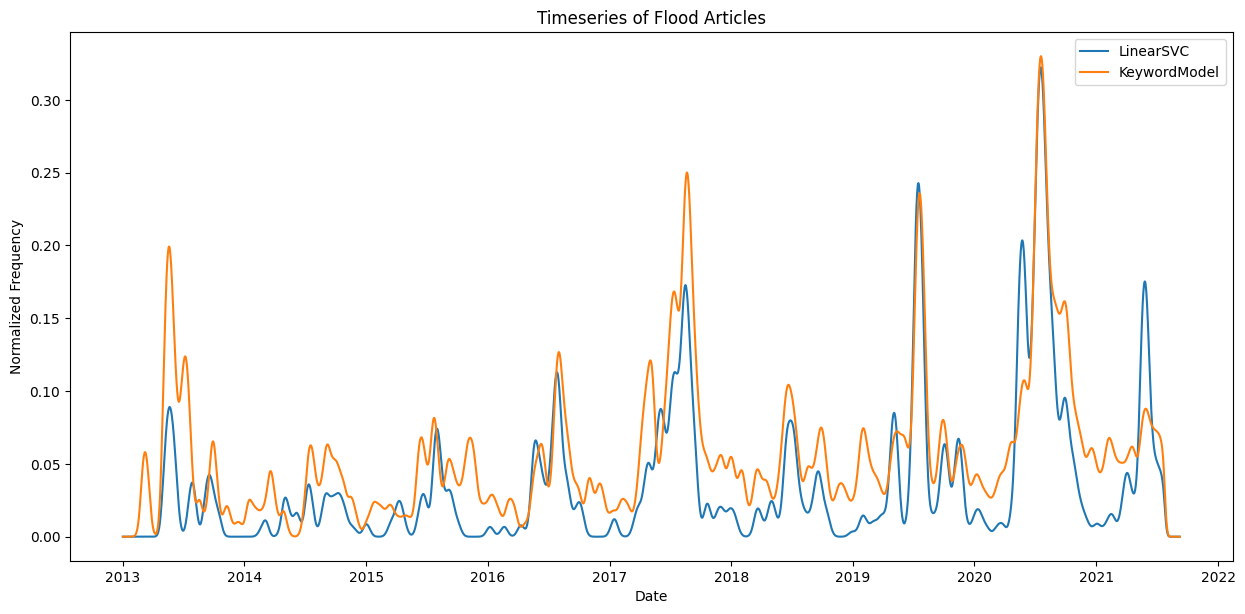

In [17]:
fig=plt.figure(figsize=(15,7), dpi= 100, edgecolor='k')

plt.title("Timeseries of Flood Articles")
for mn in ('LinearSVC', 'KeywordModel'):
    X, y = flood_timeseries_with_model('exact', mn)
    plt.plot(X, y, label = mn)

plt.legend()
plt.xlabel("Date")
plt.ylabel("Normalized Frequency")
plt.show()

In [34]:
locations = dataframes['exact'][cached_predictions['exact']['LinearSVC']]['content'].apply(lambda txt: geoParser.locate(preprocess_bangla(txt), thres=20))

In [36]:
def getLocationMask(division):
  articles = locations.apply(lambda entry: division in  entry)
  articles = articles[articles]
  mask = np.zeros(len(dataframes['exact']))
  mask[articles.index] = 1
  articles = mask==1
  return articles

location_articles = {}
for loc in set(divisions.values()):
  location_articles[loc] = getLocationMask(loc)
  print(f"{sum(location_articles[loc])} articles bound associated with {loc}")


327 articles bound associated with rangpur
348 articles bound associated with khulna
166 articles bound associated with sylhet
113 articles bound associated with mymensingh
179 articles bound associated with rajshahi
303 articles bound associated with chittagong
333 articles bound associated with barisal
386 articles bound associated with dhaka


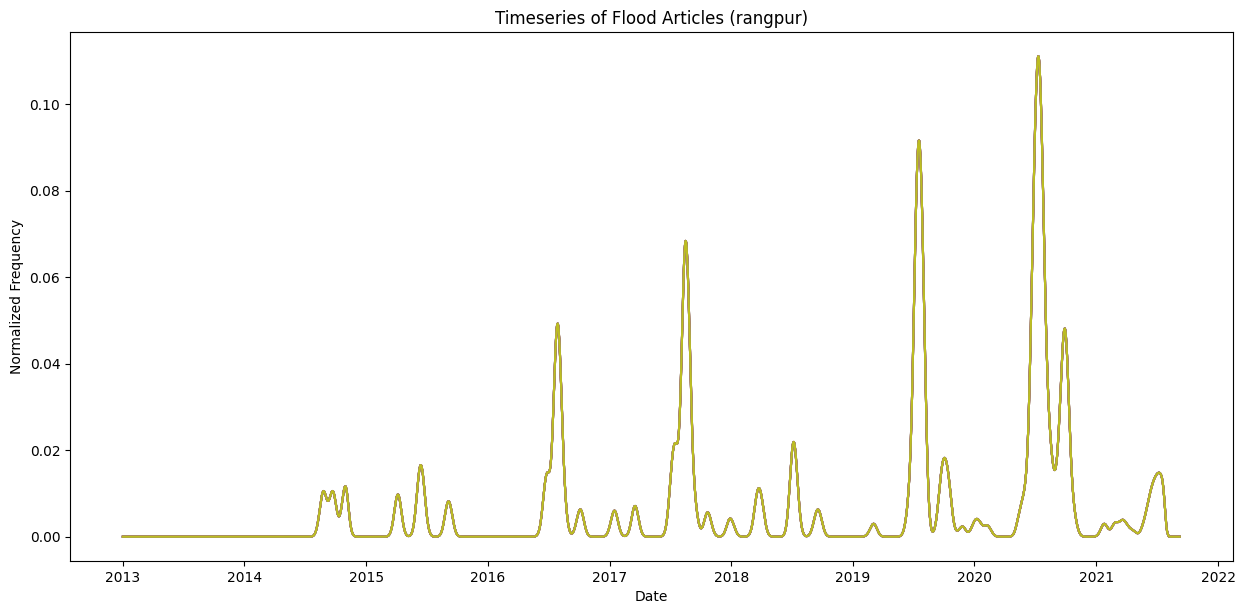

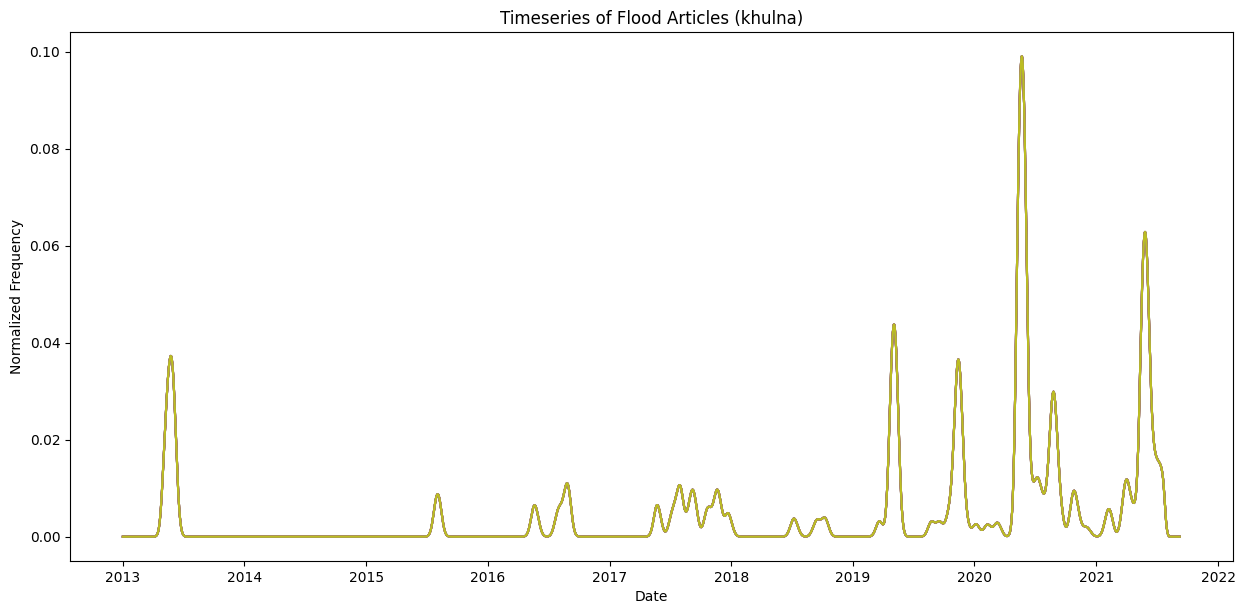

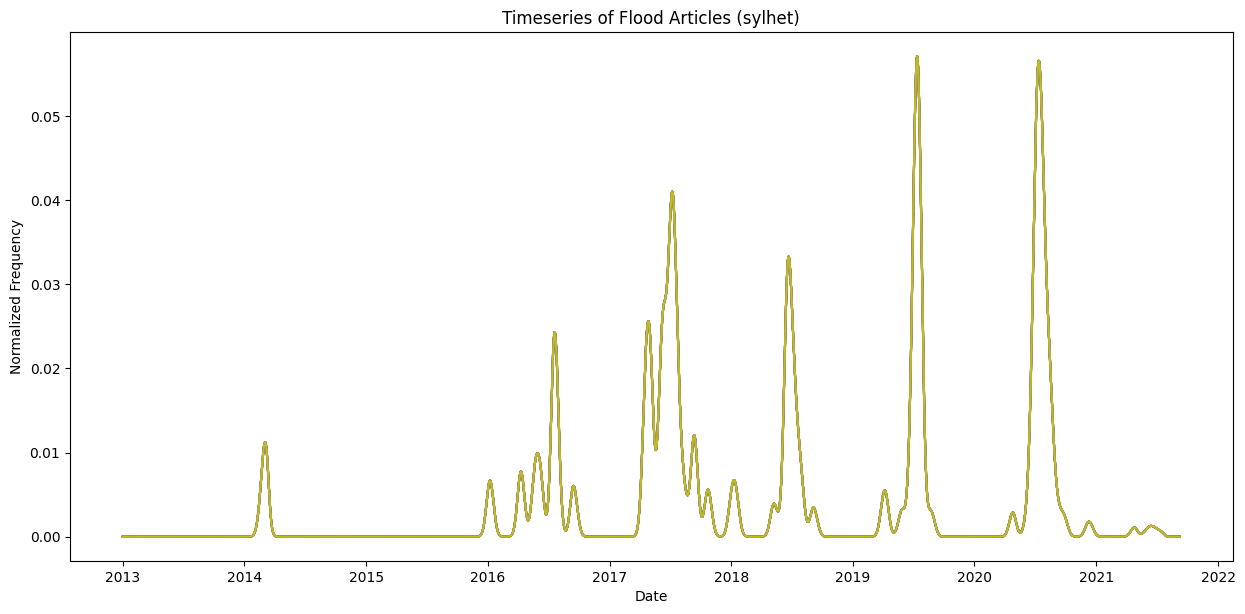

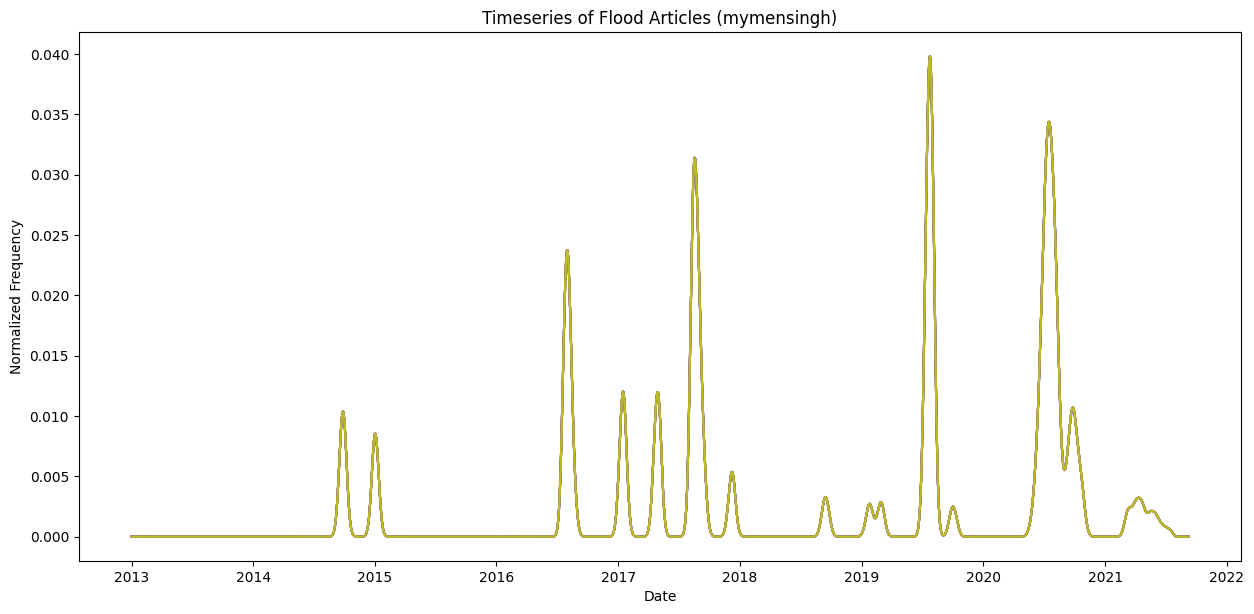

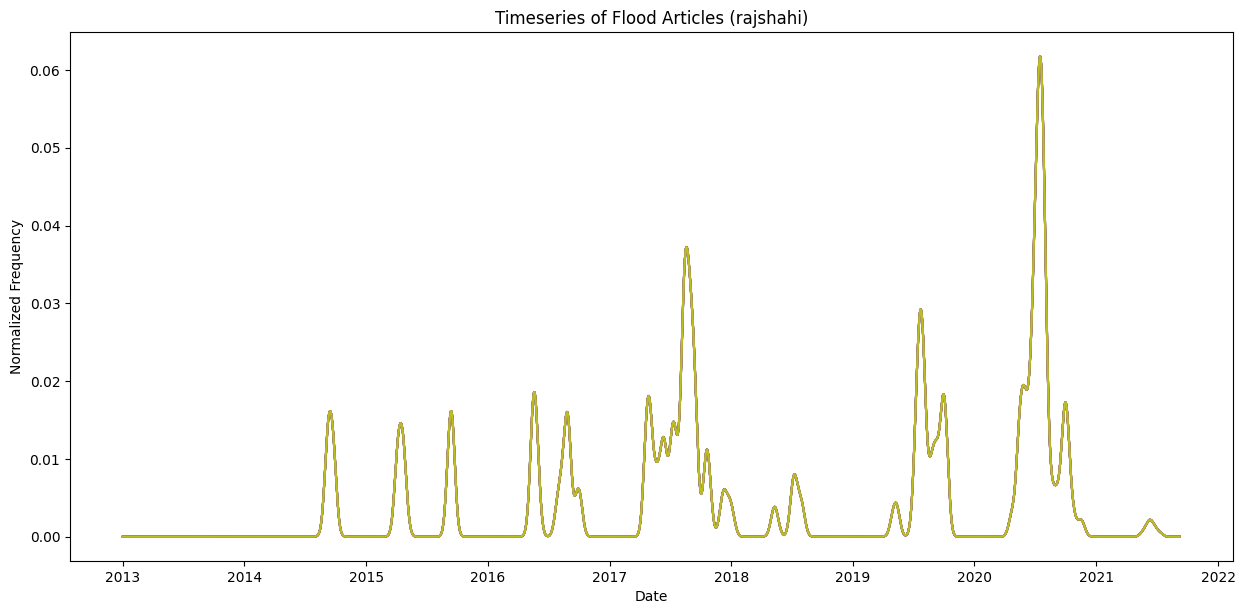

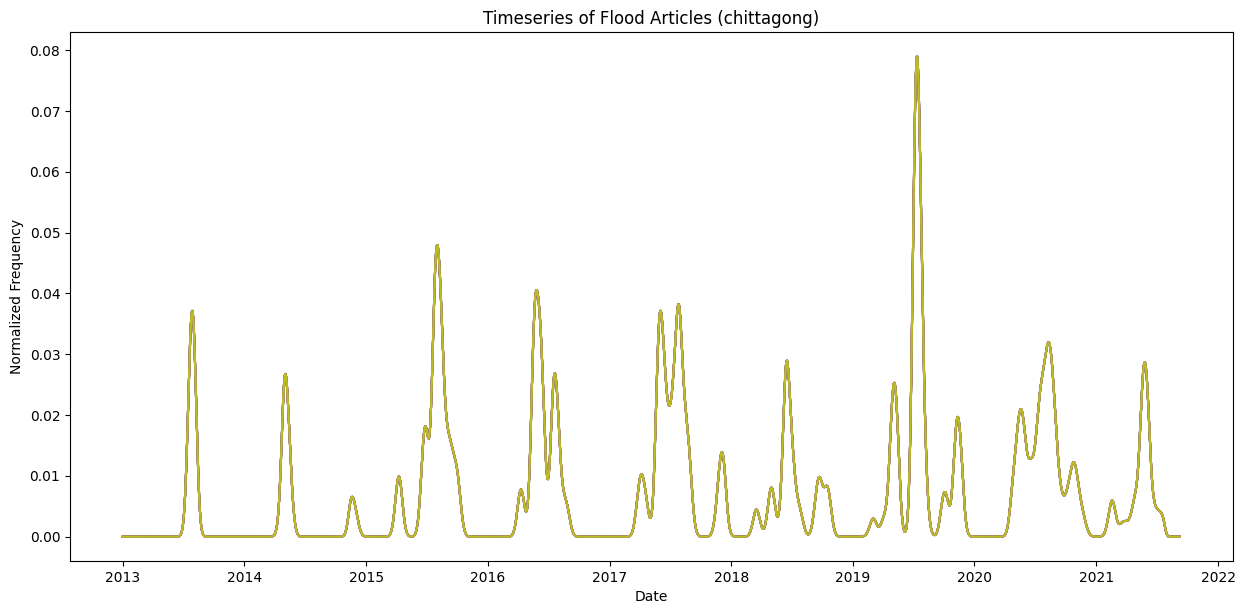

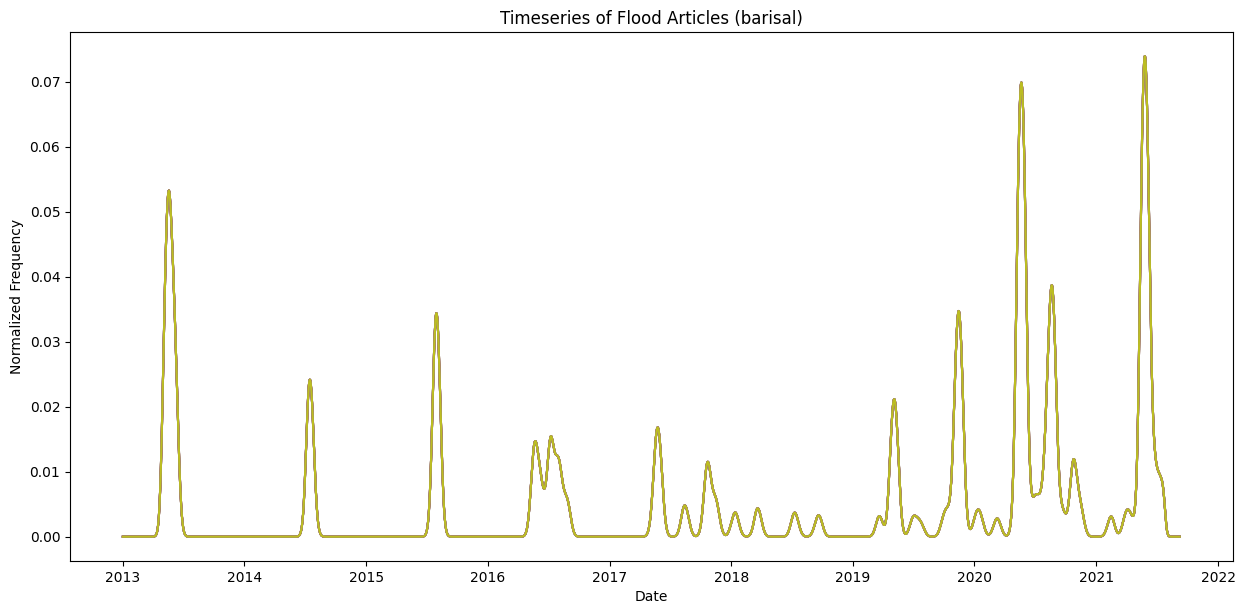

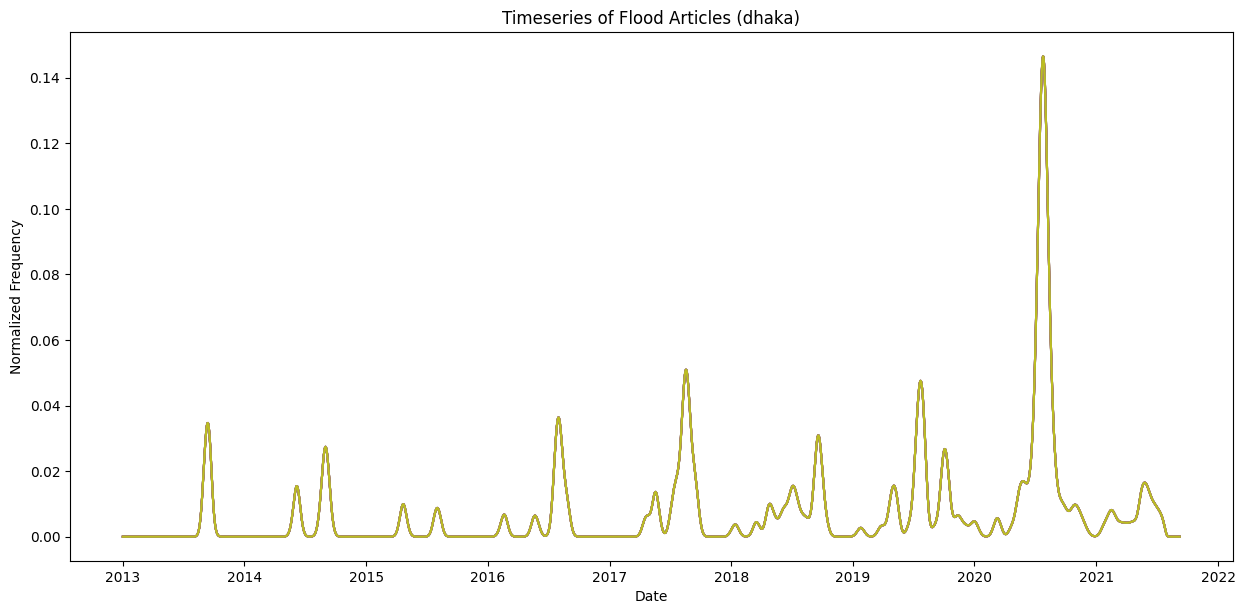

In [38]:
for loc, articles in location_articles.items():
  fig=plt.figure(figsize=(15,7), dpi= 100, edgecolor='k')

  plt.title(f"Timeseries of Flood Articles ({loc})")
  for mn in ('LinearSVC'):
      X, y, y_normed = flood_timeseries(dataframes['exact'], articles, norm_df=dataframes['exact'])
      y = y/(y_normed+1)
      plt.plot(X, y, label = mn)

  #plt.legend()
  plt.xlabel("Date")
  plt.ylabel("Normalized Frequency")
  plt.show()

In [ ]:
geoparser = OccurrenceGeoParser()
locations = dataframes['exact']['content'].apply(lambda txt: geoparser.locate(preprocess_bangla(txt)))

KeyboardInterrupt: ignored

In [ ]:
chittagong_articles = locations.apply(lambda entry: "chittagong" in  entry)
chittagong_articles = chittagong_articles[chittagong_articles]
mask = np.zeros(len(dataframes['exact']))
mask[chittagong_articles.index] = 1
chittagong_articles = mask==1

In [ ]:
dataframes['exact'].iloc[chittagong_articles.index]

,index,title,paper,date,link,headline,content,category,language
51,70,পাহাড় ধস রোধে টেকসই কোনো ... - Jugantor,the_daily_jugantor,2021-06-08,https://www.jugantor.com/todays-paper/last-pag...,পাহাড় ধস রোধে টেকসই কোনো ব্যবস্থা নেই,টানা বৃষ্টি বা বর্ষা মানেই পাহাড় ধস। এতে প্রাণ...,"['todays-paper', 'last-page', '428996']",Bengali
652,708,রেলের রাস্তায় পানি আটকে ডুবেছে ...,the_daily_jugantor,2020-06-17,https://www.jugantor.com/country-news/316946/%...,রেলের রাস্তায় পানি আটকে ডুবেছে ১৮ ইউনিয়ন,টানা একদিনের বর্ষণে কক্সবাজারের চকরিয়ায় বিপর্য...,"['country-news', '316946']",Bengali
1014,1171,ঘূর্ণিঝড় ইয়াসের অভিঘাত ...,prothom_alo,2021-05-26,https://www.prothomalo.com/opinion/editorial/%...,ঘূর্ণিঝড় ইয়াসের অভিঘাত,"ঘূর্ণিঝড় ইয়াস বাংলাদেশে আঘাত করেনি, করেছে ভারত...","['opinion', 'editorial']",Bengali
1876,2061,বৃষ্টিতে তলিয়ে গেছে খেত আলু ...,prothom_alo,2019-03-01,https://www.prothomalo.com/bangladesh/environm...,বৃষ্টিতে তলিয়ে গেছে খেত আলু বিনষ্টের আশঙ্কা,তিন দিনের টানা বৃষ্টির পানিতে চাঁদপুর সদর উপজে...,"['bangladesh', 'environment']",Bengali
2108,2314,প্যারাবনে পোকার আক্রমণ | প্রথম ...,prothom_alo,2017-12-05,https://www.prothomalo.com/bangladesh/district...,প্যারাবনে পোকার আক্রমণ,পোকার আক্রমণে ক্ষতিগ্রস্ত হয়েছে কক্সবাজারের টে...,"['bangladesh', 'district']",Bengali
...,...,...,...,...,...,...,...,...,...
28994,31092,'মরার উপর খাড়ার ঘা' | 368910 | কালের ...,kaler_kantho,2016-06-12,https://www.kalerkantho.com/print-edition/2nd-...,‘মরার উপর খাড়ার ঘা’,ঘূর্ণিঝড় রোয়ানুর আঘাতের ক্ষত না শুকাতেই ঝড়ো হা...,"['print-edition', '2nd-rajdhani', '2016', '06'...",Bengali
29028,31126,পাহাড়ে ধস-আতঙ্ক,the_daily_ittefaq,2019-07-11,https://www.ittefaq.com.bd/national/70052/%E0%...,পাহাড়ে ধস-আতঙ্ক,"দেশের তিন পার্বত্য জেলা খাগড়াছড়ি, রাঙ্গামাটি ও...","['national', '70052']",Bengali
29037,31136,বন্যার আরও বিস্তার ॥ ডুবছে নতুন ...,daily_sangram,2019-07-15,https://dailysangram.com/post/382815-%E0%A6%AC...,বন্যার আরও বিস্তার ॥ ডুবছে নতুন নতুন এলাকা,ইবরাহীম খলিল : দেশের বিভিন্ন অঞ্চলে প্রবল বর্ষ...,['post'],Bengali
29078,31180,অতি বর্ষণে বন্যার বিস্তার,the_daily_inqilab,2017-07-06,https://www.dailyinqilab.com/article/86266/%E0...,অতি বর্ষণে বন্যার বিস্তার,"কক্সবাজারে দু’জনের মৃত্যু, ৫ লাখ মানুষ পানিবন্...","['article', '86266']",Bengali


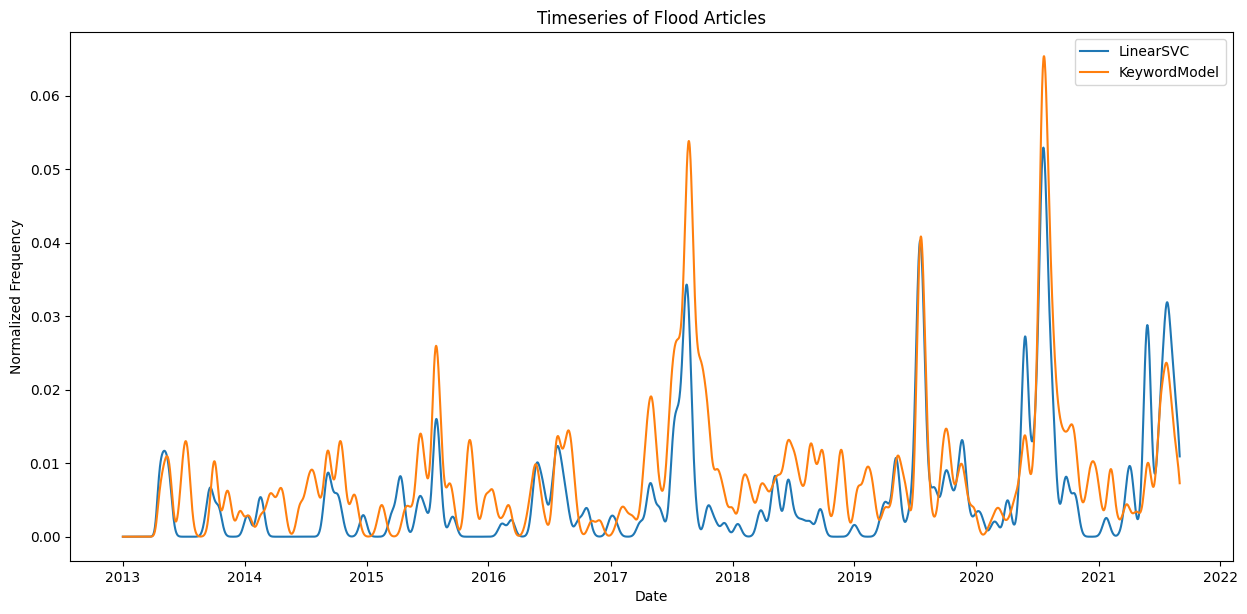

In [ ]:
fig=plt.figure(figsize=(15,7), dpi= 100, edgecolor='k')

plt.title("Timeseries of Flood Articles")
for mn in ('LinearSVC', 'KeywordModel'):
    X, y = flood_timeseries_with_model('all', mn)
    plt.plot(X, y, label = mn)

plt.legend()
plt.xlabel("Date")
plt.ylabel("Normalized Frequency")
plt.show()

# Visualizations

In [ ]:
svc = models['LinearSVC']

In [ ]:
dist_from_db = svc.cls.decision_function(svc.vect.transform(X_tests[0]))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


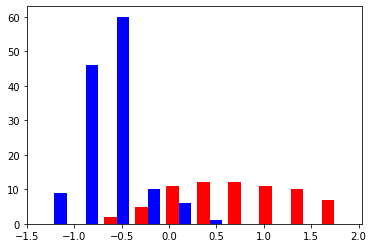

In [ ]:
import matplotlib.pyplot as plt
plt.hist([dist_from_db[y_tests[0]], dist_from_db[y_tests[0]==False]], bins = 10, color=['r', 'b'])
plt.show()

In [ ]:
dist_from_db[y_tests[0]==False]

array([-0.80986214, -0.20261477, -0.97030384, -0.55863841, -0.59776465,
       -0.88827717, -0.9607149 , -0.91321959, -1.02112592, -0.66586485,
       -0.60546186, -0.91925107, -0.83930248, -0.09653539, -0.10715284,
       -0.99210492, -0.58463851, -0.04947442, -0.42665836,  0.09668302,
       -0.91058721, -0.89549513, -0.39840616,  0.05775949, -0.94385007,
       -0.52664311, -0.61880273, -0.70043873, -0.85959199, -0.49775317,
       -0.7150315 , -0.89555234, -0.5806215 , -0.69741121,  0.11073549,
       -0.70757803, -1.01624495, -0.17464812, -0.96067104, -0.4012736 ,
       -0.81428821, -0.43631262, -1.37320252, -0.44471366, -0.77361472,
       -0.92825763, -0.65077527, -0.87824698, -0.73613119, -1.02331036,
       -0.87041361, -0.43062111, -0.66169725, -1.09113522, -0.60245368,
       -0.99228631, -0.53972367, -0.3079977 , -0.85374941, -1.08903089,
       -0.42385124, -0.87480108, -0.41211766, -0.94037727, -0.04153705,
       -0.49146342, -0.45194769, -0.19337663, -0.53262968, -0.70

# Location Finding

In [18]:
!pip install bnlp_toolkit &> /dev/null
!pip install gensim==4.0.1 &> /dev/null

In [21]:
import json

from bnlp import NER
from bnlp import BasicTokenizer
tokenizer = BasicTokenizer()

from collections import Counter, defaultdict

SAVE = False
LOAD = True
if SAVE:
  with open('divisions.txt', 'w', encoding='utf-8') as f:
    json.dump(divisions, f)

  with open('districts.txt', 'w', encoding='utf-8') as f:
    json.dump(districts, f)

  with open('upazilas.txt', 'w', encoding='utf-8') as f:
    json.dump(upazilas, f)

if LOAD:
  with open('divisions.txt', 'r', encoding = 'utf-8') as f:
    divisions = json.load(f)

  with open('districts.txt', 'r', encoding = 'utf-8') as f:
    districts = json.load(f, encoding = 'utf-8')

  with open('upazilas.txt', 'r', encoding = 'utf-8') as f:
    upazilas = json.load(f)

In [22]:
class LocationTree:
  def __init__(self, divisions, districts, upazilas):
    self.divisions = divisions
    self.districts = districts
    self.upazilas = upazilas

    self.division_districts = defaultdict(set)
    for key, district in districts.items():
      division = district.split(".")[0]
      self.division_districts[division].add(key)

    self.district_upazilla = defaultdict(set)
    for key, district in districts.items():
      division = district.split(".")[0]
      self.division_districts[division].add(key)

In [23]:
from abc import ABC, abstractclassmethod
class BengaliGeoParser(ABC):
  @abstractclassmethod
  def locate(self, tokens):
    raise NotImplementedError()

from collections import defaultdict
class OccurrenceGeoParser(BengaliGeoParser):
  def locate(self, tokens, level = 0, thres = 30):
    div, dis, upa = self.votes(tokens)
    if level == 0:
      n = sum(div.values())
      return tuple(k for k in div.keys() if div[k]/n *100 > thres)
  
  def votes(self, tokens):
    division_flooding = defaultdict(int)
    district_flooding = defaultdict(int)
    upazila_flooding = defaultdict(int)

    for tk in tokens:
      if tk in districts:
        division_flooding[districts[tk].split(".")[0]] += 1
        district_flooding[districts[tk]] += 1
        
        for k, upazila in upazilas.items():
          district = ".".join(upazila.split(".")[:2])
          if district == districts[tk]:
            upazila_flooding[upazila] += 1

      elif tk in upazilas:
        division_flooding[upazilas[tk].split(".")[0]] += 1
        district_flooding[".".join(upazilas[tk].split(".")[:2])] += 1
        upazila_flooding[upazilas[tk]] += 1

    return division_flooding, district_flooding, upazila_flooding


In [28]:
geoParser = OccurrenceGeoParser()

#for txt in dt:
#  print(geoParser.locate(txt))

In [ ]:
geoParser.votes(dt[0])

(defaultdict(int, {'dhaka': 4, 'khulna': 1, 'rangpur': 3}),
 defaultdict(int,
             {'dhaka.manikganj': 3,
              'dhaka.munshiganj': 1,
              'khulna.kushtia': 1,
              'rangpur.kurigram': 3}),
 defaultdict(int,
             {'dhaka.manikganj.daulatpur': 3,
              'dhaka.munshiganj.gazaria_upazila': 1,
              'dhaka.munshiganj.lohajang': 1,
              'dhaka.munshiganj.sirajdikhan': 1,
              'dhaka.munshiganj.sreenagar': 1,
              'dhaka.munshiganj.tongibari': 1,
              'khulna.kushtia.bheramara': 1,
              'khulna.kushtia.daulatpur': 1,
              'khulna.kushtia.khoksa': 1,
              'khulna.kushtia.kumarkhali': 1,
              'khulna.kushtia.mirpur': 1,
              'rangpur.kurigram.chilmari': 3}))

In [33]:
from bengali_preprocessing import preprocess_bangla

dt = [preprocess_bangla(txt) for txt in X_trains[0]]

In [ ]:
Counter((locations))
    for tk in tokens:
      if tk not in self.locations:
        continue
      
      mentions = locations_in_text(txt)
      votes = sum(mentions.values())
      for place, n in mentions.items():
        place = place[1].lower()
        division = place.split(".")[0]
        district = ".".join(place.split(".")[0:2])
        if division == 'barisal':
          division = 'barishal'
        if division == 'chattogram':
          division = 'chittagong'
        division_flooding[division] += n/votes
        district_flooding[district] += n/votes
        upazilla_flooding[place.lower()] += n/votes

In [ ]:
dt[0]

['চব়াঞ্চলে',
 'সাধাব়ণত',
 'আষাঢ়',
 'ভাদ্ব়',
 'মাসেব়',
 'মাঝামাঝি',
 'পব়্যন্ত',
 'বন্যা',
 'বন্যা',
 'মোকাবিলা',
 'ফসলেব়',
 'আবাদ',
 'আলাদা',
 'প্ব়স্তুতি',
 'এবাব়',
 'মাসে',
 'কুষ্টিয়াব়',
 'দৌলতপুব়',
 'উপজেলাব়',
 'ব়ামকৃষ্ণপুব়',
 'চিলমাব়ী',
 'ইউনিয়নেব়',
 'চব়াঞ্চলগুলোতে',
 'বন্যা',
 'দেয়নি',
 'হঠাৎ',
 'কব়ে',
 'আশ্বিনে',
 'বন্যা',
 'দিনেব়',
 'ব্যবধানে',
 'হুহু',
 'কব়ে',
 'পদ্মাব়',
 'পানি',
 'বেড়ে',
 'যাওয়ায়',
 'পানি',
 'উপচে',
 'চব়াঞ্চল',
 'প্লাবিত',
 'ইউনিয়নেব়',
 '<NUM>',
 'গ্ব়ামেব়',
 '<NUM>',
 'হাজাব়',
 'বাসিন্দা',
 'পানিবন্দী',
 'পড়েছে',
 'প্ব়তিদিন',
 'গড়ে',
 '৫',
 'সেন্টিমিটাব়',
 'কব়ে',
 'পানিব়',
 'উচ্চতা',
 'বাড়ছে',
 'চব়ম',
 'দুব়্ভোগে',
 'বাসিন্দাব়া',
 'মাঠেব়',
 'ফসল',
 'ডুবে',
 'নষ্ট',
 'এখনো',
 'সব়কাব়ি',
 'বেসব়কাব়িভাবে',
 'অঞ্চলে',
 'সাহায্য',
 'সহযোগিতা',
 'মেলেনি',
 'পানি',
 'উন্নয়ন',
 'বোব়্ড',
 'পাউবো',
 'বলছে',
 'গত',
 'সাত',
 'দিনে',
 'পানিব়',
 'উচ্চতা',
 'সবচেয়ে',
 'বেড়েছে',
 'পদ্মাব়',
 'বিপৎসীমা',
 'নিব়্ধাব়ণ',
 '<NUM>',


In [ ]:
locations = districts.copy()
locations.update(upazilas)
def locations_in_text(txt):
  return Counter((word, locations[word]) for word in tokenizer.tokenize(txt) if word in locations)

In [ ]:
division_flooding = defaultdict(int)
district_flooding = defaultdict(int)
upazilla_flooding = defaultdict(int)
for txt in df['content'][df['is_flood']]:
  mentions = locations_in_text(txt)
  votes = sum(mentions.values())
  for place, n in mentions.items():
    place = place[1].lower()
    division = place.split(".")[0]
    district = ".".join(place.split(".")[0:2])
    if division == 'barisal':
      division = 'barishal'
    if division == 'chattogram':
      division = 'chittagong'
    division_flooding[division] += n/votes
    district_flooding[district] += n/votes
    upazilla_flooding[place.lower()] += n/votes

In [ ]:
upazilas

{'অটওয়ারী': 'Rangpur.Panchagarh.Atwari',
 'অভয়নগর': 'Khulna.Jessore.Abhaynagar',
 'অষ্টগ্রাম': 'Dhaka.Kishoreganj.Austagram',
 'আক্কেলপুর': 'Rajshahi.Joypurhat.Akkelpur',
 'আগৈলঝাড়া': 'Barisal.Barisal.Agailjhara',
 'আজমিরিগঞ্জ': 'Sylhet.Habiganj.Ajmiriganj',
 'আটঘোরিয়া': 'Rajshahi.Pabna.Atghoria',
 'আটপাড়া': 'Mymensingh.Netrokona.Atpara',
 'আড়াইহাজার': 'Dhaka.Narayanganj.Araihazar',
 'আত্রাই': 'Rajshahi.Naogaon.Atrai',
 'আদমদিঘী উপজেলা': 'Rajshahi.Bogra.Adamdighi Upazila',
 'আদিতমারি': 'Rangpur.Lalmonirhat.Aditmari',
 'আনোয়ারা': 'Chittagong.Chittagong.Anowara',
 'আমতলী': 'Barisal.Barguna.Amtali',
 'আলফাডাঙ্গা': 'Dhaka.Faridpur.Alfadanga',
 'আলমডাঙ্গা': 'Khulna.Chuadanga.Alamdanga',
 'আশাশুনি': 'Khulna.Satkhira.Assasuni',
 'আশুগঞ্জ': 'Chittagong.Brahmanbaria.Ashuganj',
 'ইটনা': 'Dhaka.Kishoreganj.Itna',
 'ইসলামপুর': 'Mymensingh.Jamalpur.Islampur',
 'ঈদগাঁও': "Chittagong.Cox's.Eidgaon",
 'ঈশ্বরগঞ্জ': 'Mymensingh.Mymensingh.Ishwarganj',
 'ঈশ্বরদী': 'Rajshahi.Pabna.Ishwardi',
 'উখিয

In [ ]:
print("\n".join(f"{n} {v}" 
                for n, v in 
                  sorted([(place, flood_count) for place, flood_count in division_flooding.items()], key = lambda v: -v[1])
                )
)

rangpur 59.252211398266496
sylhet 52.46310834189106
chittagong 36.925574900631744
dhaka 36.49360550591052
mymensingh 34.51800443325798
rajshahi 26.816613306654318
barishal 23.504363940506607
khulna 22.026518172881506


In [ ]:
print("\n".join(f"{n} {v}" 
                for n, v in 
                  sorted([(place, flood_count) for place, flood_count in district_flooding.items()], key = lambda v: -v[1])
                )
)

sylhet.sunamganj 25.968835251286865
rangpur.gaibandha 18.146618990392344
sylhet.sylhet 15.468673701060212
mymensingh.sherpur 14.25979688178823
mymensingh.jamalpur 14.004774363250613
rangpur.kurigram 12.206870850906215
rangpur.nilphamari 10.43545165710809
khulna.satkhira 9.440811975665074
rajshahi.sirajganj 9.260092526057363
barisal.barguna 8.580145381098841
chittagong.feni 8.427197534169492
rangpur.rangpur 8.026152639167611
chittagong.chittagong 7.993416348156576
sylhet.moulvibazar 7.676730580027388
barisal.barisal 7.350060782036266
chittagong.comilla 7.15970705409635
khulna.khulna 6.853492409573947
rangpur.lalmonirhat 6.8168937548836634
rajshahi.naogaon 6.296772423648938
dhaka.dhaka 5.874481280526422
dhaka.faridpur 5.785650450439874
mymensingh.netrokona 5.77634926632582
rajshahi.pabna 5.7675399246635894
dhaka.manikganj 5.128393747759411
dhaka.madaripur 4.330301202317859
dhaka.tangail 3.8895380193900757
chittagong.cox's 3.69475689486638
sylhet.habiganj 3.348868809516493
khulna.bagerhat

In [ ]:
print("\n".join(f"{n} {v}" 
                for n, v in 
                  sorted([(place, flood_count) for place, flood_count in upazilla_flooding.items()], key = lambda v: -v[1])
                )
)

rangpur.gaibandha 12.0128006114124
sylhet.sunamganj 10.015786326000763
sylhet.sylhet 9.005824341223363
mymensingh.sherpur.jhenaigati 7.726356747400003
mymensingh.jamalpur 7.704857475551425
rangpur.rangpur 7.346035054641282
rajshahi.sirajganj 6.857252905238757
barisal.barguna 6.764859593373059
chittagong.comilla.meghna 6.189546832499924
rangpur.lalmonirhat 6.068816807935674
chittagong.chittagong 5.643719401571916
sylhet.sunamganj.tahirpur 5.294922660653881
rangpur.kurigram.chilmari 5.255423814101186
dhaka.dhaka 5.115895421940564
mymensingh.sherpur 4.9714720562080945
sylhet.moulvibazar 4.953422541308325
barisal.barisal 4.914518585578577
mymensingh.jamalpur.islampur 4.795887029284987
khulna.khulna 4.640095301566865
rangpur.nilphamari.dimla 4.601596334604979
chittagong.feni.fulgazi 3.9629283693885617
rangpur.kurigram.rajarhat 3.5599064282486466
rajshahi.pabna.faridpur 3.546675608741166
khulna.satkhira 3.212369430462996
dhaka.manikganj.daulatpur 3.0276101510200255
barisal.bhola 2.9288826507

In [ ]:
[place[1].split(".")[0].lower for place, n in mentions.items()]

['rangpur', 'Rangpur']

In [ ]:
import requests
from bs4 import BeautifulSoup
req = requests.get("https://en.wikipedia.org/wiki/Districts_of_Bangladesh")
soup = BeautifulSoup(req.content)
tbl = soup.find('table', class_='wikitable')
districts = {td[1].text: "{}.{}".format(td[2].text, td[0].text.split(" ")[0]).lower() 
  for tr in tbl.find_all('tr')[1:] 
  for td in [tr.find_all('td')]
}

In [ ]:
locations = divisions

In [ ]:
''

In [ ]:
import requests
from bs4 import BeautifulSoup
req = requests.get("https://en.wikipedia.org/wiki/Upazila")
soup = BeautifulSoup(req.content)
tbl = soup.find('table', class_='wikitable')
districts = {td[1].text: "{}.{}".format(td[2].text, td[0].text.split(" ")[0]).lower() 
  for tr in tbl.find_all('tr')[1:] 
  for td in [tr.find_all('td')]
}

IndexError: ignored

In [ ]:
refs = [a['href'] for a in soup.find_all('a') if a.has_attr('href') and re.match("/wiki/[A-Z][a-z]+_Upazila",a['href'])]

In [ ]:
#upazilas = {}
for ref in refs:
  if ref in upazilas:
    continue
  try:
    k, v = extract_data(ref)
    upazilas[k] = v
  except:
    print(ref)

upazilas['বদলগাছি'] = 'Rajshahi.Naogaon.Badalgachhi'
upazilas['বাগমারা'] = 'Rajshahi.Rajshahi.Bagmara'

/wiki/Naldanga_Upazila
/wiki/Bagmara_Upazila
/wiki/Tanore_Upazila
/wiki/Hakimpur_Upazila
/wiki/Nageshwari_Upazila
/wiki/Badarganj_Upazila
/wiki/Pirganj_Upazila,_Rangpur
/wiki/Durgapur_Upazila,_Netrokona
/wiki/Trishal_Upazila
/wiki/Nandail_Upazila
/wiki/Bhaluka_Upazila
/wiki/Rangabali_Upazila
/wiki/Indurkani_Upazila
/wiki/Akhaura_Upazila
/wiki/Patiya_Upazila
/wiki/Sitakunda_Upazila
/wiki/Debidwar_Upazila
/wiki/Lalmai_Upazila
/wiki/Muradnagar_Upazila
/wiki/Monohargonj_Upazila
/wiki/Pekua_Upazila
/wiki/Ramgarh_Upazila
/wiki/Kamalnagar_Upazila
/wiki/Companiganj_Upazila,_Noakhali
/wiki/Hatiya_Upazila
/wiki/Sonaimuri_Upazila
/wiki/Savar_Upazila
/wiki/Tungipara_Upazila
/wiki/Kalukhali_Upazila
/wiki/Shakhipur_Upazila
/wiki/Nagarkanda_Upazila
/wiki/Saltha_Upazila
/wiki/Ghatail_Upazila
/wiki/Chaugachha_Upazila
/wiki/Shailkupa_Upazila
/wiki/Mujibnagar_Upazila
/wiki/Fenchuganj_Upazila
/wiki/Golapganj_Upazila


In [ ]:
upazilas

{'কালাই': 'Rajshahi.Joypurhat.Kalai',
 'ক্ষেতলাল': 'Rajshahi.Joypurhat.Khetlal',
 'পাঁচবিবি': 'Rajshahi.Joypurhat.Panchbibi',
 'আদমদিঘী': 'Rajshahi.Bogra.Adamdighi',
 'ধুনট': 'Rajshahi.Bogra.Dhunat',
 'দুপচাঁচিয়া': 'Rajshahi.Bogra.Dhupchanchia',
 'গাবতলী': 'Rajshahi.Bogra.Gabtali',
 'কাহালু': 'Rajshahi.Bogra.Kahaloo',
 'নন্দীগ্রাম': 'Rajshahi.Bogra.Nandigram',
 'সারিয়াকান্দি': 'Rajshahi.Bogra.Sariakandi',
 'শাজাহানপুর': 'Rajshahi.Bogra.Shajahanpur',
 'শেরপুর': 'Rajshahi.Bogra.Sherpur',
 'শিবগঞ্জ (বগুড়া)': 'Rajshahi.Bogra.Shibganj',
 'সোনাতলা': 'Rajshahi.Bogra.Sonatala',
 'আত্রাই': 'Rajshahi.Naogaon.Atrai',
 'ধামইরহাট': 'Rajshahi.Naogaon.Dhamoirhat',
 'মান্দা': 'Rajshahi.Naogaon.Manda',
 'মহাদেবপুর': 'Rajshahi.Naogaon.Mohadevpur',
 'নিয়ামতপুর': 'Rajshahi.Naogaon.Niamatpur',
 'পত্নীতলা': 'Rajshahi.Naogaon.Patnitala',
 'পোরশা': 'Rajshahi.Naogaon.Porsha',
 'রাণীনগর': 'Rajshahi.Naogaon.Raninagar',
 'সাপাহার': 'Rajshahi.Naogaon.Sapahar Upazila',
 'বাগাতিপাড়া': 'Rajshahi.Natore.Bagatipar

In [ ]:
req = requests.get(f'https://en.wikipedia.org{al[1]}')
soup = BeautifulSoup(req.content)

In [ ]:
soup.find('div', class_='nickname').text

'আক্কেলপুর'

In [ ]:
divi = [tr.find('td').text.split(" ") for tr in soup.find_all('tr') if tr.find('th') and tr.find('th').text == 'Division'][0]
dist = [tr.find('td').text.split(" ") for tr in soup.find_all('tr') if tr.find('th') and tr.find('th').text == 'District'][0]

'Akkelpur'

In [ ]:
def extract_data(url):
  req = requests.get(f'https://en.wikipedia.org{url}')
  soup = BeautifulSoup(req.content)
  bengali = soup.find('p').find('span').text #soup.find('div', class_='nickname').text
  divi = [tr.find('td').text.split(" ")[0] for tr in soup.find_all('tr') if tr.find('th') and tr.find('th').text == 'Division'][0]
  dist = [tr.find('td').text.split(" ")[0] for tr in soup.find_all('tr') if tr.find('th') and tr.find('th').text == 'District'][0]
  upa = soup.find('p').find('b').text#soup.find('div', class_='fn').text
  return bengali, f'{divi}.{dist}.{upa}'

In [ ]:
extract_data(al[1])

('আক্কেলপুর', 'Rajshahi.Joypurhat.Akkelpur')

#### Page

In [ ]:
page = """
<!DOCTYPE html>
<html class="client-nojs" lang="en" dir="ltr">
<head>
<meta charset="UTF-8"/>
<title>Upazila - Wikipedia</title>
<script>document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"ad21e87e-a69f-4c78-8793-4289c1c2accc","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"Upazila","wgTitle":"Upazila","wgCurRevisionId":1037366116,"wgRevisionId":1037366116,"wgArticleId":8567966,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Articles with short description","Short description matches Wikidata","EngvarB from March 2017","Use dmy dates from March 2017","Articles containing Bengali-language text","Upazilas of Bangladesh","Subdivisions of Bangladesh","Bangladesh geography-related lists","Lists of subdivisions of Bangladesh",
"Administrative divisions in Asia"],"wgPageContentLanguage":"en","wgPageContentModel":"wikitext","wgRelevantPageName":"Upazila","wgRelevantArticleId":8567966,"wgIsProbablyEditable":!0,"wgRelevantPageIsProbablyEditable":!0,"wgRestrictionEdit":[],"wgRestrictionMove":[],"wgFlaggedRevsParams":{"tags":{"status":{"levels":-1}}},"wgMediaViewerOnClick":!0,"wgMediaViewerEnabledByDefault":!0,"wgPopupsFlags":10,"wgVisualEditor":{"pageLanguageCode":"en","pageLanguageDir":"ltr","pageVariantFallbacks":"en"},"wgMFDisplayWikibaseDescriptions":{"search":!0,"nearby":!0,"watchlist":!0,"tagline":!1},"wgWMESchemaEditAttemptStepOversample":!1,"wgULSCurrentAutonym":"English","wgNoticeProject":"wikipedia","wgCentralAuthMobileDomain":!1,"wgEditSubmitButtonLabelPublish":!0,"wgULSPosition":"interlanguage","wgULSisCompactLinksEnabled":!0,"wgGENewcomerTasksGuidanceEnabled":!0,"wgGEAskQuestionEnabled":!1,"wgGELinkRecommendationsFrontendEnabled":!1,"wgWikibaseItemId":"Q620471"};
RLSTATE={"ext.globalCssJs.user.styles":"ready","site.styles":"ready","noscript":"ready","user.styles":"ready","ext.globalCssJs.user":"ready","user":"ready","user.options":"loading","ext.cite.styles":"ready","skins.vector.styles.legacy":"ready","jquery.makeCollapsible.styles":"ready","ext.visualEditor.desktopArticleTarget.noscript":"ready","ext.uls.interlanguage":"ready","ext.wikimediaBadges":"ready","wikibase.client.init":"ready"};RLPAGEMODULES=["ext.cite.ux-enhancements","ext.scribunto.logs","site","mediawiki.page.ready","jquery.makeCollapsible","mediawiki.toc","skins.vector.legacy.js","ext.gadget.ReferenceTooltips","ext.gadget.charinsert","ext.gadget.extra-toolbar-buttons","ext.gadget.refToolbar","ext.gadget.switcher","ext.centralauth.centralautologin","mmv.head","mmv.bootstrap.autostart","ext.popups","ext.visualEditor.desktopArticleTarget.init","ext.visualEditor.targetLoader","ext.eventLogging","ext.wikimediaEvents","ext.navigationTiming","ext.uls.compactlinks","ext.uls.interface",
"ext.cx.eventlogging.campaigns","ext.centralNotice.geoIP","ext.centralNotice.startUp","ext.growthExperiments.SuggestedEditSession"];</script>
<script>(RLQ=window.RLQ||[]).push(function(){mw.loader.implement("user.options@1hzgi",function($,jQuery,require,module){/*@nomin*/mw.user.tokens.set({"patrolToken":"+\\","watchToken":"+\\","csrfToken":"+\\"});
});});</script>
<link rel="stylesheet" href="/w/load.php?lang=en&amp;modules=ext.cite.styles%7Cext.uls.interlanguage%7Cext.visualEditor.desktopArticleTarget.noscript%7Cext.wikimediaBadges%7Cjquery.makeCollapsible.styles%7Cskins.vector.styles.legacy%7Cwikibase.client.init&amp;only=styles&amp;skin=vector"/>
<script async="" src="/w/load.php?lang=en&amp;modules=startup&amp;only=scripts&amp;raw=1&amp;skin=vector"></script>
<meta name="ResourceLoaderDynamicStyles" content=""/>
<link rel="stylesheet" href="/w/load.php?lang=en&amp;modules=site.styles&amp;only=styles&amp;skin=vector"/>
<meta name="generator" content="MediaWiki 1.37.0-wmf.18"/>
<meta name="referrer" content="origin"/>
<meta name="referrer" content="origin-when-crossorigin"/>
<meta name="referrer" content="origin-when-cross-origin"/>
<meta name="format-detection" content="telephone=no"/>
<meta property="og:image" content="https://upload.wikimedia.org/wikipedia/commons/3/36/Bangladesh_subdistricts.png"/>
<meta property="og:title" content="Upazila - Wikipedia"/>
<meta property="og:type" content="website"/>
<link rel="preconnect" href="//upload.wikimedia.org"/>
<link rel="alternate" media="only screen and (max-width: 720px)" href="//en.m.wikipedia.org/wiki/Upazila"/>
<link rel="alternate" type="application/x-wiki" title="Edit this page" href="/w/index.php?title=Upazila&amp;action=edit"/>
<link rel="edit" title="Edit this page" href="/w/index.php?title=Upazila&amp;action=edit"/>
<link rel="apple-touch-icon" href="/static/apple-touch/wikipedia.png"/>
<link rel="shortcut icon" href="/static/favicon/wikipedia.ico"/>
<link rel="search" type="application/opensearchdescription+xml" href="/w/opensearch_desc.php" title="Wikipedia (en)"/>
<link rel="EditURI" type="application/rsd+xml" href="//en.wikipedia.org/w/api.php?action=rsd"/>
<link rel="license" href="//creativecommons.org/licenses/by-sa/3.0/"/>
<link rel="canonical" href="https://en.wikipedia.org/wiki/Upazila"/>
<link rel="dns-prefetch" href="//login.wikimedia.org"/>
<link rel="dns-prefetch" href="//meta.wikimedia.org" />
</head>
<body class="mediawiki ltr sitedir-ltr mw-hide-empty-elt ns-0 ns-subject mw-editable page-Upazila rootpage-Upazila skin-vector action-view skin-vector-legacy"><div id="mw-page-base" class="noprint"></div>
<div id="mw-head-base" class="noprint"></div>
<div id="content" class="mw-body" role="main">
	<a id="top"></a>
	<div id="siteNotice"><!-- CentralNotice --></div>
	<div class="mw-indicators">
	</div>
	<h1 id="firstHeading" class="firstHeading" >Upazila</h1>
	<div id="bodyContent" class="vector-body">
		<div id="siteSub" class="noprint">From Wikipedia, the free encyclopedia</div>
		<div id="contentSub"></div>
		<div id="contentSub2"></div>
		
		<div id="jump-to-nav"></div>
		<a class="mw-jump-link" href="#mw-head">Jump to navigation</a>
		<a class="mw-jump-link" href="#searchInput">Jump to search</a>
		<div id="mw-content-text" class="mw-body-content mw-content-ltr" lang="en" dir="ltr"><div class="mw-parser-output"><div class="shortdescription nomobile noexcerpt noprint searchaux" style="display:none">Third-level administrative divisions of Bangladesh</div>
<p class="mw-empty-elt">

</p>
<table class="infobox vevent" style="float: right; width: 250px; font-size: 90%; text-align: left; border-spacing: 3px;"><tbody><tr><th colspan="2" class="infobox-above summary" style="font-size: 130%; background-color: #F0F0F0; vertical-align: middle">Upazila</th></tr><tr><td colspan="2" class="infobox-image"><a href="/wiki/File:Bangladesh_subdistricts.png" class="image" title="Upazilas of Bangladesh, divided by white lines"><img alt="Upazilas of Bangladesh, divided by white lines" src="//upload.wikimedia.org/wikipedia/commons/thumb/3/36/Bangladesh_subdistricts.png/250px-Bangladesh_subdistricts.png" decoding="async" width="250" height="355" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/3/36/Bangladesh_subdistricts.png/375px-Bangladesh_subdistricts.png 1.5x, //upload.wikimedia.org/wikipedia/commons/thumb/3/36/Bangladesh_subdistricts.png/500px-Bangladesh_subdistricts.png 2x" data-file-width="618" data-file-height="878" /></a></td></tr><tr><th scope="row" class="infobox-label" style="white-space:nowrap;padding-right:0.65em;">Category</th><td class="infobox-data" style="line-height:1.3em;">Administrative units</td></tr><tr><th scope="row" class="infobox-label" style="white-space:nowrap;padding-right:0.65em;">Location</th><td class="infobox-data" style="line-height:1.3em;">Bangladesh</td></tr><tr><th scope="row" class="infobox-label" style="white-space:nowrap;padding-right:0.65em;">Created</th><td class="infobox-data" style="line-height:1.3em;"><div class="plainlist"><ul><li>1982</li></ul></div></td></tr><tr><th scope="row" class="infobox-label" style="white-space:nowrap;padding-right:0.65em;">Number</th><td class="infobox-data" style="line-height:1.3em;">495</td></tr><tr><th scope="row" class="infobox-label" style="white-space:nowrap;padding-right:0.65em;">Populations</th><td class="infobox-data" style="line-height:1.3em;">596,886–1,634,750</td></tr><tr><th scope="row" class="infobox-label" style="white-space:nowrap;padding-right:0.65em;">Areas</th><td class="infobox-data" style="line-height:1.3em;">572–2,829 km²</td></tr><tr><th scope="row" class="infobox-label" style="white-space:nowrap;padding-right:0.65em;">Government</th><td class="infobox-data" style="line-height:1.3em;"><div class="plainlist"><ul><li><span class="nowrap">Upazila Nirbahi Officer; UNO</span> 
(Administrator)</li><li>Upazila Parishad (Council)</li><li>UP Chairman (Executive)</li></ul></div></td></tr><tr><th scope="row" class="infobox-label" style="white-space:nowrap;padding-right:0.65em;">Subdivisions</th><td class="infobox-data" style="line-height:1.3em;"><div class="plainlist"><ul><li><a href="/wiki/Union_councils_of_Bangladesh" title="Union councils of Bangladesh">Union councils</a> (4,554)</li></ul></div></td></tr></tbody></table>
<style data-mw-deduplicate="TemplateStyles:r1036825371">.mw-parser-output .sidebar{width:22em;float:right;clear:right;margin:0.5em 0 1em 1em;background:#f8f9fa;border:1px solid #aaa;padding:0.2em;text-align:center;line-height:1.4em;font-size:88%;border-collapse:collapse;display:table}body.skin-minerva .mw-parser-output .sidebar{display:table!important;float:right!important;margin:0.5em 0 1em 1em!important}.mw-parser-output .sidebar-subgroup{width:100%;margin:0;border-spacing:0}.mw-parser-output .sidebar-left{float:left;clear:left;margin:0.5em 1em 1em 0}.mw-parser-output .sidebar-none{float:none;clear:both;margin:0.5em 1em 1em 0}.mw-parser-output .sidebar-outer-title{padding:0 0.4em 0.2em;font-size:125%;line-height:1.2em;font-weight:bold}.mw-parser-output .sidebar-top-image{padding:0.4em}.mw-parser-output .sidebar-top-caption,.mw-parser-output .sidebar-pretitle-with-top-image,.mw-parser-output .sidebar-caption{padding:0.2em 0.4em 0;line-height:1.2em}.mw-parser-output .sidebar-pretitle{padding:0.4em 0.4em 0;line-height:1.2em}.mw-parser-output .sidebar-title,.mw-parser-output .sidebar-title-with-pretitle{padding:0.2em 0.8em;font-size:145%;line-height:1.2em}.mw-parser-output .sidebar-title-with-pretitle{padding:0 0.4em}.mw-parser-output .sidebar-image{padding:0.2em 0.4em 0.4em}.mw-parser-output .sidebar-heading{padding:0.1em 0.4em}.mw-parser-output .sidebar-content{padding:0 0.5em 0.4em}.mw-parser-output .sidebar-content-with-subgroup{padding:0.1em 0.4em 0.2em}.mw-parser-output .sidebar-above,.mw-parser-output .sidebar-below{padding:0.3em 0.8em;font-weight:bold}.mw-parser-output .sidebar-collapse .sidebar-above,.mw-parser-output .sidebar-collapse .sidebar-below{border-top:1px solid #aaa;border-bottom:1px solid #aaa}.mw-parser-output .sidebar-navbar{text-align:right;font-size:115%;padding:0 0.4em 0.4em}.mw-parser-output .sidebar-list-title{padding:0 0.4em;text-align:left;font-weight:bold;line-height:1.6em;font-size:105%}.mw-parser-output .sidebar-list-title-c{padding:0 0.4em;text-align:center;margin:0 3.3em}@media(max-width:720px){body.mediawiki .mw-parser-output .sidebar{width:100%!important;clear:both;float:none!important;margin-left:0!important;margin-right:0!important}}</style><table class="sidebar sidebar-collapse nomobile vcard"><tbody><tr><th class="sidebar-title"><div class="adr"><a href="/wiki/Politics_of_Bangladesh" title="Politics of Bangladesh">Politics of Bangladesh</a></div></th></tr><tr><th><a href="/wiki/File:National_emblem_of_Bangladesh.svg" class="image"><img alt="National emblem of Bangladesh.svg" src="//upload.wikimedia.org/wikipedia/commons/thumb/8/81/National_emblem_of_Bangladesh.svg/90px-National_emblem_of_Bangladesh.svg.png" decoding="async" width="90" height="90" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/8/81/National_emblem_of_Bangladesh.svg/135px-National_emblem_of_Bangladesh.svg.png 1.5x, //upload.wikimedia.org/wikipedia/commons/thumb/8/81/National_emblem_of_Bangladesh.svg/180px-National_emblem_of_Bangladesh.svg.png 2x" data-file-width="600" data-file-height="600" /></a></th></tr><tr><th style="border-bottom: #aaa 1px solid"></th></tr><tr><td class="sidebar-content">
<div class="sidebar-list mw-collapsible mw-collapsed"><div class="sidebar-list-title" style="text-align:rightr; background:beige;">Constitution and law</div><div class="sidebar-list-content mw-collapsible-content" style="padding-top:0;text-align:left;">
<ul><li><a href="/wiki/Constitution_of_Bangladesh" title="Constitution of Bangladesh">Constitution</a> (<a href="/wiki/Amendments_to_the_Constitution_of_Bangladesh" title="Amendments to the Constitution of Bangladesh">Amendments</a>)</li>
<li><a href="/wiki/Law_of_Bangladesh" title="Law of Bangladesh">Law of Bangladesh</a></li>
<li><a href="/wiki/Human_rights_in_Bangladesh" title="Human rights in Bangladesh">Human rights</a></li>
<li><a href="/wiki/Article_70_of_the_Constitution_of_Bangladesh" title="Article 70 of the Constitution of Bangladesh">Article 70</a></li>
<li><a href="/wiki/Judicial_review_in_Bangladesh" title="Judicial review in Bangladesh">Judicial review</a></li>
<li><a href="/wiki/Legitimate_expectation_in_Bangladeshi_law" title="Legitimate expectation in Bangladeshi law">Legitimate expectation</a></li></ul></div></div></td>
</tr><tr><td class="sidebar-content">
<div class="sidebar-list mw-collapsible mw-collapsed"><div class="sidebar-list-title" style="text-align:rightr; background:beige;"><a href="/wiki/Government_of_Bangladesh" title="Government of Bangladesh">Government</a></div><div class="sidebar-list-content mw-collapsible-content" style="padding-top:0;text-align:left;"><div class="center"><div class="floatnone"><a href="/wiki/File:Government_Seal_of_Bangladesh.svg" class="image"><img alt="Government Seal of Bangladesh.svg" src="//upload.wikimedia.org/wikipedia/commons/thumb/8/84/Government_Seal_of_Bangladesh.svg/50px-Government_Seal_of_Bangladesh.svg.png" decoding="async" width="50" height="50" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/8/84/Government_Seal_of_Bangladesh.svg/75px-Government_Seal_of_Bangladesh.svg.png 1.5x, //upload.wikimedia.org/wikipedia/commons/thumb/8/84/Government_Seal_of_Bangladesh.svg/100px-Government_Seal_of_Bangladesh.svg.png 2x" data-file-width="500" data-file-height="500" /></a></div></div>
<ul><li><a href="/wiki/President_of_Bangladesh" title="President of Bangladesh">President</a>: <i><a href="/wiki/Abdul_Hamid_(politician)" title="Abdul Hamid (politician)">Abdul Hamid</a></i></li>
<li><a href="/wiki/Prime_Minister_of_Bangladesh" title="Prime Minister of Bangladesh">Prime Minister</a>: <i><a href="/wiki/Sheikh_Hasina" title="Sheikh Hasina">Sheikh Hasina</a></i>
<dl><dd><a href="/wiki/Cabinet_of_Bangladesh" title="Cabinet of Bangladesh">Cabinet</a>: <i><a href="/wiki/Fourth_Hasina_Cabinet" class="mw-redirect" title="Fourth Hasina Cabinet">Hasina IV</a></i></dd></dl></li>
<li><a href="/wiki/Taxation_in_Bangladesh" title="Taxation in Bangladesh">Taxation</a></li>
<li><a href="/wiki/Government_agencies_in_Bangladesh" title="Government agencies in Bangladesh">Agencies</a></li>
<li><a href="/wiki/Bangladesh_Civil_Service" title="Bangladesh Civil Service">Civil Service</a></li>
<li><a href="/wiki/Local_government_in_Bangladesh" title="Local government in Bangladesh">Local governments</a></li></ul></div></div></td>
</tr><tr><td class="sidebar-content">
<div class="sidebar-list mw-collapsible mw-collapsed"><div class="sidebar-list-title" style="text-align:rightr; background:beige;"><a href="/wiki/Jatiya_Sangsad" title="Jatiya Sangsad">Jatiya Sangsad<span style="font-size:85%;"><span class="nowrap">&#160;&#160;</span>(Parliament)</span></a></div><div class="sidebar-list-content mw-collapsible-content" style="padding-top:0;text-align:left;"><div class="center"><div class="floatnone"><a href="/wiki/File:Official_Emblem_of_the_Jatiya_Sangsad.png" class="image"><img alt="Official Emblem of the Jatiya Sangsad.png" src="//upload.wikimedia.org/wikipedia/commons/thumb/c/cb/Official_Emblem_of_the_Jatiya_Sangsad.png/50px-Official_Emblem_of_the_Jatiya_Sangsad.png" decoding="async" width="50" height="50" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/c/cb/Official_Emblem_of_the_Jatiya_Sangsad.png/75px-Official_Emblem_of_the_Jatiya_Sangsad.png 1.5x, //upload.wikimedia.org/wikipedia/commons/thumb/c/cb/Official_Emblem_of_the_Jatiya_Sangsad.png/100px-Official_Emblem_of_the_Jatiya_Sangsad.png 2x" data-file-width="300" data-file-height="300" /></a></div></div>
<ul><li><a href="/wiki/Speaker_of_the_Jatiya_Sangsad" title="Speaker of the Jatiya Sangsad">Speaker</a>: <i><a href="/wiki/Shirin_Sharmin_Chaudhury" title="Shirin Sharmin Chaudhury">Shirin Sharmin Chaudhury</a></i></li>
<li><a href="/wiki/Leader_of_the_House_(Bangladesh)" title="Leader of the House (Bangladesh)">Leader of the House</a>: <i><a href="/wiki/Sheikh_Hasina" title="Sheikh Hasina">Sheikh Hasina</a></i></li>
<li><a href="/wiki/Leader_of_the_Opposition_(Bangladesh)" title="Leader of the Opposition (Bangladesh)">Leader of the Opposition</a>: <i><a href="/wiki/Rowshan_Ershad" title="Rowshan Ershad">Rowshan Ershad</a></i></li></ul></div></div></td>
</tr><tr><td class="sidebar-content">
<div class="sidebar-list mw-collapsible mw-collapsed"><div class="sidebar-list-title" style="text-align:rightr; background:beige;"><a href="/wiki/Judiciary_of_Bangladesh" title="Judiciary of Bangladesh">Judiciary</a></div><div class="sidebar-list-content mw-collapsible-content" style="padding-top:0;text-align:left;"><div class="center"><div class="floatnone"><a href="/wiki/File:%E0%A6%AC%E0%A6%BE%E0%A6%82%E0%A6%B2%E0%A6%BE%E0%A6%A6%E0%A7%87%E0%A6%B6_%E0%A6%B8%E0%A7%81%E0%A6%AA%E0%A7%8D%E0%A6%B0%E0%A7%80%E0%A6%AE_%E0%A6%95%E0%A7%8B%E0%A6%B0%E0%A7%8D%E0%A6%9F%E0%A7%87%E0%A6%B0_%E0%A6%B8%E0%A6%BF%E0%A6%B2%E0%A6%AE%E0%A7%8B%E0%A6%B9%E0%A6%B0.svg" class="image"><img alt="বাংলাদেশ সুপ্রীম কোর্টের সিলমোহর.svg" src="//upload.wikimedia.org/wikipedia/commons/thumb/c/ca/%E0%A6%AC%E0%A6%BE%E0%A6%82%E0%A6%B2%E0%A6%BE%E0%A6%A6%E0%A7%87%E0%A6%B6_%E0%A6%B8%E0%A7%81%E0%A6%AA%E0%A7%8D%E0%A6%B0%E0%A7%80%E0%A6%AE_%E0%A6%95%E0%A7%8B%E0%A6%B0%E0%A7%8D%E0%A6%9F%E0%A7%87%E0%A6%B0_%E0%A6%B8%E0%A6%BF%E0%A6%B2%E0%A6%AE%E0%A7%8B%E0%A6%B9%E0%A6%B0.svg/50px-%E0%A6%AC%E0%A6%BE%E0%A6%82%E0%A6%B2%E0%A6%BE%E0%A6%A6%E0%A7%87%E0%A6%B6_%E0%A6%B8%E0%A7%81%E0%A6%AA%E0%A7%8D%E0%A6%B0%E0%A7%80%E0%A6%AE_%E0%A6%95%E0%A7%8B%E0%A6%B0%E0%A7%8D%E0%A6%9F%E0%A7%87%E0%A6%B0_%E0%A6%B8%E0%A6%BF%E0%A6%B2%E0%A6%AE%E0%A7%8B%E0%A6%B9%E0%A6%B0.svg.png" decoding="async" width="50" height="39" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/c/ca/%E0%A6%AC%E0%A6%BE%E0%A6%82%E0%A6%B2%E0%A6%BE%E0%A6%A6%E0%A7%87%E0%A6%B6_%E0%A6%B8%E0%A7%81%E0%A6%AA%E0%A7%8D%E0%A6%B0%E0%A7%80%E0%A6%AE_%E0%A6%95%E0%A7%8B%E0%A6%B0%E0%A7%8D%E0%A6%9F%E0%A7%87%E0%A6%B0_%E0%A6%B8%E0%A6%BF%E0%A6%B2%E0%A6%AE%E0%A7%8B%E0%A6%B9%E0%A6%B0.svg/75px-%E0%A6%AC%E0%A6%BE%E0%A6%82%E0%A6%B2%E0%A6%BE%E0%A6%A6%E0%A7%87%E0%A6%B6_%E0%A6%B8%E0%A7%81%E0%A6%AA%E0%A7%8D%E0%A6%B0%E0%A7%80%E0%A6%AE_%E0%A6%95%E0%A7%8B%E0%A6%B0%E0%A7%8D%E0%A6%9F%E0%A7%87%E0%A6%B0_%E0%A6%B8%E0%A6%BF%E0%A6%B2%E0%A6%AE%E0%A7%8B%E0%A6%B9%E0%A6%B0.svg.png 1.5x, //upload.wikimedia.org/wikipedia/commons/thumb/c/ca/%E0%A6%AC%E0%A6%BE%E0%A6%82%E0%A6%B2%E0%A6%BE%E0%A6%A6%E0%A7%87%E0%A6%B6_%E0%A6%B8%E0%A7%81%E0%A6%AA%E0%A7%8D%E0%A6%B0%E0%A7%80%E0%A6%AE_%E0%A6%95%E0%A7%8B%E0%A6%B0%E0%A7%8D%E0%A6%9F%E0%A7%87%E0%A6%B0_%E0%A6%B8%E0%A6%BF%E0%A6%B2%E0%A6%AE%E0%A7%8B%E0%A6%B9%E0%A6%B0.svg/100px-%E0%A6%AC%E0%A6%BE%E0%A6%82%E0%A6%B2%E0%A6%BE%E0%A6%A6%E0%A7%87%E0%A6%B6_%E0%A6%B8%E0%A7%81%E0%A6%AA%E0%A7%8D%E0%A6%B0%E0%A7%80%E0%A6%AE_%E0%A6%95%E0%A7%8B%E0%A6%B0%E0%A7%8D%E0%A6%9F%E0%A7%87%E0%A6%B0_%E0%A6%B8%E0%A6%BF%E0%A6%B2%E0%A6%AE%E0%A7%8B%E0%A6%B9%E0%A6%B0.svg.png 2x" data-file-width="519" data-file-height="405" /></a></div></div>
<ul><li><a href="/wiki/Supreme_Court_of_Bangladesh" title="Supreme Court of Bangladesh">Supreme Court</a>
<dl><dd><a href="/wiki/Bangladesh_Supreme_Court,_Appellate_Division" title="Bangladesh Supreme Court, Appellate Division">Appellate Division</a></dd>
<dd><a href="/wiki/High_Court_Division" title="High Court Division">High Court Division</a></dd></dl></li>
<li><a href="/w/index.php?title=District_courts_of_Bangladesh&amp;action=edit&amp;redlink=1" class="new" title="District courts of Bangladesh (page does not exist)">District courts</a></li>
<li><a href="/wiki/Metropolitan_courts_of_Bangladesh" class="mw-redirect" title="Metropolitan courts of Bangladesh">Metropolitan courts</a></li>
<li><a href="/wiki/Chief_Justice_of_Bangladesh" title="Chief Justice of Bangladesh">Chief Justice</a>: <i><a href="/wiki/Syed_Mahmud_Hossain" title="Syed Mahmud Hossain">Syed Mahmud Hossain</a></i></li>
<li><a href="/wiki/Attorney_General_of_Bangladesh" title="Attorney General of Bangladesh">Attorney General</a>: <i><a href="/wiki/AM_Amin_Uddin" title="AM Amin Uddin">AM Amin Uddin</a></i></li></ul></div></div></td>
</tr><tr><td class="sidebar-content">
<div class="sidebar-list mw-collapsible mw-collapsed"><div class="sidebar-list-title" style="text-align:rightr; background:beige;"><a href="/wiki/Administrative_geography_of_Bangladesh" title="Administrative geography of Bangladesh">Administrative geography</a></div><div class="sidebar-list-content mw-collapsible-content" style="padding-top:0;text-align:left;">
<ul><li><a href="/wiki/Divisions_of_Bangladesh" title="Divisions of Bangladesh">Divisions (<i>bibhag</i>)</a></li>
<li><a href="/wiki/Districts_of_Bangladesh" title="Districts of Bangladesh">Districts (<i>zilas</i>)</a></li>
<li><a href="/wiki/Upazilas_of_Bangladesh" class="mw-redirect" title="Upazilas of Bangladesh">Sub-districts (<i>upazilas</i>)</a></li>
<li><a href="/wiki/Union_councils_of_Bangladesh" title="Union councils of Bangladesh">Village councils</a>/<a href="/wiki/List_of_cities_and_towns_in_Bangladesh" title="List of cities and towns in Bangladesh">cities and towns</a></li></ul></div></div></td>
</tr><tr><td class="sidebar-content">
<div class="sidebar-list mw-collapsible mw-collapsed"><div class="sidebar-list-title" style="text-align:rightr; background:beige;"><a href="/wiki/Elections_in_Bangladesh" title="Elections in Bangladesh">Elections</a></div><div class="sidebar-list-content mw-collapsible-content" style="padding-top:0;text-align:left;">
<ul><li><a href="/wiki/List_of_Parliamentary_constituencies_in_Bangladesh" class="mw-redirect" title="List of Parliamentary constituencies in Bangladesh">Parliamentary constituencies</a></li>
<li><a href="/wiki/Bangladesh_Election_Commission" title="Bangladesh Election Commission">Election commission</a></li>
<li><div class="hlist hlist-separated"><ul><li>Recent elections: <a href="/wiki/2008_Bangladeshi_general_election" title="2008 Bangladeshi general election">2008</a></li><li><a href="/wiki/2014_Bangladeshi_general_election" title="2014 Bangladeshi general election">2014</a></li><li><a href="/wiki/2018_Bangladeshi_general_election" title="2018 Bangladeshi general election">2018</a></li></ul></div></li>
<li><b><a href="/wiki/List_of_political_parties_in_Bangladesh" title="List of political parties in Bangladesh">Political parties</a></b>
<dl><dd><a href="/wiki/Bangladesh_Awami_League" class="mw-redirect" title="Bangladesh Awami League">Awami League</a></dd>
<dd><a href="/wiki/Bangladesh_Nationalist_Party" title="Bangladesh Nationalist Party">Nationalist Party</a></dd></dl></li>
<li><b>National coalitions</b>
<dl><dd><a href="/wiki/Grand_Alliance_(Bangladesh)" title="Grand Alliance (Bangladesh)">Grand Alliance</a></dd>
<dd><a href="/wiki/18_Party_Alliance" class="mw-redirect" title="18 Party Alliance">18 Party Alliance</a></dd></dl></li></ul></div></div></td>
</tr><tr><td class="sidebar-content">
<div class="sidebar-list mw-collapsible mw-collapsed"><div class="sidebar-list-title" style="text-align:rightr; background:beige;"><a href="/wiki/Foreign_policy_of_Bangladesh" title="Foreign policy of Bangladesh">Foreign policy</a></div><div class="sidebar-list-content mw-collapsible-content" style="padding-top:0;text-align:left;">
<ul><li><a href="/wiki/Ministry_of_Foreign_Affairs_(Bangladesh)" title="Ministry of Foreign Affairs (Bangladesh)">Ministry of Foreign Affairs</a>
<dl><dd><a href="/wiki/Minister_of_Foreign_Affairs_(Bangladesh)" title="Minister of Foreign Affairs (Bangladesh)">Minister</a>: <a href="/wiki/Abulkalam_Abdul_Momen" class="mw-redirect" title="Abulkalam Abdul Momen">Abulkalam Abdul Momen</a></dd></dl></li></ul>
<hr />
<ul><li><a href="/wiki/List_of_diplomatic_missions_of_Bangladesh" title="List of diplomatic missions of Bangladesh">Diplomatic missions of</a> / <a href="/wiki/List_of_diplomatic_missions_in_Bangladesh" title="List of diplomatic missions in Bangladesh">in Bangladesh</a></li></ul>
<hr />
<ul><li><a href="/wiki/Bangladeshi_nationality_law" title="Bangladeshi nationality law">Nationality law</a></li>
<li><a href="/wiki/Bangladeshi_passport" title="Bangladeshi passport">Passport</a></li>
<li><a href="/wiki/Visa_requirements_for_Bangladeshi_citizens" title="Visa requirements for Bangladeshi citizens">Visa requirements</a></li>
<li><a href="/wiki/Visa_policy_of_Bangladesh" title="Visa policy of Bangladesh">Visa policy</a></li></ul>
<hr />
<ul><li><a href="/wiki/Foreign_relations_of_Bangladesh" title="Foreign relations of Bangladesh">Foreign relations</a></li>
<li><a href="/wiki/Bangladeshi_diaspora" title="Bangladeshi diaspora">Bengali diaspora</a></li></ul></div></div></td>
</tr><tr><td class="sidebar-below">
<a href="/wiki/File:Flag_of_Bangladesh.svg" class="image"><img alt="Flag of Bangladesh.svg" src="//upload.wikimedia.org/wikipedia/commons/thumb/f/f9/Flag_of_Bangladesh.svg/32px-Flag_of_Bangladesh.svg.png" decoding="async" width="32" height="19" class="noviewer" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/f/f9/Flag_of_Bangladesh.svg/48px-Flag_of_Bangladesh.svg.png 1.5x, //upload.wikimedia.org/wikipedia/commons/thumb/f/f9/Flag_of_Bangladesh.svg/64px-Flag_of_Bangladesh.svg.png 2x" data-file-width="1000" data-file-height="600" /></a>&#160;<a href="/wiki/Portal:Bangladesh" title="Portal:Bangladesh">Bangladesh&#32;portal</a> <div class="hlist" style="text-align:center;font-weight:normal;">
<ul><li><a href="/wiki/Outline_of_political_science#Politics_by_region" title="Outline of political science">Other countries</a></li></ul>
</div></td></tr><tr><td class="sidebar-navbar"><style data-mw-deduplicate="TemplateStyles:r992953826">.mw-parser-output .navbar{display:inline;font-size:88%;font-weight:normal}.mw-parser-output .navbar-collapse{float:left;text-align:left}.mw-parser-output .navbar-boxtext{word-spacing:0}.mw-parser-output .navbar ul{display:inline-block;white-space:nowrap;line-height:inherit}.mw-parser-output .navbar-brackets::before{margin-right:-0.125em;content:"[ "}.mw-parser-output .navbar-brackets::after{margin-left:-0.125em;content:" ]"}.mw-parser-output .navbar li{word-spacing:-0.125em}.mw-parser-output .navbar-mini abbr{font-variant:small-caps;border-bottom:none;text-decoration:none;cursor:inherit}.mw-parser-output .navbar-ct-full{font-size:114%;margin:0 7em}.mw-parser-output .navbar-ct-mini{font-size:114%;margin:0 4em}.mw-parser-output .infobox .navbar{font-size:100%}.mw-parser-output .navbox .navbar{display:block;font-size:100%}.mw-parser-output .navbox-title .navbar{float:left;text-align:left;margin-right:0.5em}</style><div class="navbar plainlinks hlist navbar-mini"><ul><li class="nv-view"><a href="/wiki/Template:Politics_of_Bangladesh" title="Template:Politics of Bangladesh"><abbr title="View this template">v</abbr></a></li><li class="nv-talk"><a href="/wiki/Template_talk:Politics_of_Bangladesh" title="Template talk:Politics of Bangladesh"><abbr title="Discuss this template">t</abbr></a></li><li class="nv-edit"><a class="external text" href="https://en.wikipedia.org/w/index.php?title=Template:Politics_of_Bangladesh&amp;action=edit"><abbr title="Edit this template">e</abbr></a></li></ul></div></td></tr></tbody></table>
<p><b>Upazila</b> (<a href="/wiki/Bengali_language" title="Bengali language">Bengali</a>: <span lang="bn">উপজেলা</span>, <small><a href="/wiki/Literal_translation" title="Literal translation">lit.</a>&#8201;</small>&#39;sub-district&#39; <small>pronounced:</small> upôjela), formerly called <a href="/wiki/Thanas_of_Bangladesh" title="Thanas of Bangladesh">thana</a>, is an <a href="/wiki/Administrative_region" class="mw-redirect" title="Administrative region">administrative region</a> in Bangladesh. They function as sub-units of <a href="/wiki/Districts_of_Bangladesh" title="Districts of Bangladesh">districts</a>. Their functionality can be seen to be analogous to that of a county or a <a href="/wiki/Borough" title="Borough">borough</a> of Western countries. Rural upazilas are further administratively divided into <a href="/wiki/Union_councils_of_Bangladesh" title="Union councils of Bangladesh">union council areas</a> (Union Parishads).
</p><p>Bangladesh has 495 upazilas (as of 26 July 2021).<sup id="cite_ref-1" class="reference"><a href="#cite_note-1">&#91;1&#93;</a></sup><sup id="cite_ref-2" class="reference"><a href="#cite_note-2">&#91;2&#93;</a></sup> The upazilas are the second lowest tier of regional administration in Bangladesh. The administrative structure consists in fact in Divisions (8), Districts (64), Upazilas and Union Parishads (UPs). This system of <a href="/wiki/Devolution" title="Devolution">devolution</a> was introduced by the former military ruler and <a href="/wiki/President_of_Bangladesh" title="President of Bangladesh">President of Bangladesh</a>, <a href="/wiki/Lieutenant_General" class="mw-redirect" title="Lieutenant General">Lieutenant General</a> <a href="/wiki/Hossain_Mohammad_Ershad" class="mw-redirect" title="Hossain Mohammad Ershad">Hossain Mohammad Ershad</a>, in an attempt to strengthen local government.
</p><p>Below UPs, villages (<i>gram</i>) and <i>para</i> exist, but these have no administrative power and elected members. The Local Government <a href="/wiki/Local_ordinance" title="Local ordinance">Ordinance</a> of 1982 was amended a year later, redesignating and upgrading the existing <i>thanas</i> as <i>upazilas</i>.<sup id="cite_ref-Banglapedia_3-0" class="reference"><a href="#cite_note-Banglapedia-3">&#91;3&#93;</a></sup>
</p>
<div id="toc" class="toc" role="navigation" aria-labelledby="mw-toc-heading"><input type="checkbox" role="button" id="toctogglecheckbox" class="toctogglecheckbox" style="display:none" /><div class="toctitle" lang="en" dir="ltr"><h2 id="mw-toc-heading">Contents</h2><span class="toctogglespan"><label class="toctogglelabel" for="toctogglecheckbox"></label></span></div>
<ul>
<li class="toclevel-1 tocsection-1"><a href="#History"><span class="tocnumber">1</span> <span class="toctext">History</span></a></li>
<li class="toclevel-1 tocsection-2"><a href="#Administration"><span class="tocnumber">2</span> <span class="toctext">Administration</span></a>
<ul>
<li class="toclevel-2 tocsection-3"><a href="#Upazila_Nirbahi_Officer"><span class="tocnumber">2.1</span> <span class="toctext">Upazila Nirbahi Officer</span></a></li>
<li class="toclevel-2 tocsection-4"><a href="#Upazila_Parishad"><span class="tocnumber">2.2</span> <span class="toctext">Upazila Parishad</span></a></li>
</ul>
</li>
<li class="toclevel-1 tocsection-5"><a href="#Lists_of_Upazilas"><span class="tocnumber">3</span> <span class="toctext">Lists of Upazilas</span></a></li>
<li class="toclevel-1 tocsection-6"><a href="#See_also"><span class="tocnumber">4</span> <span class="toctext">See also</span></a></li>
<li class="toclevel-1 tocsection-7"><a href="#References"><span class="tocnumber">5</span> <span class="toctext">References</span></a></li>
<li class="toclevel-1 tocsection-8"><a href="#External_links"><span class="tocnumber">6</span> <span class="toctext">External links</span></a></li>
</ul>
</div>

<h2><span class="mw-headline" id="History">History</span><span class="mw-editsection"><span class="mw-editsection-bracket">[</span><a href="/w/index.php?title=Upazila&amp;action=edit&amp;section=1" title="Edit section: History">edit</a><span class="mw-editsection-bracket">]</span></span></h2>
<style data-mw-deduplicate="TemplateStyles:r1033289096">.mw-parser-output .hatnote{font-style:italic}.mw-parser-output div.hatnote{padding-left:1.6em;margin-bottom:0.5em}.mw-parser-output .hatnote i{font-style:normal}.mw-parser-output .hatnote+link+.hatnote{margin-top:-0.5em}</style><div role="note" class="hatnote navigation-not-searchable">Further information: <a href="/wiki/Thanas_of_Bangladesh" title="Thanas of Bangladesh">Thanas of Bangladesh</a></div>
<p>Upazilas were formerly known as thana which literally means police station. Despite the meaning, thanas functioned much as an administrative and geographic region, much as today's upazilas. In 1982 thanas were re-termed to as upazilas with provisions for semi-autonomous local governance. This system was reverted to the thana system in 1992. Later in 1999 geographic regions under administrations of thanas were converted into upazilas.<sup id="cite_ref-4" class="reference"><a href="#cite_note-4">&#91;4&#93;</a></sup> All administrative terms in this level were renamed from <i>thana</i> to <i>upazila</i>. For instance, <i>Thana Nirbahi Officer (<small>lit.</small>Thana Executive Officer)</i> was renamed to  <i>upazila Nirbahi Officer (<small>lit.</small>upazila Executive Officer)</i>.
</p><p>The word <i>thana</i> is now used to solely refer to <i>police stations</i>. Generally, there is one police station for each upazila; but larger administrative units may have more than one police station covering different regions.
</p><p>On 26 July 2021, <a href="/wiki/Khandker_Anwarul_Islam" title="Khandker Anwarul Islam">Khandker Anwarul Islam</a> announced the renaming of <a href="/wiki/Dakshin_Sunamganj_Upazila" class="mw-redirect" title="Dakshin Sunamganj Upazila">Dakshin Sunamganj Upazila</a> to "<i>Shantiganj Upazila</i>" as well as the creation of three new upazilas; <a href="/wiki/Eidgaon_Upazila" title="Eidgaon Upazila">Eidgaon Upazila</a> in <a href="/w/index.php?title=Cox%E2%80%99s_Bazar_District&amp;action=edit&amp;redlink=1" class="new" title="Cox’s Bazar District (page does not exist)">Cox’s Bazar District</a>, <a href="/w/index.php?title=Madhyanagar_Upazila&amp;action=edit&amp;redlink=1" class="new" title="Madhyanagar Upazila (page does not exist)">Madhyanagar Upazila</a> in <a href="/wiki/Sunamganj_District" title="Sunamganj District">Sunamganj District</a> and <a href="/w/index.php?title=Dasar_Upazila&amp;action=edit&amp;redlink=1" class="new" title="Dasar Upazila (page does not exist)">Dasar Upazila</a> in <a href="/wiki/Madaripur_District" title="Madaripur District">Madaripur District</a>.<sup id="cite_ref-5" class="reference"><a href="#cite_note-5">&#91;5&#93;</a></sup>
</p>
<h2><span class="mw-headline" id="Administration">Administration</span><span class="mw-editsection"><span class="mw-editsection-bracket">[</span><a href="/w/index.php?title=Upazila&amp;action=edit&amp;section=2" title="Edit section: Administration">edit</a><span class="mw-editsection-bracket">]</span></span></h2>
<h3><span class="mw-headline" id="Upazila_Nirbahi_Officer">Upazila Nirbahi Officer</span><span class="mw-editsection"><span class="mw-editsection-bracket">[</span><a href="/w/index.php?title=Upazila&amp;action=edit&amp;section=3" title="Edit section: Upazila Nirbahi Officer">edit</a><span class="mw-editsection-bracket">]</span></span></h3>
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r1033289096"/><div role="note" class="hatnote navigation-not-searchable">Main article: <a href="/wiki/Upazila_Nirbahi_Officer" class="mw-redirect" title="Upazila Nirbahi Officer">Upazila Nirbahi Officer</a></div>
<p>Upazila Nirbahi Officer (UNO, or Upazila Executive Officer; <a href="/wiki/Bengali_language" title="Bengali language">Bengali</a>: <span lang="bn">উপজেলা নির্বাহী কর্মকর্তা</span>) is a non-elected Administrator in Upazila. UNOs are Senior Assistant Secretary of Bangladesh Civil Service(Administration)Cadre. They act as executive officer of the upazila under the elected posts.
</p>
<h3><span class="mw-headline" id="Upazila_Parishad">Upazila Parishad</span><span class="mw-editsection"><span class="mw-editsection-bracket">[</span><a href="/w/index.php?title=Upazila&amp;action=edit&amp;section=4" title="Edit section: Upazila Parishad">edit</a><span class="mw-editsection-bracket">]</span></span></h3>
<p>Each <b>Upazila Parishad</b> (or council) has a <i>chairman</i>, a <i>vice-chairman</i> and a <i>woman vice-chairman</i>. All three are elected through direct popular election. <a href="/wiki/Union_Parishad" class="mw-redirect" title="Union Parishad">Union Parishad</a> chairmen within the upazila are considered as the members of the <i>porishod</i>. The post of a <i>woman vice-chairman</i> was created to ensure at least one-third woman representation in the all elected posts of the local government.<sup id="cite_ref-DailyStar-1_6-0" class="reference"><a href="#cite_note-DailyStar-1-6">&#91;6&#93;</a></sup>
</p><p>On 22 January 2010 the first election in 18 years of Upazila Porishod was held.<sup id="cite_ref-7" class="reference"><a href="#cite_note-7">&#91;7&#93;</a></sup>
</p>
<h2><span class="mw-headline" id="Lists_of_Upazilas">Lists of Upazilas</span><span class="mw-editsection"><span class="mw-editsection-bracket">[</span><a href="/w/index.php?title=Upazila&amp;action=edit&amp;section=5" title="Edit section: Lists of Upazilas">edit</a><span class="mw-editsection-bracket">]</span></span></h2>
<div class="mw-collapsible mw-collapsed" style="box-sizing:border-box;width:100%;font-size:95%;padding:4px;border:1px #aaa solid;"><div style="font-size:100%;line-height:1.6;font-weight:bold;background:transparent;text-align:center;;">List of Upazilas in Rajshahi Division</div><div class="mw-collapsible-content" style="background:transparent;text-align:left;;">
<table class="wikitable">

<tbody><tr>
<th>District</th>
<th colspan="7" width="100%">Upazila
</th></tr>
<tr style="border-top: 3px solid black">
<td rowspan="1"><a href="/wiki/Joypurhat_District" title="Joypurhat District">Joypurhat District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<style data-mw-deduplicate="TemplateStyles:r998391716">.mw-parser-output .div-col{margin-top:0.3em;column-width:30em}.mw-parser-output .div-col-small{font-size:90%}.mw-parser-output .div-col-rules{column-rule:1px solid #aaa}.mw-parser-output .div-col dl,.mw-parser-output .div-col ol,.mw-parser-output .div-col ul{margin-top:0}.mw-parser-output .div-col li,.mw-parser-output .div-col dd{page-break-inside:avoid;break-inside:avoid-column}</style><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Akkelpur_Upazila" title="Akkelpur Upazila">Akkelpur Upazila</a></li>
<li><a href="/wiki/Joypurhat_Sadar_Upazila" title="Joypurhat Sadar Upazila">Joypurhat Sadar Upazila</a></li>
<li><a href="/wiki/Kalai_Upazila" title="Kalai Upazila">Kalai Upazila</a></li>
<li><a href="/wiki/Khetlal_Upazila" title="Khetlal Upazila">Khetlal Upazila</a></li>
<li><a href="/wiki/Panchbibi_Upazila" title="Panchbibi Upazila">Panchbibi Upazila</a></li></ol>
</div>
</td></tr>
<tr>
<td rowspan="1"><a href="/wiki/Bogura_District" class="mw-redirect" title="Bogura District">Bogura District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Adamdighi_Upazila" title="Adamdighi Upazila">Adamdighi Upazila</a></li>
<li><a href="/wiki/Bogura_Sadar_Upazila" class="mw-redirect" title="Bogura Sadar Upazila">Bogura Sadar Upazila</a></li>
<li><a href="/wiki/Dhunat_Upazila" title="Dhunat Upazila">Dhunat Upazila</a></li>
<li><a href="/wiki/Dhupchanchia_Upazila" title="Dhupchanchia Upazila">Dhupchanchia Upazila</a></li>
<li><a href="/wiki/Gabtali_Upazila" title="Gabtali Upazila">Gabtali Upazila</a></li>
<li><a href="/wiki/Kahaloo_Upazila" title="Kahaloo Upazila">Kahaloo Upazila</a></li>
<li><a href="/wiki/Nandigram_Upazila" title="Nandigram Upazila">Nandigram Upazila</a></li>
<li><a href="/wiki/Sariakandi_Upazila" title="Sariakandi Upazila">Sariakandi Upazila</a></li>
<li><a href="/wiki/Shajahanpur_Upazila" title="Shajahanpur Upazila">Shajahanpur Upazila</a></li>
<li><a href="/wiki/Sherpur_Upazila" title="Sherpur Upazila">Sherpur Upazila</a></li>
<li><a href="/wiki/Shibganj_Upazila,_Bogura" class="mw-redirect" title="Shibganj Upazila, Bogura">Shibganj Upazila</a></li>
<li><a href="/wiki/Sonatola_Upazila" class="mw-redirect" title="Sonatola Upazila">Sonatola Upazila</a></li></ol>
</div>
</td></tr>
<tr>
<td rowspan="1"><a href="/wiki/Naogaon_District" title="Naogaon District">Naogaon District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Atrai_Upazila" title="Atrai Upazila">Atrai Upazila</a></li>
<li><a href="/wiki/Badalgachhi_Upazila" title="Badalgachhi Upazila">Badalgachhi Upazila</a></li>
<li><a href="/wiki/Manda_Upazila" title="Manda Upazila">Manda Upazila</a></li>
<li><a href="/wiki/Dhamoirhat_Upazila" title="Dhamoirhat Upazila">Dhamoirhat Upazila</a></li>
<li><a href="/wiki/Mohadevpur_Upazila" title="Mohadevpur Upazila">Mohadevpur Upazila</a></li>
<li><a href="/wiki/Naogaon_Sadar_Upazila" title="Naogaon Sadar Upazila">Naogaon Sadar Upazila</a></li>
<li><a href="/wiki/Niamatpur_Upazila" title="Niamatpur Upazila">Niamatpur Upazila</a></li>
<li><a href="/wiki/Patnitala_Upazila" title="Patnitala Upazila">Patnitala Upazila</a></li>
<li><a href="/wiki/Porsha_Upazila" title="Porsha Upazila">Porsha Upazila</a></li>
<li><a href="/wiki/Raninagar_Upazila" title="Raninagar Upazila">Raninagar Upazila</a></li>
<li><a href="/wiki/Sapahar_Upazila" title="Sapahar Upazila">Sapahar Upazila</a></li></ol>
</div>
</td></tr>
<tr>
<td rowspan="1"><a href="/wiki/Natore_District" title="Natore District">Natore District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Bagatipara_Upazila" title="Bagatipara Upazila">Bagatipara Upazila</a></li>
<li><a href="/wiki/Baraigram_Upazila" title="Baraigram Upazila">Baraigram Upazila</a></li>
<li><a href="/wiki/Gurudaspur_Upazila" title="Gurudaspur Upazila">Gurudaspur Upazila</a></li>
<li><a href="/wiki/Lalpur_Upazila" title="Lalpur Upazila">Lalpur Upazila</a></li>
<li><a href="/wiki/Natore_Sadar_Upazila" title="Natore Sadar Upazila">Natore Sadar Upazila</a></li>
<li><a href="/wiki/Singra_Upazila" title="Singra Upazila">Singra Upazila</a></li>
<li><a href="/wiki/Naldanga_Upazila" title="Naldanga Upazila">Naldanga Upazila</a></li></ol>
</div>
</td></tr>
<tr>
<td rowspan="1"><a href="/wiki/Nawabganj_District" class="mw-redirect" title="Nawabganj District">Nawabganj District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Bholahat_Upazila" title="Bholahat Upazila">Bholahat Upazila</a></li>
<li><a href="/wiki/Gomastapur_Upazila" class="mw-redirect" title="Gomastapur Upazila">Gomastapur Upazila</a></li>
<li><a href="/wiki/Nachole_Upazila" class="mw-redirect" title="Nachole Upazila">Nachole Upazila</a></li>
<li><a href="/wiki/Nawabganj_Sadar_Upazila" class="mw-redirect" title="Nawabganj Sadar Upazila">Nawabganj Sadar Upazila</a></li>
<li><a href="/wiki/Shibganj_Upazila,_Nawabganj" class="mw-redirect" title="Shibganj Upazila, Nawabganj">Shibganj Upazila</a></li></ol>
</div>
</td></tr>
<tr>
<td rowspan="1"><a href="/wiki/Pabna_District" title="Pabna District">Pabna District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Atgharia_Upazila" title="Atgharia Upazila">Atgharia Upazila</a></li>
<li><a href="/wiki/Bera_Upazila" title="Bera Upazila">Bera Upazila</a></li>
<li><a href="/wiki/Bhangura_Upazila" title="Bhangura Upazila">Bhangura Upazila</a></li>
<li><a href="/wiki/Chatmohar_Upazila" title="Chatmohar Upazila">Chatmohar Upazila</a></li>
<li><a href="/wiki/Faridpur_Upazila" title="Faridpur Upazila">Faridpur Upazila</a></li>
<li><a href="/wiki/Ishwardi_Upazila" title="Ishwardi Upazila">Ishwardi Upazila</a></li>
<li><a href="/wiki/Pabna_Sadar_Upazila" title="Pabna Sadar Upazila">Pabna Sadar Upazila</a></li>
<li><a href="/wiki/Santhia_Upazila" title="Santhia Upazila">Santhia Upazila</a></li>
<li><a href="/wiki/Sujanagar_Upazila" title="Sujanagar Upazila">Sujanagar Upazila</a></li></ol>
</div>
</td></tr>
<tr>
<td rowspan="1"><a href="/wiki/Sirajganj_District" title="Sirajganj District">Sirajganj District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Belkuchi_Upazila" title="Belkuchi Upazila">Belkuchi Upazila</a></li>
<li><a href="/wiki/Chauhali_Upazila" title="Chauhali Upazila">Chauhali Upazila</a></li>
<li><a href="/wiki/Kamarkhanda_Upazila" title="Kamarkhanda Upazila">Kamarkhanda Upazila</a></li>
<li><a href="/wiki/Kazipur_Upazila" title="Kazipur Upazila">Kazipur Upazila</a></li>
<li><a href="/wiki/Raiganj_Upazila" title="Raiganj Upazila">Raiganj Upazila</a></li>
<li><a href="/wiki/Shahjadpur_Upazila" title="Shahjadpur Upazila">Shahjadpur Upazila</a></li>
<li><a href="/wiki/Sirajganj_Sadar_Upazila" title="Sirajganj Sadar Upazila">Sirajganj Sadar Upazila</a></li>
<li><a href="/wiki/Tarash_Upazila" title="Tarash Upazila">Tarash Upazila</a></li>
<li><a href="/wiki/Ullahpara_Upazila" title="Ullahpara Upazila">Ullahpara Upazila</a></li></ol>
</div>
</td></tr>
<tr>
<td rowspan="1"><a href="/wiki/Rajshahi_District" title="Rajshahi District">Rajshahi District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Bagha_Upazila" title="Bagha Upazila">Bagha Upazila</a></li>
<li><a href="/wiki/Bagmara_Upazila" title="Bagmara Upazila">Bagmara Upazila</a></li>
<li><a href="/wiki/Charghat_Upazila" title="Charghat Upazila">Charghat Upazila</a></li>
<li><a href="/wiki/Durgapur_Upazila,_Rajshahi" title="Durgapur Upazila, Rajshahi">Durgapur Upazila</a></li>
<li><a href="/wiki/Godagari_Upazila" title="Godagari Upazila">Godagari Upazila</a></li>
<li><a href="/wiki/Mohanpur_Upazila" title="Mohanpur Upazila">Mohanpur Upazila</a></li>
<li><a href="/wiki/Paba_Upazila" title="Paba Upazila">Paba Upazila</a></li>
<li><a href="/wiki/Puthia_Upazila" title="Puthia Upazila">Puthia Upazila</a></li>
<li><a href="/wiki/Tanore_Upazila" title="Tanore Upazila">Tanore Upazila</a></li></ol>
</div>
</td></tr></tbody></table>
</div></div>
<div class="mw-collapsible mw-collapsed" style="box-sizing:border-box;width:100%;font-size:95%;padding:4px;border:1px #aaa solid;"><div style="font-size:100%;line-height:1.6;font-weight:bold;background:transparent;text-align:center;;">List of Upazilas in Rangpur Division</div><div class="mw-collapsible-content" style="background:transparent;text-align:left;;">
<table class="wikitable" border="1">

<tbody><tr>
<th>District</th>
<th colspan="7" width="100%">Upazila
</th></tr>
<tr style="border-top: 3px solid black">
<td rowspan="1"><a href="/wiki/Dinajpur_District,_Bangladesh" title="Dinajpur District, Bangladesh">Dinajpur District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Birampur_Upazila" title="Birampur Upazila">Birampur Upazila</a></li>
<li><a href="/wiki/Birganj_Upazila" title="Birganj Upazila">Birganj Upazila</a></li>
<li><a href="/wiki/Biral_Upazila" title="Biral Upazila">Biral Upazila</a></li>
<li><a href="/wiki/Bochaganj_Upazila" title="Bochaganj Upazila">Bochaganj Upazila</a></li>
<li><a href="/wiki/Chirirbandar_Upazila" title="Chirirbandar Upazila">Chirirbandar Upazila</a></li>
<li><a href="/wiki/Phulbari_Upazila,_Dinajpur" class="mw-redirect" title="Phulbari Upazila, Dinajpur">Phulbari Upazila</a></li>
<li><a href="/wiki/Ghoraghat_Upazila" title="Ghoraghat Upazila">Ghoraghat Upazila</a></li>
<li><a href="/wiki/Hakimpur_Upazila" class="mw-redirect" title="Hakimpur Upazila">Hakimpur Upazila</a></li>
<li><a href="/wiki/Kaharole_Upazila" title="Kaharole Upazila">Kaharole Upazila</a></li>
<li><a href="/wiki/Khansama_Upazila" title="Khansama Upazila">Khansama Upazila</a></li>
<li><a href="/wiki/Dinajpur_Sadar_Upazila" title="Dinajpur Sadar Upazila">Dinajpur Sadar Upazila</a></li>
<li><a href="/wiki/Nawabganj_Upazila,_Dinajpur" title="Nawabganj Upazila, Dinajpur">Nawabganj Upazila</a></li>
<li><a href="/wiki/Parbatipur_Upazila" title="Parbatipur Upazila">Parbatipur Upazila</a></li></ol>
</div>
</td></tr>
<tr>
<td rowspan="1"><a href="/wiki/Gaibandha_District" title="Gaibandha District">Gaibandha District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Phulchhari_Upazila" title="Phulchhari Upazila">Phulchhari Upazila</a></li>
<li><a href="/wiki/Gaibandha_Sadar_Upazila" title="Gaibandha Sadar Upazila">Gaibandha Sadar Upazila</a></li>
<li><a href="/wiki/Gobindaganj_Upazila" title="Gobindaganj Upazila">Gobindaganj Upazila</a></li>
<li><a href="/wiki/Palashbari_Upazila" title="Palashbari Upazila">Palashbari Upazila</a></li>
<li><a href="/wiki/Sadullapur_Upazila" title="Sadullapur Upazila">Sadullapur Upazila</a></li>
<li><a href="/wiki/Sughatta_Upazila" class="mw-redirect" title="Sughatta Upazila">Sughatta Upazila</a></li>
<li><a href="/wiki/Sundarganj_Upazila" title="Sundarganj Upazila">Sundarganj Upazila</a></li></ol>
</div>
</td></tr>
<tr>
<td rowspan="1"><a href="/wiki/Kurigram_District" title="Kurigram District">Kurigram District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Bhurungamari_Upazila" title="Bhurungamari Upazila">Bhurungamari Upazila</a></li>
<li><a href="/wiki/Char_Rajibpur_Upazila" title="Char Rajibpur Upazila">Char Rajibpur Upazila</a></li>
<li><a href="/wiki/Chilmari_Upazila" title="Chilmari Upazila">Chilmari Upazila</a></li>
<li><a href="/wiki/Phulbari_Upazila,_Kurigram" title="Phulbari Upazila, Kurigram">Phulbari Upazila</a></li>
<li><a href="/wiki/Kurigram_Sadar_Upazila" title="Kurigram Sadar Upazila">Kurigram Sadar Upazila</a></li>
<li><a href="/wiki/Nageshwari_Upazila" title="Nageshwari Upazila">Nageshwari Upazila</a></li>
<li><a href="/wiki/Rajarhat_Upazila" title="Rajarhat Upazila">Rajarhat Upazila</a></li>
<li><a href="/wiki/Raomari_Upazila" title="Raomari Upazila">Raomari Upazila</a></li>
<li><a href="/wiki/Ulipur_Upazila" title="Ulipur Upazila">Ulipur Upazila</a></li></ol>
</div>
</td></tr>
<tr>
<td rowspan="1"><a href="/wiki/Lalmonirhat_District" title="Lalmonirhat District">Lalmonirhat District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Aditmari_Upazila" title="Aditmari Upazila">Aditmari Upazila</a></li>
<li><a href="/wiki/Hatibandha_Upazila" title="Hatibandha Upazila">Hatibandha Upazila</a></li>
<li><a href="/wiki/Kaliganj_Upazila,_Lalmonirhat" title="Kaliganj Upazila, Lalmonirhat">Kaliganj Upazila</a></li>
<li><a href="/wiki/Lalmonirhat_Sadar_Upazila" title="Lalmonirhat Sadar Upazila">Lalmonirhat Sadar Upazila</a></li>
<li><a href="/wiki/Patgram_Upazila" title="Patgram Upazila">Patgram Upazila</a></li></ol>
</div>
</td></tr>
<tr>
<td rowspan="1"><a href="/wiki/Nilphamari_District" title="Nilphamari District">Nilphamari District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Dimla_Upazila" title="Dimla Upazila">Dimla Upazila</a></li>
<li><a href="/wiki/Domar_Upazila" title="Domar Upazila">Domar Upazila</a></li>
<li><a href="/wiki/Jaldhaka_Upazila" title="Jaldhaka Upazila">Jaldhaka Upazila</a></li>
<li><a href="/wiki/Kishoreganj_Upazila" title="Kishoreganj Upazila">Kishoreganj Upazila</a></li>
<li><a href="/wiki/Nilphamari_Sadar_Upazila" title="Nilphamari Sadar Upazila">Nilphamari Sadar Upazila</a></li>
<li><a href="/wiki/Saidpur_Upazila" title="Saidpur Upazila">Saidpur Upazila</a></li></ol>
</div>
</td></tr>
<tr>
<td rowspan="1"><a href="/wiki/Panchagarh_District" title="Panchagarh District">Panchagarh District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Atwari_Upazila" title="Atwari Upazila">Atwari Upazila</a></li>
<li><a href="/wiki/Boda_Upazila" title="Boda Upazila">Boda Upazila</a></li>
<li><a href="/wiki/Debiganj_Upazila" title="Debiganj Upazila">Debiganj Upazila</a></li>
<li><a href="/wiki/Panchagarh_Sadar_Upazila" title="Panchagarh Sadar Upazila">Panchagarh Sadar Upazila</a></li>
<li><a href="/wiki/Tetulia_Upazila" title="Tetulia Upazila">Tetulia Upazila</a></li></ol>
</div>
</td></tr>
<tr>
<td rowspan="1"><a href="/wiki/Rangpur_District" title="Rangpur District">Rangpur District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Badarganj_Upazila" title="Badarganj Upazila">Badarganj Upazila</a></li>
<li><a href="/wiki/Gangachhara_Upazila" class="mw-redirect" title="Gangachhara Upazila">Gangachhara Upazila</a></li>
<li><a href="/wiki/Kaunia_Upazila" title="Kaunia Upazila">Kaunia Upazila</a></li>
<li><a href="/wiki/Rangpur_Sadar_Upazila" title="Rangpur Sadar Upazila">Rangpur Sadar Upazila</a></li>
<li><a href="/wiki/Mithapukur_Upazila" title="Mithapukur Upazila">Mithapukur Upazila</a></li>
<li><a href="/wiki/Pirgachha_Upazila" class="mw-redirect" title="Pirgachha Upazila">Pirgachha Upazila</a></li>
<li><a href="/wiki/Pirganj_Upazila,_Rangpur" title="Pirganj Upazila, Rangpur">Pirganj Upazila</a></li>
<li><a href="/wiki/Taraganj_Upazila" title="Taraganj Upazila">Taraganj Upazila</a></li></ol>
</div>
</td></tr>
<tr>
<td rowspan="1"><a href="/wiki/Thakurgaon_District" title="Thakurgaon District">Thakurgaon District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Baliadangi_Upazila" title="Baliadangi Upazila">Baliadangi Upazila</a></li>
<li><a href="/wiki/Haripur_Upazila" title="Haripur Upazila">Haripur Upazila</a></li>
<li><a href="/wiki/Pirganj_Upazila,_Thakurgaon" title="Pirganj Upazila, Thakurgaon">Pirganj Upazila</a></li>
<li><a href="/wiki/Ranisankail_Upazila" title="Ranisankail Upazila">Ranisankail Upazila</a></li>
<li><a href="/wiki/Thakurgaon_Sadar_Upazila" title="Thakurgaon Sadar Upazila">Thakurgaon Sadar Upazila</a></li></ol>
</div>
</td></tr></tbody></table>
</div></div>
<div class="mw-collapsible mw-collapsed" style="box-sizing:border-box;width:100%;font-size:95%;padding:4px;border:1px #aaa solid;"><div style="font-size:100%;line-height:1.6;font-weight:bold;background:transparent;text-align:center;;">List of Upazilas in Mymensingh Division</div><div class="mw-collapsible-content" style="background:transparent;text-align:left;;">
<table class="wikitable" border="1">

<tbody><tr>
<th>District</th>
<th colspan="7" width="100%">Upazila
</th></tr>
<tr style="border-top: 3px solid black">
<td rowspan="1"><a href="/wiki/Netrokona_District" title="Netrokona District">Netrokona District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Atpara_Upazila" title="Atpara Upazila">Atpara Upazila</a></li>
<li><a href="/wiki/Barhatta_Upazila" title="Barhatta Upazila">Barhatta Upazila</a></li>
<li><a href="/wiki/Durgapur_Upazila,_Netrokona" title="Durgapur Upazila, Netrokona">Durgapur Upazila</a></li>
<li><a href="/wiki/Khaliajuri_Upazila" title="Khaliajuri Upazila">Khaliajuri Upazila</a></li>
<li><a href="/wiki/Kalmakanda_Upazila" title="Kalmakanda Upazila">Kalmakanda Upazila</a></li>
<li><a href="/wiki/Kendua_Upazila" title="Kendua Upazila">Kendua Upazila</a></li>
<li><a href="/wiki/Madan_Upazila" title="Madan Upazila">Madan Upazila</a></li>
<li><a href="/wiki/Mohanganj_Upazila" title="Mohanganj Upazila">Mohanganj Upazila</a></li>
<li><a href="/wiki/Netrokona_Sadar_Upazila" title="Netrokona Sadar Upazila">Netrokona Sadar Upazila</a></li>
<li><a href="/wiki/Purbadhala_Upazila" title="Purbadhala Upazila">Purbadhala Upazila</a></li></ol>
</div>
</td></tr>
<tr>
<td rowspan="1"><a href="/wiki/Sherpur_District" title="Sherpur District">Sherpur District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Jhenaigati_Upazila" title="Jhenaigati Upazila">Jhenaigati Upazila</a></li>
<li><a href="/wiki/Nakla_Upazila" title="Nakla Upazila">Nakla Upazila</a></li>
<li><a href="/wiki/Nalitabari_Upazila" title="Nalitabari Upazila">Nalitabari Upazila</a></li>
<li><a href="/wiki/Sherpur_Sadar_Upazila" title="Sherpur Sadar Upazila">Sherpur Sadar Upazila</a></li>
<li><a href="/wiki/Sreebardi_Upazila" title="Sreebardi Upazila">Sreebardi Upazila</a></li></ol>
</div>
</td></tr>
<tr>
<td rowspan="1"><a href="/wiki/Jamalpur_District" title="Jamalpur District">Jamalpur District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Baksiganj_Upazila" title="Baksiganj Upazila">Baksiganj Upazila</a></li>
<li><a href="/wiki/Dewanganj_Upazila" title="Dewanganj Upazila">Dewanganj Upazila</a></li>
<li><a href="/wiki/Islampur_Upazila" title="Islampur Upazila">Islampur Upazila</a></li>
<li><a href="/wiki/Jamalpur_Sadar_Upazila" title="Jamalpur Sadar Upazila">Jamalpur Sadar Upazila</a></li>
<li><a href="/wiki/Madarganj_Upazila" title="Madarganj Upazila">Madarganj Upazila</a></li>
<li><a href="/wiki/Melandaha_Upazila" title="Melandaha Upazila">Melandaha Upazila</a></li>
<li><a href="/wiki/Sarishabari_Upazila" title="Sarishabari Upazila">Sarishabari Upazila</a></li></ol>
</div>
</td></tr>
<tr>
<td rowspan="1"><a href="/wiki/Mymensingh_District" title="Mymensingh District">Mymensingh District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Trishal_Upazila" title="Trishal Upazila">Trishal Upazila</a></li>
<li><a href="/wiki/Dhobaura_Upazila" title="Dhobaura Upazila">Dhobaura Upazila</a></li>
<li><a href="/wiki/Fulbaria_Upazila" title="Fulbaria Upazila">Fulbaria Upazila</a></li>
<li><a href="/wiki/Gafargaon_Upazila" title="Gafargaon Upazila">Gafargaon Upazila</a></li>
<li><a href="/wiki/Gauripur_Upazila" class="mw-redirect" title="Gauripur Upazila">Gauripur Upazila</a></li>
<li><a href="/wiki/Haluaghat_Upazila" title="Haluaghat Upazila">Haluaghat Upazila</a></li>
<li><a href="/wiki/Ishwarganj_Upazila" title="Ishwarganj Upazila">Ishwarganj Upazila</a></li>
<li><a href="/wiki/Mymensingh_Sadar_Upazila" title="Mymensingh Sadar Upazila">Mymensingh Sadar Upazila</a></li>
<li><a href="/wiki/Muktagachha_Upazila" class="mw-redirect" title="Muktagachha Upazila">Muktagachha Upazila</a></li>
<li><a href="/wiki/Nandail_Upazila" title="Nandail Upazila">Nandail Upazila</a></li>
<li><a href="/wiki/Phulpur_Upazila" title="Phulpur Upazila">Phulpur Upazila</a></li>
<li><a href="/wiki/Bhaluka_Upazila" title="Bhaluka Upazila">Bhaluka Upazila</a></li>
<li><a href="/wiki/Tara_Khanda_Upazila" class="mw-redirect" title="Tara Khanda Upazila">Tara Khanda Upazila</a></li></ol>
</div>
</td></tr></tbody></table>
</div></div>
<div class="mw-collapsible mw-collapsed" style="box-sizing:border-box;width:100%;font-size:95%;padding:4px;border:1px #aaa solid;"><div style="font-size:100%;line-height:1.6;font-weight:bold;background:transparent;text-align:center;;">List of Upazilas in Barishal Division</div><div class="mw-collapsible-content" style="background:transparent;text-align:left;;">
<table class="wikitable" border="1">

<tbody><tr>
<th>District</th>
<th colspan="7" width="100%">Upazila
</th></tr>
<tr style="border-top: 3px solid black">
<td rowspan="1"><a href="/wiki/Barguna_District" title="Barguna District">Barguna District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Amtali_Upazila" title="Amtali Upazila">Amtali Upazila</a></li>
<li><a href="/wiki/Bamna_Upazila" title="Bamna Upazila">Bamna Upazila</a></li>
<li><a href="/wiki/Barguna_Sadar_Upazila" title="Barguna Sadar Upazila">Barguna Sadar Upazila</a></li>
<li><a href="/wiki/Betagi_Upazila" title="Betagi Upazila">Betagi Upazila</a></li>
<li><a href="/wiki/Patharghata_Upazila" title="Patharghata Upazila">Patharghata Upazila</a></li>
<li><a href="/wiki/Taltali_Upazila" title="Taltali Upazila">Taltali Upazila</a></li></ol>
</div>
</td></tr>
<tr>
<td rowspan="1"><a href="/wiki/Barishal_District" class="mw-redirect" title="Barishal District">Barishal District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Agailjhara_Upazila" title="Agailjhara Upazila">Agailjhara Upazila</a></li>
<li><a href="/wiki/Babuganj_Upazila" title="Babuganj Upazila">Babuganj Upazila</a></li>
<li><a href="/wiki/Bakerganj_Upazila" title="Bakerganj Upazila">Bakerganj Upazila</a></li>
<li><a href="/wiki/Banaripara_Upazila" title="Banaripara Upazila">Banaripara Upazila</a></li>
<li><a href="/wiki/Gaurnadi_Upazila" class="mw-redirect" title="Gaurnadi Upazila">Gaurnadi Upazila</a></li>
<li><a href="/wiki/Hizla_Upazila" title="Hizla Upazila">Hizla Upazila</a></li>
<li><a href="/wiki/Barishal_Sadar_Upazila" class="mw-redirect" title="Barishal Sadar Upazila">Barishal Sadar Upazila</a></li>
<li><a href="/wiki/Mehendiganj_Upazila" title="Mehendiganj Upazila">Mehendiganj Upazila</a></li>
<li><a href="/wiki/Muladi_Upazila" title="Muladi Upazila">Muladi Upazila</a></li>
<li><a href="/wiki/Wazirpur_Upazila" title="Wazirpur Upazila">Wazirpur Upazila</a></li></ol>
</div>
</td></tr>
<tr>
<td rowspan="1"><a href="/wiki/Bhola_District" title="Bhola District">Bhola District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Bhola_Sadar_Upazila" title="Bhola Sadar Upazila">Bhola Sadar Upazila</a></li>
<li><a href="/wiki/Burhanuddin_Upazila" class="mw-redirect" title="Burhanuddin Upazila">Burhanuddin Upazila</a></li>
<li><a href="/wiki/Char_Fasson_Upazila" title="Char Fasson Upazila">Char Fasson Upazila</a></li>
<li><a href="/wiki/Daulatkhan_Upazila" title="Daulatkhan Upazila">Daulatkhan Upazila</a></li>
<li><a href="/wiki/Lalmohan_Upazila" title="Lalmohan Upazila">Lalmohan Upazila</a></li>
<li><a href="/wiki/Manpura_Upazila" title="Manpura Upazila">Manpura Upazila</a></li>
<li><a href="/wiki/Tazumuddin_Upazila" title="Tazumuddin Upazila">Tazumuddin Upazila</a></li></ol>
</div>
</td></tr>
<tr>
<td rowspan="1"><a href="/wiki/Jhalokati_District" title="Jhalokati District">Jhalokati District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Jhalokati_Sadar_Upazila" title="Jhalokati Sadar Upazila">Jhalokati Sadar Upazila</a></li>
<li><a href="/wiki/Kathalia_Upazila" title="Kathalia Upazila">Kathalia Upazila</a></li>
<li><a href="/wiki/Nalchity_Upazila" title="Nalchity Upazila">Nalchity Upazila</a></li>
<li><a href="/wiki/Rajapur_Upazila" title="Rajapur Upazila">Rajapur Upazila</a></li></ol>
</div>
</td></tr>
<tr>
<td rowspan="1"><a href="/wiki/Patuakhali_District" title="Patuakhali District">Patuakhali District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Bauphal_Upazila" title="Bauphal Upazila">Bauphal Upazila</a></li>
<li><a href="/wiki/Dashmina_Upazila" title="Dashmina Upazila">Dashmina Upazila</a></li>
<li><a href="/wiki/Galachipa_Upazila" title="Galachipa Upazila">Galachipa Upazila</a></li>
<li><a href="/wiki/Kalapara_Upazila" title="Kalapara Upazila">Kalapara Upazila</a></li>
<li><a href="/wiki/Mirzaganj_Upazila" title="Mirzaganj Upazila">Mirzaganj Upazila</a></li>
<li><a href="/wiki/Patuakhali_Sadar_Upazila" title="Patuakhali Sadar Upazila">Patuakhali Sadar Upazila</a></li>
<li><a href="/wiki/Rangabali_Upazila" title="Rangabali Upazila">Rangabali Upazila</a></li>
<li><a href="/wiki/Dumki_Upazila" title="Dumki Upazila">Dumki Upazila</a></li></ol>
</div>
</td></tr>
<tr>
<td rowspan="1"><a href="/wiki/Pirojpur_District" title="Pirojpur District">Pirojpur District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Bhandaria_Upazila" title="Bhandaria Upazila">Bhandaria Upazila</a></li>
<li><a href="/wiki/Kawkhali_Upazila,_Pirojpur" title="Kawkhali Upazila, Pirojpur">Kawkhali Upazila</a></li>
<li><a href="/wiki/Mathbaria_Upazila" title="Mathbaria Upazila">Mathbaria Upazila</a></li>
<li><a href="/wiki/Nazirpur_Upazila" title="Nazirpur Upazila">Nazirpur Upazila</a></li>
<li><a href="/wiki/Pirojpur_Sadar_Upazila" title="Pirojpur Sadar Upazila">Pirojpur Sadar Upazila</a></li>
<li><a href="/wiki/Nesarabad_(Swarupkati)_Upazila" title="Nesarabad (Swarupkati) Upazila">Nesarabad (Swarupkati) Upazila</a></li>
<li><a href="/wiki/Indurkani_Upazila" title="Indurkani Upazila">Indurkani Upazila</a></li></ol>
</div>
</td></tr></tbody></table>
</div></div>
<div class="mw-collapsible mw-collapsed" style="box-sizing:border-box;width:100%;font-size:95%;padding:4px;border:1px #aaa solid;"><div style="font-size:100%;line-height:1.6;font-weight:bold;background:transparent;text-align:center;;">List of Upazilas in Chattogram Division</div><div class="mw-collapsible-content" style="background:transparent;text-align:left;;">
<table class="wikitable" border="1">

<tbody><tr>
<th>District</th>
<th colspan="7" width="100%">Upazila
</th></tr>
<tr style="border-top: 3px solid black">
<td rowspan="1"><a href="/wiki/Bandarban_District" title="Bandarban District">Bandarban District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Ali_Kadam_Upazila" title="Ali Kadam Upazila">Ali Kadam Upazila</a></li>
<li><a href="/wiki/Bandarban_Sadar_Upazila" title="Bandarban Sadar Upazila">Bandarban Sadar Upazila</a></li>
<li><a href="/wiki/Lama_Upazila" title="Lama Upazila">Lama Upazila</a></li>
<li><a href="/wiki/Naikhongchhari_Upazila" title="Naikhongchhari Upazila">Naikhongchhari Upazila</a></li>
<li><a href="/wiki/Rowangchhari_Upazila" title="Rowangchhari Upazila">Rowangchhari Upazila</a></li>
<li><a href="/wiki/Ruma_Upazila" title="Ruma Upazila">Ruma Upazila</a></li>
<li><a href="/wiki/Thanchi_Upazila" title="Thanchi Upazila">Thanchi Upazila</a></li></ol>
</div>
</td></tr>
<tr>
<td rowspan="1"><a href="/wiki/Brahmanbaria_District" title="Brahmanbaria District">Brahmanbaria District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Akhaura_Upazila" title="Akhaura Upazila">Akhaura Upazila</a></li>
<li><a href="/wiki/Bancharampur_Upazila" title="Bancharampur Upazila">Bancharampur Upazila</a></li>
<li><a href="/wiki/Brahmanbaria_Sadar_Upazila" title="Brahmanbaria Sadar Upazila">Brahmanbaria Sadar Upazila</a></li>
<li><a href="/wiki/Kasba_Upazila" title="Kasba Upazila">Kasba Upazila</a></li>
<li><a href="/wiki/Nabinagar_Upazila" title="Nabinagar Upazila">Nabinagar Upazila</a></li>
<li><a href="/wiki/Nasirnagar_Upazila" title="Nasirnagar Upazila">Nasirnagar Upazila</a></li>
<li><a href="/wiki/Sarail_Upazila" title="Sarail Upazila">Sarail Upazila</a></li>
<li><a href="/wiki/Ashuganj_Upazila" title="Ashuganj Upazila">Ashuganj Upazila</a></li>
<li><a href="/wiki/Bijoynagar_Upazila" title="Bijoynagar Upazila">Bijoynagar Upazila</a></li></ol>
</div>
</td></tr>
<tr>
<td rowspan="1"><a href="/wiki/Chandpur_District" title="Chandpur District">Chandpur District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Chandpur_Sadar_Upazila" title="Chandpur Sadar Upazila">Chandpur Sadar Upazila</a></li>
<li><a href="/wiki/Faridganj_Upazila" title="Faridganj Upazila">Faridganj Upazila</a></li>
<li><a href="/wiki/Haimchar_Upazila" title="Haimchar Upazila">Haimchar Upazila</a></li>
<li><a href="/wiki/Haziganj_Upazila" title="Haziganj Upazila">Haziganj Upazila</a></li>
<li><a href="/wiki/Kachua_Upazila,_Chandpur" title="Kachua Upazila, Chandpur">Kachua Upazila</a></li>
<li><a href="/wiki/Matlab_Dakshin_Upazila" title="Matlab Dakshin Upazila">Matlab Dakshin Upazila</a></li>
<li><a href="/wiki/Matlab_Uttar_Upazila" title="Matlab Uttar Upazila">Matlab Uttar Upazila</a></li>
<li><a href="/wiki/Shahrasti_Upazila" title="Shahrasti Upazila">Shahrasti Upazila</a></li></ol>
</div>
</td></tr>
<tr>
<td rowspan="1"><a href="/wiki/Chattogram_District" class="mw-redirect" title="Chattogram District">Chattogram District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Anwara_Upazila" title="Anwara Upazila">Anwara Upazila</a></li>
<li><a href="/wiki/Banshkhali_Upazila" title="Banshkhali Upazila">Banshkhali Upazila</a></li>
<li><a href="/wiki/Boalkhali_Upazila" title="Boalkhali Upazila">Boalkhali Upazila</a></li>
<li><a href="/wiki/Chandanaish_Upazila" title="Chandanaish Upazila">Chandanaish Upazila</a></li>
<li><a href="/wiki/Fatikchhari_Upazila" title="Fatikchhari Upazila">Fatikchhari Upazila</a></li>
<li><a href="/wiki/Hathazari_Upazila" title="Hathazari Upazila">Hathazari Upazila</a></li>
<li><a href="/wiki/Karnaphuli_Upazila" title="Karnaphuli Upazila">Karnaphuli Upazila</a></li>
<li><a href="/wiki/Lohagara_Upazila,_Chattogram" class="mw-redirect" title="Lohagara Upazila, Chattogram">Lohagara Upazila</a></li>
<li><a href="/wiki/Mirsharai_Upazila" title="Mirsharai Upazila">Mirsharai Upazila</a></li>
<li><a href="/wiki/Patiya_Upazila" title="Patiya Upazila">Patiya Upazila</a></li>
<li><a href="/wiki/Rangunia_Upazila" title="Rangunia Upazila">Rangunia Upazila</a></li>
<li><a href="/wiki/Raozan_Upazila" title="Raozan Upazila">Raozan Upazila</a></li>
<li><a href="/wiki/Sandwip_Upazila" title="Sandwip Upazila">Sandwip Upazila</a></li>
<li><a href="/wiki/Satkania_Upazila" title="Satkania Upazila">Satkania Upazila</a></li>
<li><a href="/wiki/Sitakunda_Upazila" title="Sitakunda Upazila">Sitakunda Upazila</a></li></ol>
</div>
</td></tr>
<tr>
<td rowspan="1"><a href="/wiki/Cumilla_District" class="mw-redirect" title="Cumilla District">Cumilla District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Barura_Upazila" title="Barura Upazila">Barura Upazila</a></li>
<li><a href="/wiki/Brahmanpara_Upazila" title="Brahmanpara Upazila">Brahmanpara Upazila</a></li>
<li><a href="/wiki/Burichang_Upazila" title="Burichang Upazila">Burichang Upazila</a></li>
<li><a href="/wiki/Chandina_Upazila" title="Chandina Upazila">Chandina Upazila</a></li>
<li><a href="/wiki/Chauddagram_Upazila" title="Chauddagram Upazila">Chauddagram Upazila</a></li>
<li><a href="/wiki/Daudkandi_Upazila" title="Daudkandi Upazila">Daudkandi Upazila</a></li>
<li><a href="/wiki/Debidwar_Upazila" title="Debidwar Upazila">Debidwar Upazila</a></li>
<li><a href="/wiki/Homna_Upazila" title="Homna Upazila">Homna Upazila</a></li>
<li><a href="/wiki/Laksam_Upazila" title="Laksam Upazila">Laksam Upazila</a></li>
<li><a href="/wiki/Lalmai_Upazila" title="Lalmai Upazila">Lalmai Upazila</a></li>
<li><a href="/wiki/Muradnagar_Upazila" title="Muradnagar Upazila">Muradnagar Upazila</a></li>
<li><a href="/wiki/Nangalkot_Upazila" title="Nangalkot Upazila">Nangalkot Upazila</a></li>
<li><a href="/wiki/Cumilla_Adarsha_Sadar_Upazila" class="mw-redirect" title="Cumilla Adarsha Sadar Upazila">Cumilla Adarsha Sadar Upazila</a></li>
<li><a href="/wiki/Meghna_Upazila" title="Meghna Upazila">Meghna Upazila</a></li>
<li><a href="/wiki/Titas_Upazila" title="Titas Upazila">Titas Upazila</a></li>
<li><a href="/wiki/Monohargonj_Upazila" class="mw-redirect" title="Monohargonj Upazila">Monohargonj Upazila</a></li>
<li><a href="/wiki/Cumilla_Sadar_Dakshin_Upazila" class="mw-redirect" title="Cumilla Sadar Dakshin Upazila">Cumilla Sadar Dakshin Upazila</a></li></ol>
</div>
</td></tr>
<tr>
<td rowspan="1"><a href="/wiki/Cox%27s_Bazar_District" title="Cox&#39;s Bazar District">Cox's Bazar District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Chakaria_Upazila" title="Chakaria Upazila">Chakaria Upazila</a></li>
<li><a href="/wiki/Cox%27s_Bazar_Sadar_Upazila" title="Cox&#39;s Bazar Sadar Upazila">Cox's Bazar Sadar Upazila</a></li>
<li><a href="/wiki/Kutubdia_Upazila" title="Kutubdia Upazila">Kutubdia Upazila</a></li>
<li><a href="/wiki/Maheshkhali_Upazila" class="mw-redirect" title="Maheshkhali Upazila">Maheshkhali Upazila</a></li>
<li><a href="/wiki/Ramu_Upazila" title="Ramu Upazila">Ramu Upazila</a></li>
<li><a href="/wiki/Teknaf_Upazila" title="Teknaf Upazila">Teknaf Upazila</a></li>
<li><a href="/wiki/Ukhia_Upazila" title="Ukhia Upazila">Ukhia Upazila</a></li>
<li><a href="/wiki/Pekua_Upazila" title="Pekua Upazila">Pekua Upazila</a></li>
<li><a href="/wiki/Eidgaon_Upazila" title="Eidgaon Upazila">Eidgaon Upazila</a></li></ol>
</div>
</td></tr>
<tr>
<td rowspan="1"><a href="/wiki/Feni_District" title="Feni District">Feni District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Chhagalnaiya_Upazila" title="Chhagalnaiya Upazila">Chhagalnaiya Upazila</a></li>
<li><a href="/wiki/Daganbhuiyan_Upazila" title="Daganbhuiyan Upazila">Daganbhuiyan Upazila</a></li>
<li><a href="/wiki/Feni_Sadar_Upazila" title="Feni Sadar Upazila">Feni Sadar Upazila</a></li>
<li><a href="/wiki/Parshuram_Upazila" title="Parshuram Upazila">Parshuram Upazila</a></li>
<li><a href="/wiki/Sonagazi_Upazila" title="Sonagazi Upazila">Sonagazi Upazila</a></li>
<li><a href="/wiki/Fulgazi_Upazila" title="Fulgazi Upazila">Fulgazi Upazila</a></li></ol>
</div>
</td></tr>
<tr>
<td rowspan="1"><a href="/wiki/Khagrachhari_District" title="Khagrachhari District">Khagrachhari District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Dighinala_Upazila" title="Dighinala Upazila">Dighinala Upazila</a></li>
<li><a href="/wiki/Khagrachhari_Upazila" class="mw-redirect" title="Khagrachhari Upazila">Khagrachhari Upazila</a></li>
<li><a href="/wiki/Lakshmichhari_Upazila" title="Lakshmichhari Upazila">Lakshmichhari Upazila</a></li>
<li><a href="/wiki/Mahalchhari_Upazila" title="Mahalchhari Upazila">Mahalchhari Upazila</a></li>
<li><a href="/wiki/Manikchhari_Upazila" title="Manikchhari Upazila">Manikchhari Upazila</a></li>
<li><a href="/wiki/Matiranga_Upazila" title="Matiranga Upazila">Matiranga Upazila</a></li>
<li><a href="/wiki/Panchhari_Upazila" title="Panchhari Upazila">Panchhari Upazila</a></li>
<li><a href="/wiki/Ramgarh_Upazila" title="Ramgarh Upazila">Ramgarh Upazila</a></li></ol>
</div>
</td></tr>
<tr>
<td rowspan="1"><a href="/wiki/Lakshmipur_District" title="Lakshmipur District">Lakshmipur District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Lakshmipur_Sadar_Upazila" title="Lakshmipur Sadar Upazila">Lakshmipur Sadar Upazila</a></li>
<li><a href="/wiki/Raipur_Upazila" title="Raipur Upazila">Raipur Upazila</a></li>
<li><a href="/wiki/Ramganj_Upazila" title="Ramganj Upazila">Ramganj Upazila</a></li>
<li><a href="/wiki/Ramgati_Upazila" title="Ramgati Upazila">Ramgati Upazila</a></li>
<li><a href="/wiki/Kamalnagar_Upazila" title="Kamalnagar Upazila">Kamalnagar Upazila</a></li></ol>
</div>
</td></tr>
<tr>
<td rowspan="1"><a href="/wiki/Noakhali_District" title="Noakhali District">Noakhali District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Begumganj_Upazila" title="Begumganj Upazila">Begumganj Upazila</a></li>
<li><a href="/wiki/Noakhali_Sadar_Upazila" title="Noakhali Sadar Upazila">Noakhali Sadar Upazila</a></li>
<li><a href="/wiki/Chatkhil_Upazila" title="Chatkhil Upazila">Chatkhil Upazila</a></li>
<li><a href="/wiki/Companiganj_Upazila,_Noakhali" title="Companiganj Upazila, Noakhali">Companiganj Upazila</a></li>
<li><a href="/wiki/Hatiya_Upazila" title="Hatiya Upazila">Hatiya Upazila</a></li>
<li><a href="/wiki/Senbagh_Upazila" title="Senbagh Upazila">Senbagh Upazila</a></li>
<li><a href="/wiki/Sonaimuri_Upazila" title="Sonaimuri Upazila">Sonaimuri Upazila</a></li>
<li><a href="/wiki/Subarnachar_Upazila" title="Subarnachar Upazila">Subarnachar Upazila</a></li>
<li><a href="/wiki/Kabirhat_Upazila" title="Kabirhat Upazila">Kabirhat Upazila</a></li></ol>
</div>
</td></tr>
<tr>
<td rowspan="1"><a href="/wiki/Rangamati_District" class="mw-redirect" title="Rangamati District">Rangamati District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Bagaichhari_Upazila" title="Bagaichhari Upazila">Bagaichhari Upazila</a></li>
<li><a href="/wiki/Barkal_Upazila" title="Barkal Upazila">Barkal Upazila</a></li>
<li><a href="/wiki/Kawkhali_(Betbunia)_Upazila" class="mw-redirect" title="Kawkhali (Betbunia) Upazila">Kawkhali (Betbunia) Upazila</a></li>
<li><a href="/wiki/Belaichhari_Upazila" title="Belaichhari Upazila">Belaichhari Upazila</a></li>
<li><a href="/wiki/Kaptai_Upazila" title="Kaptai Upazila">Kaptai Upazila</a></li>
<li><a href="/wiki/Juraichhari_Upazila" title="Juraichhari Upazila">Juraichhari Upazila</a></li>
<li><a href="/wiki/Langadu_Upazila" title="Langadu Upazila">Langadu Upazila</a></li>
<li><a href="/wiki/Naniyachar_Upazila" class="mw-redirect" title="Naniyachar Upazila">Naniyachar Upazila</a></li>
<li><a href="/wiki/Rajasthali_Upazila" title="Rajasthali Upazila">Rajasthali Upazila</a></li>
<li><a href="/wiki/Rangamati_Sadar_Upazila" title="Rangamati Sadar Upazila">Rangamati Sadar Upazila</a></li></ol>
</div>
</td></tr></tbody></table>
</div></div>
<div class="mw-collapsible mw-collapsed" style="box-sizing:border-box;width:100%;font-size:95%;padding:4px;border:1px #aaa solid;"><div style="font-size:100%;line-height:1.6;font-weight:bold;background:transparent;text-align:center;;">List of Upazilas in Dhaka Division</div><div class="mw-collapsible-content" style="background:transparent;text-align:left;;">
<table class="wikitable" border="1">

<tbody><tr>
<th>District</th>
<th colspan="7" width="100%">Upazila
</th></tr>
<tr style="border-top: 3px solid black">
<td rowspan="1"><a href="/wiki/Dhaka_District" title="Dhaka District">Dhaka District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Dhamrai_Upazila" title="Dhamrai Upazila">Dhamrai Upazila</a></li>
<li><a href="/wiki/Dohar_Upazila" title="Dohar Upazila">Dohar Upazila</a></li>
<li><a href="/wiki/Keraniganj_Upazila" title="Keraniganj Upazila">Keraniganj Upazila</a></li>
<li><a href="/wiki/Nawabganj_Upazila,_Dhaka" title="Nawabganj Upazila, Dhaka">Nawabganj Upazila</a></li>
<li><a href="/wiki/Savar_Upazila" title="Savar Upazila">Savar Upazila</a></li>
<li><a href="/wiki/Tejgaon_Circle_Upazila" title="Tejgaon Circle Upazila">Tejgaon Circle Upazila</a></li></ol>
</div>
</td></tr>
<tr>
<td rowspan="1"><a href="/wiki/Gazipur_District" title="Gazipur District">Gazipur District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Gazipur_Sadar_Upazila" title="Gazipur Sadar Upazila">Gazipur Sadar Upazila</a></li>
<li><a href="/wiki/Kaliakair_Upazila" title="Kaliakair Upazila">Kaliakair Upazila</a></li>
<li><a href="/wiki/Kaliganj_Upazila,_Gazipur" title="Kaliganj Upazila, Gazipur">Kaliganj Upazila</a></li>
<li><a href="/wiki/Kapasia_Upazila" title="Kapasia Upazila">Kapasia Upazila</a></li>
<li><a href="/wiki/Sreepur_Upazila,_Gazipur" title="Sreepur Upazila, Gazipur">Sreepur Upazila</a></li></ol>
</div>
</td></tr>
<tr>
<td rowspan="1"><a href="/wiki/Gopalganj_District,_Bangladesh" title="Gopalganj District, Bangladesh">Gopalganj District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Gopalganj_Sadar_Upazila" title="Gopalganj Sadar Upazila">Gopalganj Sadar Upazila</a></li>
<li><a href="/wiki/Kashiani_Upazila" title="Kashiani Upazila">Kashiani Upazila</a></li>
<li><a href="/wiki/Kotalipara_Upazila" title="Kotalipara Upazila">Kotalipara Upazila</a></li>
<li><a href="/wiki/Muksudpur_Upazila" title="Muksudpur Upazila">Muksudpur Upazila</a></li>
<li><a href="/wiki/Tungipara_Upazila" title="Tungipara Upazila">Tungipara Upazila</a></li></ol>
</div>
</td></tr>
<tr>
<td rowspan="1"><a href="/wiki/Kishoreganj_District" title="Kishoreganj District">Kishoreganj District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Austagram_Upazila" title="Austagram Upazila">Austagram Upazila</a></li>
<li><a href="/wiki/Bajitpur_Upazila" title="Bajitpur Upazila">Bajitpur Upazila</a></li>
<li><a href="/wiki/Bhairab_Upazila" title="Bhairab Upazila">Bhairab Upazila</a></li>
<li><a href="/wiki/Hossainpur_Upazila" title="Hossainpur Upazila">Hossainpur Upazila</a></li>
<li><a href="/wiki/Itna_Upazila" title="Itna Upazila">Itna Upazila</a></li>
<li><a href="/wiki/Karimganj_Upazila" title="Karimganj Upazila">Karimganj Upazila</a></li>
<li><a href="/wiki/Katiadi_Upazila" title="Katiadi Upazila">Katiadi Upazila</a></li>
<li><a href="/wiki/Kishoreganj_Sadar_Upazila" title="Kishoreganj Sadar Upazila">Kishoreganj Sadar Upazila</a></li>
<li><a href="/wiki/Kuliarchar_Upazila" title="Kuliarchar Upazila">Kuliarchar Upazila</a></li>
<li><a href="/wiki/Mithamain_Upazila" title="Mithamain Upazila">Mithamain Upazila</a></li>
<li><a href="/wiki/Nikli_Upazila" title="Nikli Upazila">Nikli Upazila</a></li>
<li><a href="/wiki/Pakundia_Upazila" title="Pakundia Upazila">Pakundia Upazila</a></li>
<li><a href="/wiki/Tarail_Upazila" title="Tarail Upazila">Tarail Upazila</a></li></ol>
</div>
</td></tr>
<tr>
<td rowspan="1"><a href="/wiki/Madaripur_District" title="Madaripur District">Madaripur District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Rajoir_Upazila" title="Rajoir Upazila">Rajoir Upazila</a></li>
<li><a href="/wiki/Madaripur_Sadar_Upazila" title="Madaripur Sadar Upazila">Madaripur Sadar Upazila</a></li>
<li><a href="/wiki/Kalkini_Upazila" title="Kalkini Upazila">Kalkini Upazila</a></li>
<li><a href="/wiki/Shibchar_Upazila" title="Shibchar Upazila">Shibchar Upazila</a></li>
<li><a href="/w/index.php?title=Dasar_Upazila&amp;action=edit&amp;redlink=1" class="new" title="Dasar Upazila (page does not exist)">Dasar Upazila</a></li></ol>
</div>
</td></tr>
<tr>
<td rowspan="1"><a href="/wiki/Manikganj_District" title="Manikganj District">Manikganj District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Daulatpur_Upazila,_Manikganj" title="Daulatpur Upazila, Manikganj">Daulatpur Upazila</a></li>
<li><a href="/wiki/Ghior_Upazila" title="Ghior Upazila">Ghior Upazila</a></li>
<li><a href="/wiki/Harirampur_Upazila" title="Harirampur Upazila">Harirampur Upazila</a></li>
<li><a href="/wiki/Manikgonj_Sadar_Upazila" class="mw-redirect" title="Manikgonj Sadar Upazila">Manikgonj Sadar Upazila</a></li>
<li><a href="/wiki/Saturia_Upazila" title="Saturia Upazila">Saturia Upazila</a></li>
<li><a href="/wiki/Shivalaya_Upazila" title="Shivalaya Upazila">Shivalaya Upazila</a></li>
<li><a href="/wiki/Singair_Upazila" title="Singair Upazila">Singair Upazila</a></li></ol>
</div>
</td></tr>
<tr>
<td rowspan="1"><a href="/wiki/Munshiganj_District" title="Munshiganj District">Munshiganj District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Gazaria_Upazila" title="Gazaria Upazila">Gazaria Upazila</a></li>
<li><a href="/wiki/Lohajang_Upazila" class="mw-redirect" title="Lohajang Upazila">Lohajang Upazila</a></li>
<li><a href="/wiki/Munshiganj_Sadar_Upazila" title="Munshiganj Sadar Upazila">Munshiganj Sadar Upazila</a></li>
<li><a href="/wiki/Sirajdikhan_Upazila" title="Sirajdikhan Upazila">Sirajdikhan Upazila</a></li>
<li><a href="/wiki/Sreenagar_Upazila" title="Sreenagar Upazila">Sreenagar Upazila</a></li>
<li><a href="/wiki/Tongibari_Upazila" title="Tongibari Upazila">Tongibari Upazila</a></li></ol>
</div>
</td></tr>
<tr>
<td rowspan="1"><a href="/wiki/Narayanganj_District" title="Narayanganj District">Narayanganj District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Araihazar_Upazila" title="Araihazar Upazila">Araihazar Upazila</a></li>
<li><a href="/wiki/Bandar_Upazila" title="Bandar Upazila">Bandar Upazila</a></li>
<li><a href="/wiki/Narayanganj_Sadar_Upazila" title="Narayanganj Sadar Upazila">Narayanganj Sadar Upazila</a></li>
<li><a href="/wiki/Rupganj_Upazila" title="Rupganj Upazila">Rupganj Upazila</a></li>
<li><a href="/wiki/Sonargaon_Upazila" title="Sonargaon Upazila">Sonargaon Upazila</a></li></ol>
</div>
</td></tr>
<tr>
<td rowspan="1"><a href="/wiki/Rajbari_District" title="Rajbari District">Rajbari District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Baliakandi_Upazila" title="Baliakandi Upazila">Baliakandi Upazila</a></li>
<li><a href="/wiki/Goalandaghat_Upazila" class="mw-redirect" title="Goalandaghat Upazila">Goalandaghat Upazila</a></li>
<li><a href="/wiki/Pangsha_Upazila" title="Pangsha Upazila">Pangsha Upazila</a></li>
<li><a href="/wiki/Rajbari_Sadar_Upazila" title="Rajbari Sadar Upazila">Rajbari Sadar Upazila</a></li>
<li><a href="/wiki/Kalukhali_Upazila" title="Kalukhali Upazila">Kalukhali Upazila</a></li></ol>
</div>
</td></tr>
<tr>
<td rowspan="1"><a href="/wiki/Shariatpur_District" title="Shariatpur District">Shariatpur District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Bhedarganj_Upazila" title="Bhedarganj Upazila">Bhedarganj Upazila</a></li>
<li><a href="/wiki/Damudya_Upazila" title="Damudya Upazila">Damudya Upazila</a></li>
<li><a href="/wiki/Gosairhat_Upazila" title="Gosairhat Upazila">Gosairhat Upazila</a></li>
<li><a href="/wiki/Naria_Upazila" title="Naria Upazila">Naria Upazila</a></li>
<li><a href="/wiki/Shariatpur_Sadar_Upazila" title="Shariatpur Sadar Upazila">Shariatpur Sadar Upazila</a></li>
<li><a href="/wiki/Zajira_Upazila" title="Zajira Upazila">Zajira Upazila</a></li>
<li><a href="/wiki/Shakhipur_Upazila" class="mw-redirect" title="Shakhipur Upazila">Shakhipur Upazila</a></li></ol>
</div>
</td></tr>
<tr>
<td rowspan="1"><a href="/wiki/Faridpur_District" title="Faridpur District">Faridpur District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Alfadanga_Upazila" title="Alfadanga Upazila">Alfadanga Upazila</a></li>
<li><a href="/wiki/Bhanga_Upazila" title="Bhanga Upazila">Bhanga Upazila</a></li>
<li><a href="/wiki/Boalmari_Upazila" title="Boalmari Upazila">Boalmari Upazila</a></li>
<li><a href="/wiki/Charbhadrasan_Upazila" title="Charbhadrasan Upazila">Charbhadrasan Upazila</a></li>
<li><a href="/wiki/Faridpur_Sadar_Upazila" title="Faridpur Sadar Upazila">Faridpur Sadar Upazila</a></li>
<li><a href="/wiki/Madhukhali_Upazila" title="Madhukhali Upazila">Madhukhali Upazila</a></li>
<li><a href="/wiki/Nagarkanda_Upazila" title="Nagarkanda Upazila">Nagarkanda Upazila</a></li>
<li><a href="/wiki/Sadarpur_Upazila" title="Sadarpur Upazila">Sadarpur Upazila</a></li>
<li><a href="/wiki/Saltha_Upazila" title="Saltha Upazila">Saltha Upazila</a></li></ol>
</div>
</td></tr>
<tr>
<td rowspan="1"><a href="/wiki/Tangail_District" title="Tangail District">Tangail District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Gopalpur_Upazila" title="Gopalpur Upazila">Gopalpur Upazila</a></li>
<li><a href="/wiki/Basail_Upazila" title="Basail Upazila">Basail Upazila</a></li>
<li><a href="/wiki/Bhuapur_Upazila" title="Bhuapur Upazila">Bhuapur Upazila</a></li>
<li><a href="/wiki/Delduar_Upazila" title="Delduar Upazila">Delduar Upazila</a></li>
<li><a href="/wiki/Ghatail_Upazila" title="Ghatail Upazila">Ghatail Upazila</a></li>
<li><a href="/wiki/Kalihati_Upazila" title="Kalihati Upazila">Kalihati Upazila</a></li>
<li><a href="/wiki/Madhupur_Upazila" title="Madhupur Upazila">Madhupur Upazila</a></li>
<li><a href="/wiki/Mirzapur_Upazila" title="Mirzapur Upazila">Mirzapur Upazila</a></li>
<li><a href="/wiki/Nagarpur_Upazila" title="Nagarpur Upazila">Nagarpur Upazila</a></li>
<li><a href="/wiki/Sakhipur_Upazila" title="Sakhipur Upazila">Sakhipur Upazila</a></li>
<li><a href="/wiki/Dhanbari_Upazila" title="Dhanbari Upazila">Dhanbari Upazila</a></li>
<li><a href="/wiki/Tangail_Sadar_Upazila" title="Tangail Sadar Upazila">Tangail Sadar Upazila</a></li></ol>
</div>
</td></tr>
<tr>
<td rowspan="1"><a href="/wiki/Narsingdi_District" title="Narsingdi District">Narsingdi District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Narsingdi_Sadar_Upazila" title="Narsingdi Sadar Upazila">Narsingdi Sadar Upazila</a></li>
<li><a href="/wiki/Belabo_Upazila" title="Belabo Upazila">Belabo Upazila</a></li>
<li><a href="/wiki/Monohardi_Upazila" title="Monohardi Upazila">Monohardi Upazila</a></li>
<li><a href="/wiki/Palash_Upazila" title="Palash Upazila">Palash Upazila</a></li>
<li><a href="/wiki/Raipura_Upazila,_Narsingdi" class="mw-redirect" title="Raipura Upazila, Narsingdi">Raipura Upazila</a></li>
<li><a href="/wiki/Shibpur_Upazila" title="Shibpur Upazila">Shibpur Upazila</a></li></ol>
</div>
</td></tr></tbody></table>
</div></div>
<div class="mw-collapsible mw-collapsed" style="box-sizing:border-box;width:100%;font-size:95%;padding:4px;border:1px #aaa solid;"><div style="font-size:100%;line-height:1.6;font-weight:bold;background:transparent;text-align:center;;">List of Upazilas in Khulna Division</div><div class="mw-collapsible-content" style="background:transparent;text-align:left;;">
<table class="wikitable" border="1">

<tbody><tr>
<th>District</th>
<th colspan="7" width="100%">Upazila
</th></tr>
<tr style="border-top: 3px solid black">
<td rowspan="1"><a href="/wiki/Bagerhat_District" title="Bagerhat District">Bagerhat District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Bagerhat_Sadar_Upazila" title="Bagerhat Sadar Upazila">Bagerhat Sadar Upazila</a></li>
<li><a href="/wiki/Chitalmari_Upazila" title="Chitalmari Upazila">Chitalmari Upazila</a></li>
<li><a href="/wiki/Fakirhat_Upazila" title="Fakirhat Upazila">Fakirhat Upazila</a></li>
<li><a href="/wiki/Kachua_Upazila,_Bagerhat" title="Kachua Upazila, Bagerhat">Kachua Upazila</a></li>
<li><a href="/wiki/Mollahat_Upazila" title="Mollahat Upazila">Mollahat Upazila</a></li>
<li><a href="/wiki/Mongla_Upazila" title="Mongla Upazila">Mongla Upazila</a></li>
<li><a href="/wiki/Morrelganj_Upazila" title="Morrelganj Upazila">Morrelganj Upazila</a></li>
<li><a href="/wiki/Rampal_Upazila" title="Rampal Upazila">Rampal Upazila</a></li>
<li><a href="/wiki/Sarankhola_Upazila" title="Sarankhola Upazila">Sarankhola Upazila</a></li></ol>
</div>
</td></tr>
<tr>
<td rowspan="1"><a href="/wiki/Chuadanga_District" title="Chuadanga District">Chuadanga District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Alamdanga_Upazila" title="Alamdanga Upazila">Alamdanga Upazila</a></li>
<li><a href="/wiki/Chuadanga_Sadar_Upazila" title="Chuadanga Sadar Upazila">Chuadanga Sadar Upazila</a></li>
<li><a href="/wiki/Damurhuda_Upazila" title="Damurhuda Upazila">Damurhuda Upazila</a></li>
<li><a href="/wiki/Jibannagar_Upazila" title="Jibannagar Upazila">Jibannagar Upazila</a></li></ol>
</div>
</td></tr>
<tr>
<td rowspan="1"><a href="/wiki/Jashore_District" class="mw-redirect" title="Jashore District">Jashore District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Abhaynagar_Upazila" title="Abhaynagar Upazila">Abhaynagar Upazila</a></li>
<li><a href="/wiki/Bagherpara_Upazila" title="Bagherpara Upazila">Bagherpara Upazila</a></li>
<li><a href="/wiki/Chaugachha_Upazila" title="Chaugachha Upazila">Chaugachha Upazila</a></li>
<li><a href="/wiki/Jhikargachha_Upazila" class="mw-redirect" title="Jhikargachha Upazila">Jhikargachha Upazila</a></li>
<li><a href="/wiki/Keshabpur_Upazila" title="Keshabpur Upazila">Keshabpur Upazila</a></li>
<li><a href="/wiki/Jashore_Sadar_Upazila" class="mw-redirect" title="Jashore Sadar Upazila">Jashore Sadar Upazila</a></li>
<li><a href="/wiki/Manirampur_Upazila" title="Manirampur Upazila">Manirampur Upazila</a></li>
<li><a href="/wiki/Sharsha_Upazila" title="Sharsha Upazila">Sharsha Upazila</a></li></ol>
</div>
</td></tr>
<tr>
<td rowspan="1"><a href="/wiki/Jhenaida_District" class="mw-redirect" title="Jhenaida District">Jhenaida District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Harinakunda_Upazila" title="Harinakunda Upazila">Harinakunda Upazila</a></li>
<li><a href="/wiki/Jhenaidah_Sadar_Upazila" title="Jhenaidah Sadar Upazila">Jhenaidah Sadar Upazila</a></li>
<li><a href="/wiki/Kaliganj_Upazila,_Jhenaidah" title="Kaliganj Upazila, Jhenaidah">Kaliganj Upazila</a></li>
<li><a href="/wiki/Kotchandpur_Upazila" title="Kotchandpur Upazila">Kotchandpur Upazila</a></li>
<li><a href="/wiki/Maheshpur_Upazila" title="Maheshpur Upazila">Maheshpur Upazila</a></li>
<li><a href="/wiki/Shailkupa_Upazila" title="Shailkupa Upazila">Shailkupa Upazila</a></li></ol>
</div>
</td></tr>
<tr>
<td rowspan="1"><a href="/wiki/Khulna_District" title="Khulna District">Khulna District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Batiaghata_Upazila" title="Batiaghata Upazila">Batiaghata Upazila</a></li>
<li><a href="/wiki/Dacope_Upazila" title="Dacope Upazila">Dacope Upazila</a></li>
<li><a href="/wiki/Dumuria_Upazila" title="Dumuria Upazila">Dumuria Upazila</a></li>
<li><a href="/wiki/Dighalia_Upazila" title="Dighalia Upazila">Dighalia Upazila</a></li>
<li><a href="/wiki/Koyra_Upazila" title="Koyra Upazila">Koyra Upazila</a></li>
<li><a href="/wiki/Paikgachha_Upazila" title="Paikgachha Upazila">Paikgachha Upazila</a></li>
<li><a href="/wiki/Phultala_Upazila" title="Phultala Upazila">Phultala Upazila</a></li>
<li><a href="/wiki/Rupsha_Upazila" class="mw-redirect" title="Rupsha Upazila">Rupsha Upazila</a></li>
<li><a href="/wiki/Terokhada_Upazila" title="Terokhada Upazila">Terokhada Upazila</a></li></ol>
</div>
</td></tr>
<tr>
<td rowspan="1"><a href="/wiki/Kushtia_District" title="Kushtia District">Kushtia District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Bheramara_Upazila" title="Bheramara Upazila">Bheramara Upazila</a></li>
<li><a href="/wiki/Daulatpur_Upazila,_Kushtia" title="Daulatpur Upazila, Kushtia">Daulatpur Upazila</a></li>
<li><a href="/wiki/Khoksa_Upazila" title="Khoksa Upazila">Khoksa Upazila</a></li>
<li><a href="/wiki/Kumarkhali_Upazila" title="Kumarkhali Upazila">Kumarkhali Upazila</a></li>
<li><a href="/wiki/Kushtia_Sadar_Upazila" title="Kushtia Sadar Upazila">Kushtia Sadar Upazila</a></li>
<li><a href="/wiki/Mirpur_Upazila" title="Mirpur Upazila">Mirpur Upazila</a></li></ol>
</div>
</td></tr>
<tr>
<td rowspan="1"><a href="/wiki/Magura_District" title="Magura District">Magura District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Magura_Sadar_Upazila" title="Magura Sadar Upazila">Magura Sadar Upazila</a></li>
<li><a href="/wiki/Mohammadpur_Upazila" title="Mohammadpur Upazila">Mohammadpur Upazila</a></li>
<li><a href="/wiki/Shalikha_Upazila" title="Shalikha Upazila">Shalikha Upazila</a></li>
<li><a href="/wiki/Sreepur_Upazila,_Magura" title="Sreepur Upazila, Magura">Sreepur Upazila</a></li></ol>
</div>
</td></tr>
<tr>
<td rowspan="1"><a href="/wiki/Meherpur_District" title="Meherpur District">Meherpur District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Gangni_Upazila" title="Gangni Upazila">Gangni Upazila</a></li>
<li><a href="/wiki/Meherpur_Sadar_Upazila" title="Meherpur Sadar Upazila">Meherpur Sadar Upazila</a></li>
<li><a href="/wiki/Mujibnagar_Upazila" title="Mujibnagar Upazila">Mujibnagar Upazila</a></li></ol>
</div>
</td></tr>
<tr>
<td rowspan="1"><a href="/wiki/Narail_District" title="Narail District">Narail District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Kalia_Upazila" title="Kalia Upazila">Kalia Upazila</a></li>
<li><a href="/wiki/Lohagara_Upazila,_Narail" title="Lohagara Upazila, Narail">Lohagara Upazila</a></li>
<li><a href="/wiki/Narail_Sadar_Upazila" title="Narail Sadar Upazila">Narail Sadar Upazila</a></li>
<li><a href="/wiki/Naragati_Thana" title="Naragati Thana">Naragati Thana</a></li></ol>
</div>
</td></tr>
<tr>
<td rowspan="1"><a href="/wiki/Satkhira_District" title="Satkhira District">Satkhira District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Assasuni_Upazila" title="Assasuni Upazila">Assasuni Upazila</a></li>
<li><a href="/wiki/Debhata_Upazila" title="Debhata Upazila">Debhata Upazila</a></li>
<li><a href="/wiki/Kalaroa_Upazila" title="Kalaroa Upazila">Kalaroa Upazila</a></li>
<li><a href="/wiki/Kaliganj_Upazila,_Satkhira" title="Kaliganj Upazila, Satkhira">Kaliganj Upazila</a></li>
<li><a href="/wiki/Satkhira_Sadar_Upazila" title="Satkhira Sadar Upazila">Satkhira Sadar Upazila</a></li>
<li><a href="/wiki/Shyamnagar_Upazila" title="Shyamnagar Upazila">Shyamnagar Upazila</a></li>
<li><a href="/wiki/Tala_Upazila" title="Tala Upazila">Tala Upazila</a></li></ol>
</div>
</td></tr></tbody></table>
</div></div>
<div class="mw-collapsible mw-collapsed" style="box-sizing:border-box;width:100%;font-size:95%;padding:4px;border:1px #aaa solid;"><div style="font-size:100%;line-height:1.6;font-weight:bold;background:transparent;text-align:center;;">List of Upazilas in Sylhet Division</div><div class="mw-collapsible-content" style="background:transparent;text-align:left;;">
<table class="wikitable" border="1">

<tbody><tr>
<th>District</th>
<th colspan="7" width="100%">Upazila
</th></tr>
<tr style="border-top: 3px solid black">
<td rowspan="1"><a href="/wiki/Habiganj_District" title="Habiganj District">Habiganj District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Ajmiriganj_Upazila" title="Ajmiriganj Upazila">Ajmiriganj Upazila</a></li>
<li><a href="/wiki/Bahubal_Upazila" title="Bahubal Upazila">Bahubal Upazila</a></li>
<li><a href="/wiki/Baniyachong_Upazila" class="mw-redirect" title="Baniyachong Upazila">Baniyachong Upazila</a></li>
<li><a href="/wiki/Chunarughat_Upazila" title="Chunarughat Upazila">Chunarughat Upazila</a></li>
<li><a href="/wiki/Habiganj_Sadar_Upazila" title="Habiganj Sadar Upazila">Habiganj Sadar Upazila</a></li>
<li><a href="/wiki/Lakhai_Upazila" title="Lakhai Upazila">Lakhai Upazila</a></li>
<li><a href="/wiki/Madhabpur_Upazila" title="Madhabpur Upazila">Madhabpur Upazila</a></li>
<li><a href="/wiki/Nabiganj_Upazila" title="Nabiganj Upazila">Nabiganj Upazila</a></li>
<li><a href="/wiki/Shayestaganj_Upazila" title="Shayestaganj Upazila">Shayestaganj Upazila</a></li></ol>
</div>
</td></tr>
<tr>
<td rowspan="1"><a href="/wiki/Moulvibazar_District" title="Moulvibazar District">Moulvibazar District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Barlekha_Upazila" title="Barlekha Upazila">Barlekha Upazila</a></li>
<li><a href="/wiki/Juri_Upazila" title="Juri Upazila">Juri Upazila</a></li>
<li><a href="/wiki/Kamalganj_Upazila" title="Kamalganj Upazila">Kamalganj Upazila</a></li>
<li><a href="/wiki/Kulaura_Upazila" title="Kulaura Upazila">Kulaura Upazila</a></li>
<li><a href="/wiki/Moulvibazar_Sadar_Upazila" title="Moulvibazar Sadar Upazila">Moulvibazar Sadar Upazila</a></li>
<li><a href="/wiki/Rajnagar_Upazila" title="Rajnagar Upazila">Rajnagar Upazila</a></li>
<li><a href="/wiki/Sreemangal_Upazila" title="Sreemangal Upazila">Sreemangal Upazila</a></li></ol>
</div>
</td></tr>
<tr>
<td rowspan="1"><a href="/wiki/Sunamganj_District" title="Sunamganj District">Sunamganj District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Bishwamvarpur_Upazila" title="Bishwamvarpur Upazila">Bishwamvarpur Upazila</a></li>
<li><a href="/wiki/Chhatak_Upazila" title="Chhatak Upazila">Chhatak Upazila</a></li>
<li><a href="/wiki/Shantiganj_Upazila" title="Shantiganj Upazila">Shantiganj Upazila</a></li>
<li><a href="/wiki/Derai_Upazila" title="Derai Upazila">Derai Upazila</a></li>
<li><a href="/wiki/Dharamapasha_Upazila" class="mw-redirect" title="Dharamapasha Upazila">Dharamapasha Upazila</a></li>
<li><a href="/wiki/Dowarabazar_Upazila" title="Dowarabazar Upazila">Dowarabazar Upazila</a></li>
<li><a href="/wiki/Jagannathpur_Upazila" title="Jagannathpur Upazila">Jagannathpur Upazila</a></li>
<li><a href="/wiki/Jamalganj_Upazila" title="Jamalganj Upazila">Jamalganj Upazila</a></li>
<li><a href="/wiki/Sullah_Upazila" title="Sullah Upazila">Sullah Upazila</a></li>
<li><a href="/wiki/Sunamganj_Sadar_Upazila" title="Sunamganj Sadar Upazila">Sunamganj Sadar Upazila</a></li>
<li><a href="/wiki/Tahirpur_Upazila" title="Tahirpur Upazila">Tahirpur Upazila</a></li>
<li><a href="/w/index.php?title=Madhyanagar_Upazila&amp;action=edit&amp;redlink=1" class="new" title="Madhyanagar Upazila (page does not exist)">Madhyanagar Upazila</a></li></ol>
</div>
</td></tr>
<tr>
<td rowspan="1"><a href="/wiki/Sylhet_District" title="Sylhet District">Sylhet District</a>
</td>
<td colspan="2" style="background: #eeffeb">
<link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r998391716"/><div class="div-col" style="column-width: 15em;">
<ol><li><a href="/wiki/Balaganj_Upazila" title="Balaganj Upazila">Balaganj Upazila</a></li>
<li><a href="/wiki/Beanibazar_Upazila" title="Beanibazar Upazila">Beanibazar Upazila</a></li>
<li><a href="/wiki/Bishwanath_Upazila" title="Bishwanath Upazila">Bishwanath Upazila</a></li>
<li><a href="/wiki/Companigonj_Upazila,_Sylhet" class="mw-redirect" title="Companigonj Upazila, Sylhet">Companigonj Upazila</a></li>
<li><a href="/wiki/Dakshin_Surma_Upazila" title="Dakshin Surma Upazila">Dakshin Surma Upazila</a></li>
<li><a href="/wiki/Fenchuganj_Upazila" title="Fenchuganj Upazila">Fenchuganj Upazila</a></li>
<li><a href="/wiki/Golapganj_Upazila" title="Golapganj Upazila">Golapganj Upazila</a></li>
<li><a href="/wiki/Gowainghat_Upazila" title="Gowainghat Upazila">Gowainghat Upazila</a></li>
<li><a href="/wiki/Jaintiapur_Upazila" title="Jaintiapur Upazila">Jaintiapur Upazila</a></li>
<li><a href="/wiki/Kanaighat_Upazila" title="Kanaighat Upazila">Kanaighat Upazila</a></li>
<li><a href="/wiki/Osmani_Nagar_Upazila" title="Osmani Nagar Upazila">Osmani Nagar Upazila</a></li>
<li><a href="/wiki/Sylhet_Sadar_Upazila" title="Sylhet Sadar Upazila">Sylhet Sadar Upazila</a></li>
<li><a href="/wiki/Zakiganj_Upazila" title="Zakiganj Upazila">Zakiganj Upazila</a></li></ol>
</div>
</td></tr></tbody></table>
</div></div>
<h2><span class="mw-headline" id="See_also">See also</span><span class="mw-editsection"><span class="mw-editsection-bracket">[</span><a href="/w/index.php?title=Upazila&amp;action=edit&amp;section=6" title="Edit section: See also">edit</a><span class="mw-editsection-bracket">]</span></span></h2>
<style data-mw-deduplicate="TemplateStyles:r936637989">.mw-parser-output .portal{border:solid #aaa 1px;padding:0}.mw-parser-output .portal.tleft{margin:0.5em 1em 0.5em 0}.mw-parser-output .portal.tright{margin:0.5em 0 0.5em 1em}.mw-parser-output .portal>ul{display:table;box-sizing:border-box;padding:0.1em;max-width:175px;background:#f9f9f9;font-size:85%;line-height:110%;font-style:italic;font-weight:bold}.mw-parser-output .portal>ul>li{display:table-row}.mw-parser-output .portal>ul>li>span:first-child{display:table-cell;padding:0.2em;vertical-align:middle;text-align:center}.mw-parser-output .portal>ul>li>span:last-child{display:table-cell;padding:0.2em 0.2em 0.2em 0.3em;vertical-align:middle}</style><div role="navigation" aria-label="Portals" class="noprint portal plainlist tright">
<ul>
<li><span><img alt="flag" src="//upload.wikimedia.org/wikipedia/commons/thumb/f/f9/Flag_of_Bangladesh.svg/32px-Flag_of_Bangladesh.svg.png" decoding="async" width="32" height="19" class="noviewer thumbborder" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/f/f9/Flag_of_Bangladesh.svg/48px-Flag_of_Bangladesh.svg.png 1.5x, //upload.wikimedia.org/wikipedia/commons/thumb/f/f9/Flag_of_Bangladesh.svg/64px-Flag_of_Bangladesh.svg.png 2x" data-file-width="1000" data-file-height="600" /></span><span><a href="/wiki/Portal:Bangladesh" title="Portal:Bangladesh">Bangladesh portal</a></span></li></ul></div>
<ul><li><a href="/wiki/Divisions_of_Bangladesh" title="Divisions of Bangladesh">Divisions of Bangladesh</a></li>
<li><a href="/wiki/Districts_of_Bangladesh" title="Districts of Bangladesh">Districts of Bangladesh</a></li>
<li><a href="/wiki/Villages_of_Bangladesh" title="Villages of Bangladesh">Villages of Bangladesh</a></li>
<li><a href="/wiki/Unions_of_Bangladesh" class="mw-redirect" title="Unions of Bangladesh">Unions of Bangladesh</a></li></ul>
<h2><span class="mw-headline" id="References">References</span><span class="mw-editsection"><span class="mw-editsection-bracket">[</span><a href="/w/index.php?title=Upazila&amp;action=edit&amp;section=7" title="Edit section: References">edit</a><span class="mw-editsection-bracket">]</span></span></h2>
<style data-mw-deduplicate="TemplateStyles:r1011085734">.mw-parser-output .reflist{font-size:90%;margin-bottom:0.5em;list-style-type:decimal}.mw-parser-output .reflist .references{font-size:100%;margin-bottom:0;list-style-type:inherit}.mw-parser-output .reflist-columns-2{column-width:30em}.mw-parser-output .reflist-columns-3{column-width:25em}.mw-parser-output .reflist-columns{margin-top:0.3em}.mw-parser-output .reflist-columns ol{margin-top:0}.mw-parser-output .reflist-columns li{page-break-inside:avoid;break-inside:avoid-column}.mw-parser-output .reflist-upper-alpha{list-style-type:upper-alpha}.mw-parser-output .reflist-upper-roman{list-style-type:upper-roman}.mw-parser-output .reflist-lower-alpha{list-style-type:lower-alpha}.mw-parser-output .reflist-lower-greek{list-style-type:lower-greek}.mw-parser-output .reflist-lower-roman{list-style-type:lower-roman}</style><div class="reflist">
<div class="mw-references-wrap"><ol class="references">
<li id="cite_note-1"><span class="mw-cite-backlink"><b><a href="#cite_ref-1">^</a></b></span> <span class="reference-text"><style data-mw-deduplicate="TemplateStyles:r999302996">.mw-parser-output cite.citation{font-style:inherit}.mw-parser-output .citation q{quotes:"\"""\"""'""'"}.mw-parser-output .id-lock-free a,.mw-parser-output .citation .cs1-lock-free a{background:linear-gradient(transparent,transparent),url("//upload.wikimedia.org/wikipedia/commons/6/65/Lock-green.svg")right 0.1em center/9px no-repeat}.mw-parser-output .id-lock-limited a,.mw-parser-output .id-lock-registration a,.mw-parser-output .citation .cs1-lock-limited a,.mw-parser-output .citation .cs1-lock-registration a{background:linear-gradient(transparent,transparent),url("//upload.wikimedia.org/wikipedia/commons/d/d6/Lock-gray-alt-2.svg")right 0.1em center/9px no-repeat}.mw-parser-output .id-lock-subscription a,.mw-parser-output .citation .cs1-lock-subscription a{background:linear-gradient(transparent,transparent),url("//upload.wikimedia.org/wikipedia/commons/a/aa/Lock-red-alt-2.svg")right 0.1em center/9px no-repeat}.mw-parser-output .cs1-subscription,.mw-parser-output .cs1-registration{color:#555}.mw-parser-output .cs1-subscription span,.mw-parser-output .cs1-registration span{border-bottom:1px dotted;cursor:help}.mw-parser-output .cs1-ws-icon a{background:linear-gradient(transparent,transparent),url("//upload.wikimedia.org/wikipedia/commons/4/4c/Wikisource-logo.svg")right 0.1em center/12px no-repeat}.mw-parser-output code.cs1-code{color:inherit;background:inherit;border:none;padding:inherit}.mw-parser-output .cs1-hidden-error{display:none;font-size:100%}.mw-parser-output .cs1-visible-error{font-size:100%}.mw-parser-output .cs1-maint{display:none;color:#33aa33;margin-left:0.3em}.mw-parser-output .cs1-format{font-size:95%}.mw-parser-output .cs1-kern-left,.mw-parser-output .cs1-kern-wl-left{padding-left:0.2em}.mw-parser-output .cs1-kern-right,.mw-parser-output .cs1-kern-wl-right{padding-right:0.2em}.mw-parser-output .citation .mw-selflink{font-weight:inherit}</style><cite class="citation web cs1"><a rel="nofollow" class="external text" href="http://www.bangladesh.gov.bd/site/view/upazila-list">"upazila List"</a>. Bangladesh National Portal.</cite><span title="ctx_ver=Z39.88-2004&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Abook&amp;rft.genre=unknown&amp;rft.btitle=upazila+List&amp;rft.pub=Bangladesh+National+Portal&amp;rft_id=http%3A%2F%2Fwww.bangladesh.gov.bd%2Fsite%2Fview%2Fupazila-list&amp;rfr_id=info%3Asid%2Fen.wikipedia.org%3AUpazila" class="Z3988"></span></span>
</li>
<li id="cite_note-2"><span class="mw-cite-backlink"><b><a href="#cite_ref-2">^</a></b></span> <span class="reference-text"><link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r999302996"/><cite class="citation news cs1"><a rel="nofollow" class="external text" href="http://en.ntvbd.com/bangladesh/45201/New-upazila-to-be-formed-in-Comilla">"New upazila to be formed in Comilla"</a>. <i>NTV</i>. 9 January 2017<span class="reference-accessdate">. Retrieved <span class="nowrap">20 June</span> 2017</span>.</cite><span title="ctx_ver=Z39.88-2004&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Ajournal&amp;rft.genre=article&amp;rft.jtitle=NTV&amp;rft.atitle=New+upazila+to+be+formed+in+Comilla&amp;rft.date=2017-01-09&amp;rft_id=http%3A%2F%2Fen.ntvbd.com%2Fbangladesh%2F45201%2FNew-upazila-to-be-formed-in-Comilla&amp;rfr_id=info%3Asid%2Fen.wikipedia.org%3AUpazila" class="Z3988"></span></span>
</li>
<li id="cite_note-Banglapedia-3"><span class="mw-cite-backlink"><b><a href="#cite_ref-Banglapedia_3-0">^</a></b></span> <span class="reference-text"><link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r999302996"/><cite id="CITEREFKamal_Siddiqui2012" class="citation book cs1">Kamal Siddiqui (2012). "Local Government".  In Sirajul Islam and Ahmed A. Jamal (ed.). <a rel="nofollow" class="external text" href="http://en.banglapedia.org/index.php?title=Local_Government"><i>Banglapedia: National Encyclopedia of Bangladesh</i></a> (Second&#160;ed.). <a href="/wiki/Asiatic_Society_of_Bangladesh" title="Asiatic Society of Bangladesh">Asiatic Society of Bangladesh</a>.</cite><span title="ctx_ver=Z39.88-2004&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Abook&amp;rft.genre=bookitem&amp;rft.atitle=Local+Government&amp;rft.btitle=Banglapedia%3A+National+Encyclopedia+of+Bangladesh&amp;rft.edition=Second&amp;rft.pub=Asiatic+Society+of+Bangladesh&amp;rft.date=2012&amp;rft.au=Kamal+Siddiqui&amp;rft_id=http%3A%2F%2Fen.banglapedia.org%2Findex.php%3Ftitle%3DLocal_Government&amp;rfr_id=info%3Asid%2Fen.wikipedia.org%3AUpazila" class="Z3988"></span></span>
</li>
<li id="cite_note-4"><span class="mw-cite-backlink"><b><a href="#cite_ref-4">^</a></b></span> <span class="reference-text"><link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r999302996"/><cite id="CITEREFAMM_Shawkat_Ali2012" class="citation book cs1">AMM Shawkat Ali (2012). "Thana".  In Sirajul Islam and Ahmed A. Jamal (ed.). <a rel="nofollow" class="external text" href="http://en.banglapedia.org/index.php?title=Thana"><i>Banglapedia: National Encyclopedia of Bangladesh</i></a> (Second&#160;ed.). <a href="/wiki/Asiatic_Society_of_Bangladesh" title="Asiatic Society of Bangladesh">Asiatic Society of Bangladesh</a>.</cite><span title="ctx_ver=Z39.88-2004&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Abook&amp;rft.genre=bookitem&amp;rft.atitle=Thana&amp;rft.btitle=Banglapedia%3A+National+Encyclopedia+of+Bangladesh&amp;rft.edition=Second&amp;rft.pub=Asiatic+Society+of+Bangladesh&amp;rft.date=2012&amp;rft.au=AMM+Shawkat+Ali&amp;rft_id=http%3A%2F%2Fen.banglapedia.org%2Findex.php%3Ftitle%3DThana&amp;rfr_id=info%3Asid%2Fen.wikipedia.org%3AUpazila" class="Z3988"></span></span>
</li>
<li id="cite_note-5"><span class="mw-cite-backlink"><b><a href="#cite_ref-5">^</a></b></span> <span class="reference-text"><link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r999302996"/><cite class="citation news cs1"><a rel="nofollow" class="external text" href="https://www.dhakatribune.com/bangladesh/2021/07/26/three-new-upazilas-in-madaripur-cox-s-bazar-and-sunamganj">"Three new upazilas in Madaripur, Cox's Bazar and Sunamganj"</a>. <i><a href="/wiki/Dhaka_Tribune" title="Dhaka Tribune">Dhaka Tribune</a></i>. 26 July 2021.</cite><span title="ctx_ver=Z39.88-2004&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Ajournal&amp;rft.genre=article&amp;rft.jtitle=Dhaka+Tribune&amp;rft.atitle=Three+new+upazilas+in+Madaripur%2C+Cox%E2%80%99s+Bazar+and+Sunamganj&amp;rft.date=2021-07-26&amp;rft_id=https%3A%2F%2Fwww.dhakatribune.com%2Fbangladesh%2F2021%2F07%2F26%2Fthree-new-upazilas-in-madaripur-cox-s-bazar-and-sunamganj&amp;rfr_id=info%3Asid%2Fen.wikipedia.org%3AUpazila" class="Z3988"></span></span>
</li>
<li id="cite_note-DailyStar-1-6"><span class="mw-cite-backlink"><b><a href="#cite_ref-DailyStar-1_6-0">^</a></b></span> <span class="reference-text"><link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r999302996"/><cite class="citation news cs1"><a rel="nofollow" class="external text" href="https://www.thedailystar.net/news-detail-72392">"All about upazila parishad"</a>. <i>The Daily Star</i>. 22 January 2009. <a rel="nofollow" class="external text" href="https://web.archive.org/web/20161205145106/https://www.thedailystar.net/news-detail-72392">Archived</a> from the original on 16 December 2016.</cite><span title="ctx_ver=Z39.88-2004&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Ajournal&amp;rft.genre=article&amp;rft.jtitle=The+Daily+Star&amp;rft.atitle=All+about+upazila+parishad&amp;rft.date=2009-01-22&amp;rft_id=https%3A%2F%2Fwww.thedailystar.net%2Fnews-detail-72392&amp;rfr_id=info%3Asid%2Fen.wikipedia.org%3AUpazila" class="Z3988"></span></span>
</li>
<li id="cite_note-7"><span class="mw-cite-backlink"><b><a href="#cite_ref-7">^</a></b></span> <span class="reference-text"><link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r999302996"/><cite class="citation news cs1"><a rel="nofollow" class="external text" href="http://www.thedailystar.net/newDesign/news-details.php?nid=72524">"Upazila polls influenced"</a>. <i>The Daily Star</i>. 23 January 2009.</cite><span title="ctx_ver=Z39.88-2004&amp;rft_val_fmt=info%3Aofi%2Ffmt%3Akev%3Amtx%3Ajournal&amp;rft.genre=article&amp;rft.jtitle=The+Daily+Star&amp;rft.atitle=Upazila+polls+influenced&amp;rft.date=2009-01-23&amp;rft_id=http%3A%2F%2Fwww.thedailystar.net%2FnewDesign%2Fnews-details.php%3Fnid%3D72524&amp;rfr_id=info%3Asid%2Fen.wikipedia.org%3AUpazila" class="Z3988"></span></span>
</li>
</ol></div></div>
<h2><span class="mw-headline" id="External_links">External links</span><span class="mw-editsection"><span class="mw-editsection-bracket">[</span><a href="/w/index.php?title=Upazila&amp;action=edit&amp;section=8" title="Edit section: External links">edit</a><span class="mw-editsection-bracket">]</span></span></h2>
<ul><li><a rel="nofollow" class="external text" href="http://www.statoids.com/ybd.html">Statoids</a></li>
<li><a rel="nofollow" class="external text" href="https://web.archive.org/web/20091028060423/http://www.pmo.gov.bd/pmolib/maps/index.html">Maps of Divisions, Districts &amp; Upazilas of Bangladesh</a></li></ul>
<div role="navigation" class="navbox" aria-labelledby="23x15px&amp;#124;border_&amp;#124;alt=Bangladesh&amp;#124;link=Bangladesh_Local_government_in_Bangladesh" style="padding:3px"><table class="nowraplinks mw-collapsible autocollapse navbox-inner" style="border-spacing:0;background:transparent;color:inherit"><tbody><tr><th scope="col" class="navbox-title" colspan="3"><link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r992953826"/><div class="navbar plainlinks hlist navbar-mini"><ul><li class="nv-view"><a href="/wiki/Template:Local_government_in_Bangladesh" title="Template:Local government in Bangladesh"><abbr title="View this template" style=";;background:none transparent;border:none;box-shadow:none;padding:0;">v</abbr></a></li><li class="nv-talk"><a href="/wiki/Template_talk:Local_government_in_Bangladesh" title="Template talk:Local government in Bangladesh"><abbr title="Discuss this template" style=";;background:none transparent;border:none;box-shadow:none;padding:0;">t</abbr></a></li><li class="nv-edit"><a class="external text" href="https://en.wikipedia.org/w/index.php?title=Template:Local_government_in_Bangladesh&amp;action=edit"><abbr title="Edit this template" style=";;background:none transparent;border:none;box-shadow:none;padding:0;">e</abbr></a></li></ul></div><div id="23x15px&amp;#124;border_&amp;#124;alt=Bangladesh&amp;#124;link=Bangladesh_Local_government_in_Bangladesh" style="font-size:114%;margin:0 4em"><span class="flagicon"><a href="/wiki/Bangladesh" title="Bangladesh"><img alt="Bangladesh" src="//upload.wikimedia.org/wikipedia/commons/thumb/f/f9/Flag_of_Bangladesh.svg/23px-Flag_of_Bangladesh.svg.png" decoding="async" width="23" height="14" class="thumbborder" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/f/f9/Flag_of_Bangladesh.svg/35px-Flag_of_Bangladesh.svg.png 1.5x, //upload.wikimedia.org/wikipedia/commons/thumb/f/f9/Flag_of_Bangladesh.svg/46px-Flag_of_Bangladesh.svg.png 2x" data-file-width="1000" data-file-height="600" /></a></span> <a href="/wiki/Local_government_in_Bangladesh" title="Local government in Bangladesh">Local government in Bangladesh</a></div></th></tr><tr><td class="navbox-abovebelow" colspan="3"><div id="Ministry_of_Public_Administration_Ministry_of_Local_Government,_Rural_Development_and_Co-operatives"><a href="/wiki/Ministry_of_Public_Administration" title="Ministry of Public Administration">Ministry of Public Administration</a> <br /><a href="/wiki/Ministry_of_Local_Government,_Rural_Development_and_Co-operatives" title="Ministry of Local Government, Rural Development and Co-operatives">Ministry of Local Government, Rural Development and Co-operatives</a></div></td></tr><tr><th scope="row" class="navbox-group" style="width:1%"><a href="/wiki/Divisions_of_Bangladesh" title="Divisions of Bangladesh">Divisions</a></th><td class="navbox-list navbox-odd hlist" style="text-align:left;border-left-width:2px;border-left-style:solid;width:100%;padding:0px"><div style="padding:0em 0.25em">
<ul><li><a href="/w/index.php?title=Divisional_Commissioner_(Bangladesh)&amp;action=edit&amp;redlink=1" class="new" title="Divisional Commissioner (Bangladesh) (page does not exist)">Divisional Commissioner</a></li></ul>
</div></td><td class="noviewer navbox-image" rowspan="6" style="width:1px;padding:0px 0px 0px 2px"><div><a href="/wiki/File:Government_Seal_of_Bangladesh.svg" class="image" title="Government Seal of Bangladesh"><img alt="Government Seal of Bangladesh" src="//upload.wikimedia.org/wikipedia/commons/thumb/8/84/Government_Seal_of_Bangladesh.svg/100px-Government_Seal_of_Bangladesh.svg.png" decoding="async" width="100" height="100" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/8/84/Government_Seal_of_Bangladesh.svg/150px-Government_Seal_of_Bangladesh.svg.png 1.5x, //upload.wikimedia.org/wikipedia/commons/thumb/8/84/Government_Seal_of_Bangladesh.svg/200px-Government_Seal_of_Bangladesh.svg.png 2x" data-file-width="500" data-file-height="500" /></a></div></td></tr><tr><th scope="row" class="navbox-group" style="width:1%"><a href="/wiki/Districts_of_Bangladesh" title="Districts of Bangladesh">Districts</a></th><td class="navbox-list navbox-even hlist" style="text-align:left;border-left-width:2px;border-left-style:solid;width:100%;padding:0px"><div style="padding:0em 0.25em">
<ul><li><a href="/wiki/Deputy_commissioner" title="Deputy commissioner">Deputy commissioner</a></li>
<li><a href="/wiki/District_Councils_of_Bangladesh" class="mw-redirect" title="District Councils of Bangladesh">District Councils</a></li></ul>
</div></td></tr><tr><th scope="row" class="navbox-group" style="width:1%"><a href="/wiki/Upazilas_of_Bangladesh" class="mw-redirect" title="Upazilas of Bangladesh">Upazilas</a> (lit. Sub-Districts)</th><td class="navbox-list navbox-odd hlist" style="text-align:left;border-left-width:2px;border-left-style:solid;width:100%;padding:0px"><div style="padding:0em 0.25em">
<ul><li><a href="/wiki/Upazila_Nirbahi_Officer" class="mw-redirect" title="Upazila Nirbahi Officer">Upazila Nirbahi Officer</a></li>
<li><a href="/wiki/Upazila_Parishad" class="mw-redirect" title="Upazila Parishad">Sub-District Councils</a></li></ul>
</div></td></tr><tr><th scope="row" class="navbox-group" style="width:1%">Rural Councils, <a href="/wiki/List_of_cities_and_towns_in_Bangladesh" title="List of cities and towns in Bangladesh">Cities and Towns</a></th><td class="navbox-list navbox-even hlist" style="text-align:left;border-left-width:2px;border-left-style:solid;width:100%;padding:0px"><div style="padding:0em 0.25em">
<ul><li><a href="/wiki/Union_Councils_of_Bangladesh" class="mw-redirect" title="Union Councils of Bangladesh">Union / Village Councils</a></li>
<li><a href="/wiki/List_of_Municipal_Corporations_of_Bangladesh" class="mw-redirect" title="List of Municipal Corporations of Bangladesh">Town Councils</a></li>
<li><a href="/wiki/List_of_City_Corporations_of_Bangladesh" title="List of City Corporations of Bangladesh">City Councils</a></li></ul>
</div></td></tr><tr><th scope="row" class="navbox-group" style="width:1%">Lowest level elective unit</th><td class="navbox-list navbox-odd hlist" style="text-align:left;border-left-width:2px;border-left-style:solid;width:100%;padding:0px"><div style="padding:0em 0.25em">
<ul><li><a href="/wiki/Villages_of_Bangladesh" title="Villages of Bangladesh">Villages</a></li>
<li><a href="/wiki/Wards_of_Bangladesh" title="Wards of Bangladesh">Wards</a></li></ul>
</div></td></tr><tr><th scope="row" class="navbox-group" style="width:1%">Non elective ceremonial unit</th><td class="navbox-list navbox-even hlist" style="text-align:left;border-left-width:2px;border-left-style:solid;width:100%;padding:0px"><div style="padding:0em 0.25em">
<ul><li><a href="/wiki/Mouza" title="Mouza">Mouzas</a></li>
<li><a href="/wiki/Mahalla_(Bangladesh)" class="mw-redirect" title="Mahalla (Bangladesh)">Mahallas</a></li></ul>
</div></td></tr></tbody></table></div>
<div role="navigation" class="navbox" aria-labelledby="Articles_on_third-level_administrative_divisions_of_countries" style="padding:3px"><table class="nowraplinks mw-collapsible autocollapse navbox-inner" style="border-spacing:0;background:transparent;color:inherit"><tbody><tr><th scope="col" class="navbox-title" colspan="2"><link rel="mw-deduplicated-inline-style" href="mw-data:TemplateStyles:r992953826"/><div class="navbar plainlinks hlist navbar-mini"><ul><li class="nv-view"><a href="/wiki/Template:Articles_on_third-level_administrative_divisions_of_countries" title="Template:Articles on third-level administrative divisions of countries"><abbr title="View this template" style=";;background:none transparent;border:none;box-shadow:none;padding:0;">v</abbr></a></li><li class="nv-talk"><a href="/wiki/Template_talk:Articles_on_third-level_administrative_divisions_of_countries" title="Template talk:Articles on third-level administrative divisions of countries"><abbr title="Discuss this template" style=";;background:none transparent;border:none;box-shadow:none;padding:0;">t</abbr></a></li><li class="nv-edit"><a class="external text" href="https://en.wikipedia.org/w/index.php?title=Template:Articles_on_third-level_administrative_divisions_of_countries&amp;action=edit"><abbr title="Edit this template" style=";;background:none transparent;border:none;box-shadow:none;padding:0;">e</abbr></a></li></ul></div><div id="Articles_on_third-level_administrative_divisions_of_countries" style="font-size:114%;margin:0 4em">Articles on third-level <a href="/wiki/Administrative_division" title="Administrative division">administrative divisions</a> of <a href="/wiki/List_of_sovereign_states" title="List of sovereign states">countries</a></div></th></tr><tr><td colspan="2" class="navbox-list navbox-odd hlist" style="width:100%;padding:0px"><div style="padding:0em 0.25em">
<ul><li><a href="/wiki/Municipality_(Austria)" title="Municipality (Austria)">Austria</a></li>
<li><a href="/wiki/Upazilas_of_Bangladesh" class="mw-redirect" title="Upazilas of Bangladesh">Bangladesh</a></li>
<li><a href="/wiki/Arrondissements_of_Belgium" title="Arrondissements of Belgium">Belgium</a></li>
<li><a href="/wiki/Municipalities_of_Bolivia" title="Municipalities of Bolivia">Bolivia</a></li>
<li><a href="/wiki/Municipalities_of_Bosnia_and_Herzegovina" title="Municipalities of Bosnia and Herzegovina">Bosnia and Herzegovina</a></li>
<li><a href="/wiki/Municipalities_of_Brazil" title="Municipalities of Brazil">Brazil</a></li>
<li><a href="/wiki/Departments_of_Burkina_Faso" title="Departments of Burkina Faso">Burkina Faso</a></li>
<li><a href="/wiki/Villages_of_Brunei" title="Villages of Brunei">Brunei</a></li>
<li><a href="/wiki/Communes_of_Cambodia" title="Communes of Cambodia">Cambodia</a></li>
<li><a href="/wiki/Communes_of_Cameroon" title="Communes of Cameroon">Cameroon</a></li>
<li><a href="/wiki/Communes_of_Chile" title="Communes of Chile">Chile</a></li>
<li><a href="/wiki/Counties_of_China" title="Counties of China">China</a></li>
<li><a href="/wiki/Municipalities_of_Colombia" title="Municipalities of Colombia">Colombia</a></li>
<li><a href="/wiki/Districts_of_Costa_Rica" title="Districts of Costa Rica">Costa Rica</a></li>
<li><a href="/wiki/Departments_of_Ivory_Coast" title="Departments of Ivory Coast">Côte d'Ivoire</a></li>
<li><a href="/wiki/List_of_municipalities_of_the_Dominican_Republic" title="List of municipalities of the Dominican Republic">Dominican Republic</a></li>
<li><a href="/wiki/Sucos_of_East_Timor" title="Sucos of East Timor">East Timor</a></li>
<li><a href="/wiki/Parishes_of_Ecuador" title="Parishes of Ecuador">Ecuador</a></li>
<li><a href="/wiki/Districts_of_Ethiopia" title="Districts of Ethiopia">Ethiopia</a></li>
<li><a href="/wiki/Municipalities_of_Finland" title="Municipalities of Finland">Finland</a></li>
<li><a href="/wiki/Arrondissements_of_France" title="Arrondissements of France">France</a></li>
<li><a href="/wiki/Municipalities_of_Germany" title="Municipalities of Germany">Germany</a></li>
<li><a href="/wiki/Municipalities_and_communities_of_Greece" title="Municipalities and communities of Greece">Greece</a></li>
<li><a href="/wiki/Sub-prefectures_of_Guinea" title="Sub-prefectures of Guinea">Guinea</a></li>
<li><a href="/wiki/List_of_communes_of_Haiti" title="List of communes of Haiti">Haiti</a></li>
<li><a href="/wiki/List_of_tehsils_in_India" class="mw-redirect" title="List of tehsils in India">India</a></li>
<li><a href="/wiki/Districts_of_Indonesia" title="Districts of Indonesia">Indonesia</a></li>
<li><a href="/wiki/Bakhsh" title="Bakhsh">Iran</a></li>
<li><a href="/wiki/Subdistricts_of_Iraq" title="Subdistricts of Iraq">Iraq</a></li>
<li>Israel
<ul><li><a href="/wiki/Local_council_(Israel)" title="Local council (Israel)">local council</a></li>
<li><a href="/wiki/City_council_(Israel)" title="City council (Israel)">city council</a></li>
<li><a href="/wiki/Regional_council_(Israel)" title="Regional council (Israel)">regional council</a></li></ul></li>
<li><a href="/wiki/Comune" title="Comune">Italy</a></li>
<li><a href="/wiki/Departments_of_Ivory_Coast" title="Departments of Ivory Coast">Ivory Coast</a></li>
<li><a href="/wiki/Municipalities_of_Japan" title="Municipalities of Japan">Japan</a></li>
<li><a href="/wiki/Clans_of_Liberia" class="mw-redirect" title="Clans of Liberia">Liberia</a></li>
<li><a href="/wiki/Municipalities_of_Lebanon" class="mw-redirect" title="Municipalities of Lebanon">Lebanon</a></li>
<li><a href="/wiki/Elderships_of_Lithuania" title="Elderships of Lithuania">Lithuania</a></li>
<li><a href="/wiki/Arrondissements_of_Mali" title="Arrondissements of Mali">Mali</a></li>
<li><a href="/wiki/List_of_municipalities,_communes,_and_arrondissements_of_Morocco" title="List of municipalities, communes, and arrondissements of Morocco">Morocco</a></li>
<li><a href="/wiki/Postos_of_Mozambique" title="Postos of Mozambique">Mozambique</a></li>
<li><a href="/wiki/Townships_of_Myanmar" title="Townships of Myanmar">Myanmar</a></li>
<li><a href="/wiki/List_of_districts_of_Nepal" class="mw-redirect" title="List of districts of Nepal">Nepal</a></li>
<li><a href="/wiki/Communes_of_Niger" title="Communes of Niger">Niger</a></li>
<li><a href="/wiki/Corregimientos_of_Panama" title="Corregimientos of Panama">Panama</a></li>
<li><a href="/wiki/Districts_and_LLGs_of_Papua_New_Guinea" class="mw-redirect" title="Districts and LLGs of Papua New Guinea">Papua New Guinea</a></li>
<li><a href="/wiki/Districts_of_Peru" title="Districts of Peru">Peru</a></li>
<li><a href="/wiki/Barangay" title="Barangay">Philippines</a></li>
<li><a href="/wiki/List_of_parishes_of_Portugal" title="List of parishes of Portugal">Portugal</a></li>
<li><a href="/wiki/Category:Third-level_administrative_divisions_of_Russia" title="Category:Third-level administrative divisions of Russia">Russia</a></li>
<li><a href="/wiki/Arrondissements_of_Senegal" title="Arrondissements of Senegal">Senegal</a></li>
<li><a href="/wiki/Chiefdoms_of_Sierra_Leone" title="Chiefdoms of Sierra Leone">Sierra Leone</a></li>
<li><a href="/wiki/List_of_municipalities_and_towns_in_Slovakia" title="List of municipalities and towns in Slovakia">Slovakia</a></li>
<li><a href="/wiki/Municipalities_of_South_Africa" title="Municipalities of South Africa">South Africa</a></li>
<li><a href="/wiki/Municipalities_of_Spain" title="Municipalities of Spain">Spain</a></li>
<li><a href="/wiki/Divisional_Secretariats_of_Sri_Lanka" title="Divisional Secretariats of Sri Lanka">Sri Lanka</a></li>
<li><a href="/wiki/Municipalities_of_Switzerland" title="Municipalities of Switzerland">Switzerland</a></li>
<li><a href="/wiki/Village_(Taiwan)" title="Village (Taiwan)">Taiwan</a></li>
<li><a href="/wiki/Jamoats_of_Tajikistan" title="Jamoats of Tajikistan">Tajikistan</a></li>
<li><a href="/wiki/Tambon" title="Tambon">Thailand</a></li>
<li><a href="/wiki/Cantons_of_Togo" title="Cantons of Togo">Togo</a></li>
<li><a href="/wiki/Populated_places_in_Ukraine" title="Populated places in Ukraine">Ukraine</a></li>
<li><a href="/wiki/Minor_civil_division" title="Minor civil division">United States</a></li>
<li><a href="/wiki/Municipalities_of_Uruguay" title="Municipalities of Uruguay">Uruguay</a></li>
<li><a href="/wiki/Municipalities_of_Venezuela" title="Municipalities of Venezuela">Venezuela</a></li>
<li><a href="/wiki/Commune-level_subdivisions_(Vietnam)" title="Commune-level subdivisions (Vietnam)">Vietnam</a></li>
<li><a href="/wiki/Wards_of_Zimbabwe" class="mw-redirect" title="Wards of Zimbabwe">Zimbabwe</a></li></ul>
</div></td></tr><tr><td class="navbox-abovebelow" colspan="2"><div><a href="/wiki/List_of_administrative_divisions_by_country" title="List of administrative divisions by country">List of administrative divisions by country</a></div></td></tr></tbody></table></div>
<!-- 
NewPP limit report
Parsed by mw2280
Cached time: 20210806035614
Cache expiry: 1814400
Reduced expiry: false
Complications: [vary‐revision‐sha1]
CPU time usage: 1.118 seconds
Real time usage: 1.340 seconds
Preprocessor visited node count: 6756/1000000
Post‐expand include size: 90657/2097152 bytes
Template argument size: 7239/2097152 bytes
Highest expansion depth: 13/40
Expensive parser function count: 3/500
Unstrip recursion depth: 1/20
Unstrip post‐expand size: 59635/5000000 bytes
Lua time usage: 0.502/10.000 seconds
Lua memory usage: 18588920/52428800 bytes
Number of Wikibase entities loaded: 0/400
-->
<!--
Transclusion expansion time report (%,ms,calls,template)
100.00%  991.987      1 -total
 18.72%  185.709     64 Template:Div_col
 18.04%  178.957      2 Template:Lang-bn
 17.69%  175.467      1 Template:Reflist
 12.68%  125.825      1 Template:Politics_of_Bangladesh
 12.29%  121.876      1 Template:Sidebar_with_collapsible_lists
 10.16%  100.779      1 Template:Cite_web
  8.33%   82.606      1 Template:Short_description
  6.48%   64.260      1 Template:Infobox_subdivision_type
  6.06%   60.106      1 Template:Infobox
-->

<!-- Saved in parser cache with key enwiki:pcache:idhash:8567966-0!canonical and timestamp 20210806035614 and revision id 1037366116. Serialized with JSON.
 -->
</div><noscript><img src="//en.wikipedia.org/wiki/Special:CentralAutoLogin/start?type=1x1" alt="" title="" width="1" height="1" style="border: none; position: absolute;" /></noscript>
<div class="printfooter">Retrieved from "<a dir="ltr" href="https://en.wikipedia.org/w/index.php?title=Upazila&amp;oldid=1037366116">https://en.wikipedia.org/w/index.php?title=Upazila&amp;oldid=1037366116</a>"</div></div>
		<div id="catlinks" class="catlinks" data-mw="interface"><div id="mw-normal-catlinks" class="mw-normal-catlinks"><a href="/wiki/Help:Category" title="Help:Category">Categories</a>: <ul><li><a href="/wiki/Category:Upazilas_of_Bangladesh" title="Category:Upazilas of Bangladesh">Upazilas of Bangladesh</a></li><li><a href="/wiki/Category:Subdivisions_of_Bangladesh" title="Category:Subdivisions of Bangladesh">Subdivisions of Bangladesh</a></li><li><a href="/wiki/Category:Bangladesh_geography-related_lists" title="Category:Bangladesh geography-related lists">Bangladesh geography-related lists</a></li><li><a href="/wiki/Category:Lists_of_subdivisions_of_Bangladesh" title="Category:Lists of subdivisions of Bangladesh">Lists of subdivisions of Bangladesh</a></li><li><a href="/wiki/Category:Administrative_divisions_in_Asia" title="Category:Administrative divisions in Asia">Administrative divisions in Asia</a></li></ul></div><div id="mw-hidden-catlinks" class="mw-hidden-catlinks mw-hidden-cats-hidden">Hidden categories: <ul><li><a href="/wiki/Category:Articles_with_short_description" title="Category:Articles with short description">Articles with short description</a></li><li><a href="/wiki/Category:Short_description_matches_Wikidata" title="Category:Short description matches Wikidata">Short description matches Wikidata</a></li><li><a href="/wiki/Category:EngvarB_from_March_2017" title="Category:EngvarB from March 2017">EngvarB from March 2017</a></li><li><a href="/wiki/Category:Use_dmy_dates_from_March_2017" title="Category:Use dmy dates from March 2017">Use dmy dates from March 2017</a></li><li><a href="/wiki/Category:Articles_containing_Bengali-language_text" title="Category:Articles containing Bengali-language text">Articles containing Bengali-language text</a></li></ul></div></div>
	</div>
</div>
<div id='mw-data-after-content'>
	<div class="read-more-container"></div>
</div>

<div id="mw-navigation">
	<h2>Navigation menu</h2>
	<div id="mw-head">
		<nav id="p-personal" class="mw-portlet mw-portlet-personal vector-user-menu-legacy vector-menu" aria-labelledby="p-personal-label" role="navigation" 
	 >
	<h3 id="p-personal-label" class="vector-menu-heading"><span>Personal tools</span>
	</h3>
	<div class="vector-menu-content">
		
		<ul class="vector-menu-content-list"><li id="pt-anonuserpage">Not logged in</li><li id="pt-anontalk"><a href="/wiki/Special:MyTalk" title="Discussion about edits from this IP address [n]" accesskey="n">Talk</a></li><li id="pt-anoncontribs"><a href="/wiki/Special:MyContributions" title="A list of edits made from this IP address [y]" accesskey="y">Contributions</a></li><li id="pt-createaccount"><a href="/w/index.php?title=Special:CreateAccount&amp;returnto=Upazila" title="You are encouraged to create an account and log in; however, it is not mandatory">Create account</a></li><li id="pt-login"><a href="/w/index.php?title=Special:UserLogin&amp;returnto=Upazila" title="You&#039;re encouraged to log in; however, it&#039;s not mandatory. [o]" accesskey="o">Log in</a></li></ul>
		
	</div>
</nav>

		<div id="left-navigation">
			<nav id="p-namespaces" class="mw-portlet mw-portlet-namespaces vector-menu vector-menu-tabs" aria-labelledby="p-namespaces-label" role="navigation" 
	 >
	<h3 id="p-namespaces-label" class="vector-menu-heading"><span>Namespaces</span>
	</h3>
	<div class="vector-menu-content">
		
		<ul class="vector-menu-content-list"><li id="ca-nstab-main" class="selected"><a href="/wiki/Upazila" title="View the content page [c]" accesskey="c">Article</a></li><li id="ca-talk"><a href="/wiki/Talk:Upazila" rel="discussion" title="Discuss improvements to the content page [t]" accesskey="t">Talk</a></li></ul>
		
	</div>
</nav>

			<nav id="p-variants" class="mw-portlet mw-portlet-variants emptyPortlet vector-menu vector-menu-dropdown" aria-labelledby="p-variants-label" role="navigation" 
	 >
	<input type="checkbox"
		data-event-name="ui.dropdown-p-variants"
		class="vector-menu-checkbox" aria-labelledby="p-variants-label" />
	<h3 id="p-variants-label" class="vector-menu-heading"><span>Variants</span>
	</h3>
	<div class="vector-menu-content">
		
		<ul class="vector-menu-content-list"></ul>
		
	</div>
</nav>

		</div>
		<div id="right-navigation">
			<nav id="p-views" class="mw-portlet mw-portlet-views vector-menu vector-menu-tabs" aria-labelledby="p-views-label" role="navigation" 
	 >
	<h3 id="p-views-label" class="vector-menu-heading"><span>Views</span>
	</h3>
	<div class="vector-menu-content">
		
		<ul class="vector-menu-content-list"><li id="ca-view" class="selected"><a href="/wiki/Upazila">Read</a></li><li id="ca-edit"><a href="/w/index.php?title=Upazila&amp;action=edit" title="Edit this page [e]" accesskey="e">Edit</a></li><li id="ca-history"><a href="/w/index.php?title=Upazila&amp;action=history" title="Past revisions of this page [h]" accesskey="h">View history</a></li></ul>
		
	</div>
</nav>

			<nav id="p-cactions" class="mw-portlet mw-portlet-cactions emptyPortlet vector-menu vector-menu-dropdown" aria-labelledby="p-cactions-label" role="navigation" 
	 >
	<input type="checkbox"
		data-event-name="ui.dropdown-p-cactions"
		class="vector-menu-checkbox" aria-labelledby="p-cactions-label" />
	<h3 id="p-cactions-label" class="vector-menu-heading"><span>More</span>
	</h3>
	<div class="vector-menu-content">
		
		<ul class="vector-menu-content-list"></ul>
		
	</div>
</nav>

			<div id="p-search" role="search" class="vector-search-box">
	<div>
		<h3 >
			<label for="searchInput">Search</label>
		</h3>
		<form action="/w/index.php" id="searchform">
			<div id="simpleSearch" data-search-loc="header-navigation">
				<input type="search" name="search" placeholder="Search Wikipedia" autocapitalize="sentences" title="Search Wikipedia [f]" accesskey="f" id="searchInput"/>
				<input type="hidden" name="title" value="Special:Search"/>
				<input type="submit" name="fulltext" value="Search" title="Search Wikipedia for this text" id="mw-searchButton" class="searchButton mw-fallbackSearchButton"/>
				<input type="submit" name="go" value="Go" title="Go to a page with this exact name if it exists" id="searchButton" class="searchButton"/>
			</div>
		</form>
	</div>
</div>

		</div>
	</div>
	
<div id="mw-panel">
	<div id="p-logo" role="banner">
		<a class="mw-wiki-logo" href="/wiki/Main_Page"
			title="Visit the main page"></a>
	</div>
	<nav id="p-navigation" class="mw-portlet mw-portlet-navigation vector-menu vector-menu-portal portal" aria-labelledby="p-navigation-label" role="navigation" 
	 >
	<h3 id="p-navigation-label" class="vector-menu-heading"><span>Navigation</span>
	</h3>
	<div class="vector-menu-content">
		
		<ul class="vector-menu-content-list"><li id="n-mainpage-description"><a href="/wiki/Main_Page" title="Visit the main page [z]" accesskey="z">Main page</a></li><li id="n-contents"><a href="/wiki/Wikipedia:Contents" title="Guides to browsing Wikipedia">Contents</a></li><li id="n-currentevents"><a href="/wiki/Portal:Current_events" title="Articles related to current events">Current events</a></li><li id="n-randompage"><a href="/wiki/Special:Random" title="Visit a randomly selected article [x]" accesskey="x">Random article</a></li><li id="n-aboutsite"><a href="/wiki/Wikipedia:About" title="Learn about Wikipedia and how it works">About Wikipedia</a></li><li id="n-contactpage"><a href="//en.wikipedia.org/wiki/Wikipedia:Contact_us" title="How to contact Wikipedia">Contact us</a></li><li id="n-sitesupport"><a href="https://donate.wikimedia.org/wiki/Special:FundraiserRedirector?utm_source=donate&amp;utm_medium=sidebar&amp;utm_campaign=C13_en.wikipedia.org&amp;uselang=en" title="Support us by donating to the Wikimedia Foundation">Donate</a></li></ul>
		
	</div>
</nav>

	<nav id="p-interaction" class="mw-portlet mw-portlet-interaction vector-menu vector-menu-portal portal" aria-labelledby="p-interaction-label" role="navigation" 
	 >
	<h3 id="p-interaction-label" class="vector-menu-heading"><span>Contribute</span>
	</h3>
	<div class="vector-menu-content">
		
		<ul class="vector-menu-content-list"><li id="n-help"><a href="/wiki/Help:Contents" title="Guidance on how to use and edit Wikipedia">Help</a></li><li id="n-introduction"><a href="/wiki/Help:Introduction" title="Learn how to edit Wikipedia">Learn to edit</a></li><li id="n-portal"><a href="/wiki/Wikipedia:Community_portal" title="The hub for editors">Community portal</a></li><li id="n-recentchanges"><a href="/wiki/Special:RecentChanges" title="A list of recent changes to Wikipedia [r]" accesskey="r">Recent changes</a></li><li id="n-upload"><a href="/wiki/Wikipedia:File_Upload_Wizard" title="Add images or other media for use on Wikipedia">Upload file</a></li></ul>
		
	</div>
</nav>
<nav id="p-tb" class="mw-portlet mw-portlet-tb vector-menu vector-menu-portal portal" aria-labelledby="p-tb-label" role="navigation" 
	 >
	<h3 id="p-tb-label" class="vector-menu-heading"><span>Tools</span>
	</h3>
	<div class="vector-menu-content">
		
		<ul class="vector-menu-content-list"><li id="t-whatlinkshere"><a href="/wiki/Special:WhatLinksHere/Upazila" title="List of all English Wikipedia pages containing links to this page [j]" accesskey="j">What links here</a></li><li id="t-recentchangeslinked"><a href="/wiki/Special:RecentChangesLinked/Upazila" rel="nofollow" title="Recent changes in pages linked from this page [k]" accesskey="k">Related changes</a></li><li id="t-upload"><a href="/wiki/Wikipedia:File_Upload_Wizard" title="Upload files [u]" accesskey="u">Upload file</a></li><li id="t-specialpages"><a href="/wiki/Special:SpecialPages" title="A list of all special pages [q]" accesskey="q">Special pages</a></li><li id="t-permalink"><a href="/w/index.php?title=Upazila&amp;oldid=1037366116" title="Permanent link to this revision of this page">Permanent link</a></li><li id="t-info"><a href="/w/index.php?title=Upazila&amp;action=info" title="More information about this page">Page information</a></li><li id="t-cite"><a href="/w/index.php?title=Special:CiteThisPage&amp;page=Upazila&amp;id=1037366116&amp;wpFormIdentifier=titleform" title="Information on how to cite this page">Cite this page</a></li><li id="t-wikibase"><a href="https://www.wikidata.org/wiki/Special:EntityPage/Q620471" title="Structured data on this page hosted by Wikidata [g]" accesskey="g">Wikidata item</a></li></ul>
		
	</div>
</nav>
<nav id="p-coll-print_export" class="mw-portlet mw-portlet-coll-print_export vector-menu vector-menu-portal portal" aria-labelledby="p-coll-print_export-label" role="navigation" 
	 >
	<h3 id="p-coll-print_export-label" class="vector-menu-heading"><span>Print/export</span>
	</h3>
	<div class="vector-menu-content">
		
		<ul class="vector-menu-content-list"><li id="coll-download-as-rl"><a href="/w/index.php?title=Special:DownloadAsPdf&amp;page=Upazila&amp;action=show-download-screen" title="Download this page as a PDF file">Download as PDF</a></li><li id="t-print"><a href="/w/index.php?title=Upazila&amp;printable=yes" title="Printable version of this page [p]" accesskey="p">Printable version</a></li></ul>
		
	</div>
</nav>
<nav id="p-wikibase-otherprojects" class="mw-portlet mw-portlet-wikibase-otherprojects vector-menu vector-menu-portal portal" aria-labelledby="p-wikibase-otherprojects-label" role="navigation" 
	 >
	<h3 id="p-wikibase-otherprojects-label" class="vector-menu-heading"><span>In other projects</span>
	</h3>
	<div class="vector-menu-content">
		
		<ul class="vector-menu-content-list"><li class="wb-otherproject-link wb-otherproject-commons"><a href="https://commons.wikimedia.org/wiki/Category:Upazilas_of_Bangladesh" hreflang="en">Wikimedia Commons</a></li></ul>
		
	</div>
</nav>

	<nav id="p-lang" class="mw-portlet mw-portlet-lang vector-menu vector-menu-portal portal" aria-labelledby="p-lang-label" role="navigation" 
	 >
	<h3 id="p-lang-label" class="vector-menu-heading"><span>Languages</span>
	</h3>
	<div class="vector-menu-content">
		
		<ul class="vector-menu-content-list"><li class="interlanguage-link interwiki-bn"><a href="https://bn.wikipedia.org/wiki/%E0%A6%AC%E0%A6%BE%E0%A6%82%E0%A6%B2%E0%A6%BE%E0%A6%A6%E0%A7%87%E0%A6%B6%E0%A7%87%E0%A6%B0_%E0%A6%89%E0%A6%AA%E0%A6%9C%E0%A7%87%E0%A6%B2%E0%A6%BE" title="বাংলাদেশের উপজেলা – Bangla" lang="bn" hreflang="bn" class="interlanguage-link-target">বাংলা</a></li><li class="interlanguage-link interwiki-de"><a href="https://de.wikipedia.org/wiki/Upazila" title="Upazila – German" lang="de" hreflang="de" class="interlanguage-link-target">Deutsch</a></li><li class="interlanguage-link interwiki-es"><a href="https://es.wikipedia.org/wiki/Upazila" title="Upazila – Spanish" lang="es" hreflang="es" class="interlanguage-link-target">Español</a></li><li class="interlanguage-link interwiki-fa"><a href="https://fa.wikipedia.org/wiki/%D8%A7%D9%88%D9%BE%D8%A7%D8%B2%DB%8C%D9%84%D8%A7" title="اوپازیلا – Persian" lang="fa" hreflang="fa" class="interlanguage-link-target">فارسی</a></li><li class="interlanguage-link interwiki-fr"><a href="https://fr.wikipedia.org/wiki/Upazila_du_Bangladesh" title="Upazila du Bangladesh – French" lang="fr" hreflang="fr" class="interlanguage-link-target">Français</a></li><li class="interlanguage-link interwiki-hi"><a href="https://hi.wikipedia.org/wiki/%E0%A4%AC%E0%A4%BE%E0%A4%82%E0%A4%97%E0%A5%8D%E0%A4%B2%E0%A4%BE%E0%A4%A6%E0%A5%87%E0%A4%B6_%E0%A4%95%E0%A5%87_%E0%A4%89%E0%A4%AA%E0%A4%9C%E0%A4%BF%E0%A4%B2%E0%A5%87" title="बांग्लादेश के उपजिले – Hindi" lang="hi" hreflang="hi" class="interlanguage-link-target">हिन्दी</a></li><li class="interlanguage-link interwiki-bpy"><a href="https://bpy.wikipedia.org/wiki/%E0%A6%89%E0%A6%AA%E0%A6%9C%E0%A6%BF%E0%A6%B2%E0%A6%BE" title="উপজিলা – Bishnupriya" lang="bpy" hreflang="bpy" class="interlanguage-link-target">বিষ্ণুপ্রিয়া মণিপুরী</a></li><li class="interlanguage-link interwiki-it"><a href="https://it.wikipedia.org/wiki/Upazila" title="Upazila – Italian" lang="it" hreflang="it" class="interlanguage-link-target">Italiano</a></li><li class="interlanguage-link interwiki-ka"><a href="https://ka.wikipedia.org/wiki/%E1%83%A3%E1%83%9E%E1%83%90%E1%83%96%E1%83%98%E1%83%9A%E1%83%90" title="უპაზილა – Georgian" lang="ka" hreflang="ka" class="interlanguage-link-target">ქართული</a></li><li class="interlanguage-link interwiki-pnb"><a href="https://pnb.wikipedia.org/wiki/%D8%A8%D9%86%DA%AF%D9%84%DB%81_%D8%AF%DB%8C%D8%B4_%D8%AF%DB%92_%D8%B0%DB%8C%D9%84%DB%8C_%D8%B6%D9%84%D8%B9%DB%92" title="بنگلہ دیش دے ذیلی ضلعے – Western Punjabi" lang="pnb" hreflang="pnb" class="interlanguage-link-target">پنجابی</a></li><li class="interlanguage-link interwiki-pt"><a href="https://pt.wikipedia.org/wiki/Upazila_(Bangladesh)" title="Upazila (Bangladesh) – Portuguese" lang="pt" hreflang="pt" class="interlanguage-link-target">Português</a></li><li class="interlanguage-link interwiki-ru"><a href="https://ru.wikipedia.org/wiki/%D0%9F%D0%BE%D0%B4%D0%BE%D0%BA%D1%80%D1%83%D0%B3%D0%B0_%D0%91%D0%B0%D0%BD%D0%B3%D0%BB%D0%B0%D0%B4%D0%B5%D1%88" title="Подокруга Бангладеш – Russian" lang="ru" hreflang="ru" class="interlanguage-link-target">Русский</a></li><li class="interlanguage-link interwiki-sat"><a href="https://sat.wikipedia.org/wiki/%E1%B1%B5%E1%B1%9F%E1%B1%9D%E1%B1%9E%E1%B1%9F%E1%B1%AB%E1%B1%AE%E1%B1%A5_%E1%B1%A8%E1%B1%AE%E1%B1%B1%E1%B1%9F%E1%B1%9C_%E1%B1%A9%E1%B1%AF%E1%B1%9A%E1%B1%A1%E1%B1%AE%E1%B1%9E%E1%B1%9F%E1%B1%A0%E1%B1%9A" title="ᱵᱟᱝᱞᱟᱫᱮᱥ ᱨᱮᱱᱟᱜ ᱩᱯᱚᱡᱮᱞᱟᱠᱚ – Santali" lang="sat" hreflang="sat" class="interlanguage-link-target">ᱥᱟᱱᱛᱟᱲᱤ</a></li><li class="interlanguage-link interwiki-simple"><a href="https://simple.wikipedia.org/wiki/Upazila" title="Upazila – Simple English" lang="en-simple" hreflang="en-simple" class="interlanguage-link-target">Simple English</a></li><li class="interlanguage-link interwiki-su"><a href="https://su.wikipedia.org/wiki/Upazila_di_Banglad%C3%A9s" title="Upazila di Bangladés – Sundanese" lang="su" hreflang="su" class="interlanguage-link-target">Sunda</a></li><li class="interlanguage-link interwiki-sv"><a href="https://sv.wikipedia.org/wiki/Upazila" title="Upazila – Swedish" lang="sv" hreflang="sv" class="interlanguage-link-target">Svenska</a></li><li class="interlanguage-link interwiki-uk"><a href="https://uk.wikipedia.org/wiki/%D0%A3%D0%BF%D0%B0%D0%B7%D1%96%D0%BB%D0%B0" title="Упазіла – Ukrainian" lang="uk" hreflang="uk" class="interlanguage-link-target">Українська</a></li><li class="interlanguage-link interwiki-ur"><a href="https://ur.wikipedia.org/wiki/%D8%A8%D9%86%DA%AF%D9%84%DB%81_%D8%AF%DB%8C%D8%B4_%DA%A9%DB%92_%D8%B0%DB%8C%D9%84%DB%8C_%D8%A7%D8%B6%D9%84%D8%A7%D8%B9" title="بنگلہ دیش کے ذیلی اضلاع – Urdu" lang="ur" hreflang="ur" class="interlanguage-link-target">اردو</a></li><li class="interlanguage-link interwiki-wuu"><a href="https://wuu.wikipedia.org/wiki/%E4%B9%8C%E5%B8%95%E9%BD%90%E6%8B%89" title="乌帕齐拉 – Wu Chinese" lang="wuu" hreflang="wuu" class="interlanguage-link-target">吴语</a></li><li class="interlanguage-link interwiki-zh"><a href="https://zh.wikipedia.org/wiki/%E4%B9%8C%E5%B8%95%E9%BD%90%E6%8B%89" title="乌帕齐拉 – Chinese" lang="zh" hreflang="zh" class="interlanguage-link-target">中文</a></li></ul>
		<div class="after-portlet after-portlet-lang"><span class="wb-langlinks-edit wb-langlinks-link"><a href="https://www.wikidata.org/wiki/Special:EntityPage/Q620471#sitelinks-wikipedia" title="Edit interlanguage links" class="wbc-editpage">Edit links</a></span></div>
	</div>
</nav>

</div>

</div>
<footer id="footer" class="mw-footer" role="contentinfo" >
	<ul id="footer-info" >
	<li id="footer-info-lastmod"> This page was last edited on 6 August 2021, at 03:56<span class="anonymous-show">&#160;(UTC)</span>.</li>
	<li id="footer-info-copyright">Text is available under the <a rel="license" href="//en.wikipedia.org/wiki/Wikipedia:Text_of_Creative_Commons_Attribution-ShareAlike_3.0_Unported_License">Creative Commons Attribution-ShareAlike License</a><a rel="license" href="//creativecommons.org/licenses/by-sa/3.0/" style="display:none;"></a>;
additional terms may apply.  By using this site, you agree to the <a href="//foundation.wikimedia.org/wiki/Terms_of_Use">Terms of Use</a> and <a href="//foundation.wikimedia.org/wiki/Privacy_policy">Privacy Policy</a>. Wikipedia® is a registered trademark of the <a href="//www.wikimediafoundation.org/">Wikimedia Foundation, Inc.</a>, a non-profit organization.</li>
</ul>

	<ul id="footer-places" >
	<li id="footer-places-privacy"><a href="https://foundation.wikimedia.org/wiki/Privacy_policy" class="extiw" title="wmf:Privacy policy">Privacy policy</a></li>
	<li id="footer-places-about"><a href="/wiki/Wikipedia:About" title="Wikipedia:About">About Wikipedia</a></li>
	<li id="footer-places-disclaimer"><a href="/wiki/Wikipedia:General_disclaimer" title="Wikipedia:General disclaimer">Disclaimers</a></li>
	<li id="footer-places-contact"><a href="//en.wikipedia.org/wiki/Wikipedia:Contact_us">Contact Wikipedia</a></li>
	<li id="footer-places-mobileview"><a href="//en.m.wikipedia.org/w/index.php?title=Upazila&amp;mobileaction=toggle_view_mobile" class="noprint stopMobileRedirectToggle">Mobile view</a></li>
	<li id="footer-places-developers"><a href="https://www.mediawiki.org/wiki/Special:MyLanguage/How_to_contribute">Developers</a></li>
	<li id="footer-places-statslink"><a href="https://stats.wikimedia.org/#/en.wikipedia.org">Statistics</a></li>
	<li id="footer-places-cookiestatement"><a href="https://foundation.wikimedia.org/wiki/Cookie_statement">Cookie statement</a></li>
</ul>

	<ul id="footer-icons" class="noprint">
	<li id="footer-copyrightico"><a href="https://wikimediafoundation.org/"><img src="/static/images/footer/wikimedia-button.png" srcset="/static/images/footer/wikimedia-button-1.5x.png 1.5x, /static/images/footer/wikimedia-button-2x.png 2x" width="88" height="31" alt="Wikimedia Foundation" loading="lazy" /></a></li>
	<li id="footer-poweredbyico"><a href="https://www.mediawiki.org/"><img src="/static/images/footer/poweredby_mediawiki_88x31.png" alt="Powered by MediaWiki" srcset="/static/images/footer/poweredby_mediawiki_132x47.png 1.5x, /static/images/footer/poweredby_mediawiki_176x62.png 2x" width="88" height="31" loading="lazy"/></a></li>
</ul>

</footer>


<script>(RLQ=window.RLQ||[]).push(function(){mw.log.warn("This page is using the deprecated ResourceLoader module \"skins.vector.styles.legacy\".\n[1.37] The use of the `content` feature with ResourceLoaderSkinModule is deprecated. Use `content-media` instead. [1.37] The use of the `content-thumbnails` feature with ResourceLoaderSkinModule is deprecated. Use `content-media` instead. More information can be found at [[mw:Manual:ResourceLoaderSkinModule]]. ");mw.config.set({"wgPageParseReport":{"limitreport":{"cputime":"1.118","walltime":"1.340","ppvisitednodes":{"value":6756,"limit":1000000},"postexpandincludesize":{"value":90657,"limit":2097152},"templateargumentsize":{"value":7239,"limit":2097152},"expansiondepth":{"value":13,"limit":40},"expensivefunctioncount":{"value":3,"limit":500},"unstrip-depth":{"value":1,"limit":20},"unstrip-size":{"value":59635,"limit":5000000},"entityaccesscount":{"value":0,"limit":400},"timingprofile":["100.00%  991.987      1 -total"," 18.72%  185.709     64 Template:Div_col"," 18.04%  178.957      2 Template:Lang-bn"," 17.69%  175.467      1 Template:Reflist"," 12.68%  125.825      1 Template:Politics_of_Bangladesh"," 12.29%  121.876      1 Template:Sidebar_with_collapsible_lists"," 10.16%  100.779      1 Template:Cite_web","  8.33%   82.606      1 Template:Short_description","  6.48%   64.260      1 Template:Infobox_subdivision_type","  6.06%   60.106      1 Template:Infobox"]},"scribunto":{"limitreport-timeusage":{"value":"0.502","limit":"10.000"},"limitreport-memusage":{"value":18588920,"limit":52428800},"limitreport-logs":"table#1 {\n}\n"},"cachereport":{"origin":"mw2280","timestamp":"20210806035614","ttl":1814400,"transientcontent":false}}});});</script>
<script type="application/ld+json">{"@context":"https:\/\/schema.org","@type":"Article","name":"Upazila","url":"https:\/\/en.wikipedia.org\/wiki\/Upazila","sameAs":"http:\/\/www.wikidata.org\/entity\/Q620471","mainEntity":"http:\/\/www.wikidata.org\/entity\/Q620471","author":{"@type":"Organization","name":"Contributors to Wikimedia projects"},"publisher":{"@type":"Organization","name":"Wikimedia Foundation, Inc.","logo":{"@type":"ImageObject","url":"https:\/\/www.wikimedia.org\/static\/images\/wmf-hor-googpub.png"}},"datePublished":"2006-12-22T21:18:20Z","dateModified":"2021-08-06T03:56:08Z","image":"https:\/\/upload.wikimedia.org\/wikipedia\/commons\/3\/36\/Bangladesh_subdistricts.png","headline":"third-level administrative divisions of Bangladesh"}</script>
<script>(RLQ=window.RLQ||[]).push(function(){mw.config.set({"wgBackendResponseTime":311,"wgHostname":"mw2407"});});</script>
</body></html>"""

#### Rest

In [ ]:
soup = BeautifulSoup(page)

In [ ]:
refs = [a['href'] for a in soup.find_all('a') if a.has_attr('href') and re.match("/wiki/[A-Z][a-z]+_Upazila",a['href'])]

In [ ]:
len(refs)

424

In [ ]:
url = '/wiki/Birampur_Upazila'

req = requests.get(f'https://en.wikipedia.org{url}')
soup = BeautifulSoup(req.content)
bengali = soup.find('p').find('span').text #soup.find('div', class_='nickname').text
divi = [tr.find('td').text.split(" ")[0] for tr in soup.find_all('tr') if tr.find('th') and tr.find('th').text == 'Division'][0]
dist = [tr.find('td').text.split(" ")[0] for tr in soup.find_all('tr') if tr.find('th') and tr.find('th').text == 'District'][0]
upa = soup.find('p').find('b').text#soup.find('div', class_='fn').text

In [ ]:
soup.find('p').find('span').text

'বিরামপুর'

In [ ]:
req = requests.get(f'https://en.wikipedia.org{url}')
soup = BeautifulSoup(req.content)